# Idea
Do some training

In [1]:
SEED = 133
TIME_WINDOW = "10s"
DATA_FILE = '../../data/all_df_10s_Heqing_device2.csv'

In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
import pickle

assert Path(DATA_FILE).exists()

In [3]:
import sys
repo_base_path = Path("./../../../").resolve()
assert str(repo_base_path).endswith("csg_is"), f"{repo_base_path} is not a valid path to the CSG_IS repository" 

sys.path.append(str(repo_base_path))
sys.path.append("..")

# from py_dataset import get_all_files_df
# from py_dataset import read_in_files
from py_dataset import feature_plotting
# from py_dataset import feature_selection
# from py_dataset import net_feature_engineering
# from py_dataset import entropy_feature_engineering
# from py_dataset.classes import DataSource
from py_dataset import sys_func

from py_dataset.classes import DataSource



In [4]:
LOG_PATH = (repo_base_path / "training" / "official_logs")
LOG_NAME = f"single-layer_300_{TIME_WINDOW}"
LOG_NAME_EXPERIMENT_2 = f"single-layer_30_from_weights_{TIME_WINDOW}"
LOG_NAME_EXPERIMENT_3 = f"multi-layer_30_from_weights_{TIME_WINDOW}"

assert LOG_PATH.exists()
assert not (LOG_PATH / LOG_NAME).exists(), "are you sure to run this again?"
assert not (LOG_PATH / LOG_NAME_EXPERIMENT_2).exists(), "are you sure to run this again?"
assert not (LOG_PATH / LOG_NAME_EXPERIMENT_3).exists(), "are you sure to run this again?"

In [5]:
df = pd.read_csv(DATA_FILE)
df.set_index("timestamp", inplace=True)

/tmp/ipykernel_50881/1931635172.py:1: DtypeWarning: Columns (205) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATA_FILE)


In [6]:
assert df["label"].unique().shape == (10,)

### Preprocessings
- remove Null values
- drop timestamp
- labelEncode
- normalize

In [7]:
print(df.shape)
old_df = df.copy()
df.dropna(axis=0, how='any', inplace=True)

print(df.shape)

(86419, 306)
(14501, 306)


In [8]:
df.reset_index(inplace=True, drop=True)

In [9]:
label_encoder = sys_func.create_label_encoder_for_labels()
df['label'] = label_encoder.transform(df['label'])

In [10]:
df = feature_plotting.test_transform_all_to_numeric_columns(df)

In [11]:
cols_to_exclude_from_scaling = ["label"]
vectors = feature_plotting.minmax_scale_features(df,remove_outliers_iqr_all_columns=False,
                                                        cols_to_exclude_from_scaling=cols_to_exclude_from_scaling)
# print(vectors.shape)
# print(" with dropped null: ", vectors.dropna(axis=0, how='any', inplace=False).shape)

In [12]:
df["label"].unique(), vectors["label"].unique()

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([0, 1, 2, 3, 4, 5, 6, 7, 8]))

### Setup

In [13]:
from torch.utils.data import Dataset, DataLoader
import torch

class CustomeDataset(Dataset):
    def __init__(self, some_df:pd.DataFrame):
        
        self.x = torch.tensor(some_df.drop(columns=["label"], inplace=False).values, dtype=torch.float32)
        self.labels = torch.tensor(some_df["label"].values, dtype=torch.uint8)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        # if torch.is_tensor(idx):
        #     idx = idx.tolist()
        # print(self.x[idx], self.labels[idx])
        return self.x[idx], self.labels[idx]

In [14]:
from mlp_single_layer import MalwaresModelLinearLayer
from torch.utils.data import DataLoader
import lightning
from sklearn.model_selection import train_test_split
from lightning import loggers as pl_loggers
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks.model_checkpoint import ModelCheckpoint

tensorboard = pl_loggers.TensorBoardLogger(save_dir=LOG_PATH, name=LOG_NAME)

# split into train and val
train, val = train_test_split(vectors, test_size=0.2, random_state=SEED)

train_dataset = CustomeDataset(train)
train_dataloader = DataLoader(train_dataset, batch_size=500, shuffle=True, num_workers=7)

val_dataset = CustomeDataset(val)
val_dataloader = DataLoader(val_dataset, batch_size=500, shuffle=False, num_workers=7)

# trainer = lightning.Trainer(fast_dev_run=100)
monitor = "Validation/Accuracy"
early_stop_callback = EarlyStopping(monitor=monitor, patience=5, verbose=True, mode="max")
checkpoint_callback = ModelCheckpoint(save_top_k=1, monitor=monitor, mode="max")

trainer = lightning.Trainer(max_epochs=150, callbacks=[early_stop_callback, checkpoint_callback], enable_checkpointing=True, logger=tensorboard) #logger=None, 


model = MalwaresModelLinearLayer(input_size = vectors.shape[1]-1, output_size = len(label_encoder.classes_), seed=SEED)

torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [15]:
trainer.fit(model=model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                      | Params
------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0     
1 | val_metrics   | MetricCollection          | 0     
2 | test_metrics  | MetricCollection          | 0     
3 | cm            | MulticlassConfusionMatrix | 0     
4 | criterion     | CrossEntropyLoss          | 0     
5 | l1            | Linear                    | 2.8 K 
------------------------------------------------------------
2.8 K     Trainable params
0         Non-trainable params
2.8 K     Total params
0.011     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 0
ValidationEpoch/CM
 tensor([[101,   0,   0,   0,   0,   0,   0,   0,   9],
        [  1,   0,   0,   0,   0,   0,   0, 105,   0],
        [ 91,   0,   0,   0,   0,   0,   0,  17,  20],
        [123,   1,   0,   0,   0,   0,   0,   0,   5],
        [107,   0,   0,   0,   0,   0,   0,   0,   5],
        [ 58,   0,   0,   0,   0,   0,   0,  51,  14],
        [ 75,   0,   0,   0,   0,   0,   0,   4,   3],
        [ 75,   0,   0,   0,   0,   0,   0,   0,   2],
        [127,   0,   5,   0,   0,   0,   0,   1,   0]])


/home/<User>/repos/csg_is/.venv/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (24) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 1
ValidationEpoch/CM
 tensor([[ 313,  128,  189,  419,  420,    2,   88,    0,   11],
        [   1, 1963,    0,    0,    0,    1,    0,  171,    0],
        [ 197,  194,  900,  218,  222,  161,   79,   20,   33],
        [ 325,  159,  200,  488,  448,    5,   93,    0,    6],
        [ 237,  149,  124,  354,  749,   10,   43,    0,    6],
        [  87,  195,   68,    5,    0, 1264,    4,   75,   20],
        [ 189,  134,  516,  239,  189,   83,  120,    5,    7],
        [ 118,  110,    0,    0,    0,    4,    0,  943,    2],
        [ 188,   37,   92,    0,    0,    0,    0,    2, 1679]])


Metric Validation/Accuracy improved. New best score: 0.644


Epoch end: Train, epoch number: 0
TrainEpoch/CM
 tensor([[ 313,  128,  189,  419,  420,    2,   88,    0,   11],
        [   1, 1963,    0,    0,    0,    1,    0,  171,    0],
        [ 197,  194,  900,  218,  222,  161,   79,   20,   33],
        [ 325,  159,  200,  488,  448,    5,   93,    0,    6],
        [ 237,  149,  124,  354,  749,   10,   43,    0,    6],
        [  87,  195,   68,    5,    0, 1264,    4,   75,   20],
        [ 189,  134,  516,  239,  189,   83,  120,    5,    7],
        [ 118,  110,    0,    0,    0,    4,    0,  943,    2],
        [ 188,   37,   92,    0,    0,    0,    0,    2, 1679]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 2
ValidationEpoch/CM
 tensor([[ 445,  128,  349,  897,  814,    2,  384,    0,   11],
        [   1, 3991,    0,    0,    0,    3,    0,  171,    0],
        [ 212,  194, 2069,  371,  488,  248,  285,   20,   33],
        [ 405,  159,  391, 1125,  865,    6,  362,    0,    6],
        [ 252,  149,  273,  537, 1786,   15,  214,    0,    6],
        [  87,  195,   91,    5,    0, 2836,    4,   75,   20],
        [ 225,  134, 1073,  409,  404,  125,  500,    5,    7],
        [ 118,  110,    0,    0,    0,    4,    0, 2043,    2],
        [ 188,   37,   92,    0,    0,    0,    0,    2, 3544]])
Epoch end: Train, epoch number: 1
TrainEpoch/CM
 tensor([[ 445,  128,  349,  897,  814,    2,  384,    0,   11],
        [   1, 3991,    0,    0,    0,    3,    0,  171,    0],
        [ 212,  194, 2069,  371,  488,  248,  285,   20,   33],
        [ 405,  159,  391, 1125,  865,    6,  362,    0,    6],
        [ 252,  149,  273,  537, 1786,   15,  214,    0,   

Metric Validation/Accuracy improved by 0.010 >= min_delta = 0.0. New best score: 0.654


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 3
ValidationEpoch/CM
 tensor([[ 740,  128,  507, 1473, 1115,    2,  514,    0,   11],
        [   1, 6016,    0,    0,    0,    8,    0,  171,    0],
        [ 244,  194, 3474,  513,  654,  297,  387,   20,   33],
        [ 578,  159,  553, 1963, 1142,    6,  507,    0,    6],
        [ 293,  149,  414,  747, 2866,   20,  297,    0,    6],
        [  87,  195,  115,    5,    0, 4407,    4,   75,   20],
        [ 284,  134, 1740,  609,  579,  148,  776,    5,    7],
        [ 118,  110,    0,    0,    0,    4,    0, 3143,    2],
        [ 188,   37,   92,    0,    0,    0,    0,    2, 5409]])
Epoch end: Train, epoch number: 2
TrainEpoch/CM
 tensor([[ 740,  128,  507, 1473, 1115,    2,  514,    0,   11],
        [   1, 6016,    0,    0,    0,    8,    0,  171,    0],
        [ 244,  194, 3474,  513,  654,  297,  387,   20,   33],
        [ 578,  159,  553, 1963, 1142,    6,  507,    0,    6],
        [ 293,  149,  414,  747, 2866,   20,  297,    0,   

Metric Validation/Accuracy improved by 0.064 >= min_delta = 0.0. New best score: 0.718


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 4
ValidationEpoch/CM
 tensor([[1339,  128,  602, 1953, 1275,    2,  640,    0,   11],
        [   1, 8041,    0,    0,    0,   13,    0,  171,    0],
        [ 286,  194, 4962,  607,  752,  333,  525,   20,   33],
        [ 841,  159,  671, 2915, 1268,    6,  643,    0,    6],
        [ 356,  149,  519,  806, 4130,   25,  361,    0,    6],
        [  87,  195,  134,    5,    0, 5983,    4,   75,   20],
        [ 387,  134, 2312,  794,  716,  167, 1160,    5,    7],
        [ 118,  110,    0,    0,    0,    4,    0, 4243,    2],
        [ 188,   37,   92,    0,    0,    0,    0,    2, 7274]])
Epoch end: Train, epoch number: 3
TrainEpoch/CM
 tensor([[1339,  128,  602, 1953, 1275,    2,  640,    0,   11],
        [   1, 8041,    0,    0,    0,   13,    0,  171,    0],
        [ 286,  194, 4962,  607,  752,  333,  525,   20,   33],
        [ 841,  159,  671, 2915, 1268,    6,  643,    0,    6],
        [ 356,  149,  519,  806, 4130,   25,  361,    0,   

Metric Validation/Accuracy improved by 0.063 >= min_delta = 0.0. New best score: 0.781


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 5
ValidationEpoch/CM
 tensor([[ 1956,   128,   671,  2505,  1431,     2,   706,     0,    11],
        [    1, 10066,     0,     0,     0,    18,     0,   171,     0],
        [  325,   194,  6496,   698,   809,   360,   673,    20,    33],
        [ 1068,   159,   721,  4021,  1355,     6,   768,     0,     6],
        [  416,   149,   573,   886,  5432,    30,   420,     0,     6],
        [   87,   195,   141,     5,     0,  7571,     4,    75,    20],
        [  489,   134,  2827,  1019,   837,   182,  1582,     5,     7],
        [  118,   110,     0,     0,     0,     4,     0,  5343,     2],
        [  188,    37,    92,     0,     0,     0,     0,     2,  9139]])
Epoch end: Train, epoch number: 4
TrainEpoch/CM
 tensor([[ 1956,   128,   671,  2505,  1431,     2,   706,     0,    11],
        [    1, 10066,     0,     0,     0,    18,     0,   171,     0],
        [  325,   194,  6496,   698,   809,   360,   673,    20,    33],
        [ 1068,

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 6
ValidationEpoch/CM
 tensor([[ 2622,   128,   714,  3100,  1511,     2,   782,     0,    11],
        [    1, 12091,     0,     0,     0,    23,     0,   171,     0],
        [  359,   194,  8061,   774,   839,   382,   842,    20,    33],
        [ 1311,   159,   760,  5180,  1416,     6,   861,     0,     6],
        [  481,   149,   620,   968,  6753,    35,   460,     0,     6],
        [   87,   195,   146,     5,     0,  9161,     4,    75,    20],
        [  580,   134,  3358,  1290,   920,   195,  1993,     5,     7],
        [  118,   110,     0,     0,     0,     4,     0,  6443,     2],
        [  188,    37,    92,     0,     0,     0,     0,     2, 11004]])
Epoch end: Train, epoch number: 5
TrainEpoch/CM
 tensor([[ 2622,   128,   714,  3100,  1511,     2,   782,     0,    11],
        [    1, 12091,     0,     0,     0,    23,     0,   171,     0],
        [  359,   194,  8061,   774,   839,   382,   842,    20,    33],
        [ 1311,

Metric Validation/Accuracy improved by 0.030 >= min_delta = 0.0. New best score: 0.810


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 7
ValidationEpoch/CM
 tensor([[ 3429,   128,   746,  3573,  1571,     2,   870,     0,    11],
        [    1, 14116,     0,     0,     0,    28,     0,   171,     0],
        [  388,   194,  9557,   842,   865,   404,  1097,    20,    33],
        [ 1538,   159,   784,  6353,  1460,     6,   988,     0,     6],
        [  526,   149,   656,  1035,  8114,    39,   507,     0,     6],
        [   87,   195,   151,     5,     0, 10751,     4,    75,    20],
        [  691,   134,  3811,  1515,   980,   206,  2533,     5,     7],
        [  118,   110,     0,     0,     0,     4,     0,  7543,     2],
        [  188,    37,    92,     0,     0,     0,     0,     2, 12869]])


Metric Validation/Accuracy improved by 0.013 >= min_delta = 0.0. New best score: 0.823


Epoch end: Train, epoch number: 6
TrainEpoch/CM
 tensor([[ 3429,   128,   746,  3573,  1571,     2,   870,     0,    11],
        [    1, 14116,     0,     0,     0,    28,     0,   171,     0],
        [  388,   194,  9557,   842,   865,   404,  1097,    20,    33],
        [ 1538,   159,   784,  6353,  1460,     6,   988,     0,     6],
        [  526,   149,   656,  1035,  8114,    39,   507,     0,     6],
        [   87,   195,   151,     5,     0, 10751,     4,    75,    20],
        [  691,   134,  3811,  1515,   980,   206,  2533,     5,     7],
        [  118,   110,     0,     0,     0,     4,     0,  7543,     2],
        [  188,    37,    92,     0,     0,     0,     0,     2, 12869]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 8
ValidationEpoch/CM
 tensor([[ 4333,   128,   782,  3998,  1598,     2,   938,     0,    11],
        [    1, 16141,     0,     0,     0,    33,     0,   171,     0],
        [  415,   194, 11133,   908,   881,   425,  1287,    20,    33],
        [ 1782,   159,   817,  7547,  1492,     6,  1080,     0,     6],
        [  569,   149,   693,  1099,  9482,    41,   553,     0,     6],
        [   87,   195,   154,     5,     0, 12343,     4,    75,    20],
        [  800,   134,  4274,  1755,  1034,   220,  3053,     5,     7],
        [  118,   110,     0,     0,     0,     4,     0,  8643,     2],
        [  188,    37,    92,     0,     0,     0,     0,     2, 14734]])
Epoch end: Train, epoch number: 7
TrainEpoch/CM
 tensor([[ 4333,   128,   782,  3998,  1598,     2,   938,     0,    11],
        [    1, 16141,     0,     0,     0,    33,     0,   171,     0],
        [  415,   194, 11133,   908,   881,   425,  1287,    20,    33],
        [ 1782,

Metric Validation/Accuracy improved by 0.012 >= min_delta = 0.0. New best score: 0.834


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 9
ValidationEpoch/CM
 tensor([[ 5300,   128,   813,  4382,  1619,     2,   995,     0,    11],
        [    1, 18166,     0,     0,     0,    38,     0,   171,     0],
        [  464,   194, 12600,   950,   889,   449,  1593,    20,    33],
        [ 2239,   159,   848,  8563,  1512,     6,  1151,     0,     6],
        [  651,   149,   730,  1147, 10831,    42,   596,     0,     6],
        [   87,   195,   162,     5,     0, 13930,     4,    75,    20],
        [  969,   134,  4694,  1950,  1075,   233,  3615,     5,     7],
        [  118,   110,     0,     0,     0,     4,     0,  9743,     2],
        [  188,    37,    92,     0,     0,     0,     0,     2, 16599]])
Epoch end: Train, epoch number: 8
TrainEpoch/CM
 tensor([[ 5300,   128,   813,  4382,  1619,     2,   995,     0,    11],
        [    1, 18166,     0,     0,     0,    38,     0,   171,     0],
        [  464,   194, 12600,   950,   889,   449,  1593,    20,    33],
        [ 2239,

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 10
ValidationEpoch/CM
 tensor([[ 6336,   128,   842,  4706,  1639,     2,  1046,     0,    11],
        [    1, 20191,     0,     0,     0,    43,     0,   171,     0],
        [  508,   194, 14178,   984,   897,   460,  1814,    20,    33],
        [ 2622,   159,   870,  9662,  1526,     6,  1228,     0,     6],
        [  695,   149,   769,  1182, 12238,    43,   630,     0,     6],
        [   87,   195,   169,     5,     0, 15518,     4,    75,    20],
        [ 1122,   134,  5155,  2156,  1121,   245,  4137,     5,     7],
        [  118,   110,     0,     0,     0,     4,     0, 10843,     2],
        [  188,    37,    92,     0,     0,     0,     0,     2, 18464]])
Epoch end: Train, epoch number: 9
TrainEpoch/CM
 tensor([[ 6336,   128,   842,  4706,  1639,     2,  1046,     0,    11],
        [    1, 20191,     0,     0,     0,    43,     0,   171,     0],
        [  508,   194, 14178,   984,   897,   460,  1814,    20,    33],
        [ 2622

Metric Validation/Accuracy improved by 0.016 >= min_delta = 0.0. New best score: 0.850


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 11
ValidationEpoch/CM
 tensor([[ 7331,   128,   872,  5070,  1659,     2,  1097,     0,    11],
        [    1, 22216,     0,     0,     0,    48,     0,   171,     0],
        [  530,   194, 15818,  1030,   909,   476,  1974,    20,    33],
        [ 2852,   159,   890, 10908,  1539,     6,  1314,     0,     6],
        [  724,   149,   809,  1226, 13652,    43,   663,     0,     6],
        [   87,   195,   173,     5,     0, 17109,     4,    75,    20],
        [ 1214,   134,  5617,  2401,  1155,   254,  4695,     5,     7],
        [  118,   110,     0,     0,     0,     4,     0, 11943,     2],
        [  188,    37,    92,     0,     0,     0,     0,     2, 20329]])
Epoch end: Train, epoch number: 10
TrainEpoch/CM
 tensor([[ 7331,   128,   872,  5070,  1659,     2,  1097,     0,    11],
        [    1, 22216,     0,     0,     0,    48,     0,   171,     0],
        [  530,   194, 15818,  1030,   909,   476,  1974,    20,    33],
        [ 285

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 12
ValidationEpoch/CM
 tensor([[ 8405,   128,   896,  5360,  1673,     2,  1155,     0,    11],
        [    1, 24241,     0,     0,     0,    53,     0,   171,     0],
        [  555,   194, 17434,  1067,   919,   488,  2170,    20,    33],
        [ 3088,   159,   917, 12148,  1557,     6,  1388,     0,     6],
        [  749,   149,   844,  1263, 15080,    43,   698,     0,     6],
        [   87,   195,   176,     5,     0, 18701,     4,    75,    20],
        [ 1321,   134,  6073,  2620,  1189,   262,  5271,     5,     7],
        [  118,   110,     0,     0,     0,     4,     0, 13043,     2],
        [  188,    37,    92,     0,     0,     0,     0,     2, 22194]])
Epoch end: Train, epoch number: 11
TrainEpoch/CM
 tensor([[ 8405,   128,   896,  5360,  1673,     2,  1155,     0,    11],
        [    1, 24241,     0,     0,     0,    53,     0,   171,     0],
        [  555,   194, 17434,  1067,   919,   488,  2170,    20,    33],
        [ 308

Metric Validation/Accuracy improved by 0.008 >= min_delta = 0.0. New best score: 0.858


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 13
ValidationEpoch/CM
 tensor([[ 9489,   128,   917,  5640,  1689,     2,  1214,     0,    11],
        [    1, 26266,     0,     0,     0,    58,     0,   171,     0],
        [  587,   194, 19046,  1099,   921,   496,  2380,    20,    33],
        [ 3338,   159,   929, 13396,  1568,     6,  1462,     0,     6],
        [  792,   149,   871,  1295, 16501,    43,   735,     0,     6],
        [   87,   195,   179,     5,     0, 20293,     4,    75,    20],
        [ 1426,   134,  6496,  2846,  1218,   269,  5881,     5,     7],
        [  118,   110,     0,     0,     0,     4,     0, 14143,     2],
        [  188,    37,    92,     0,     0,     0,     0,     2, 24059]])
Epoch end: Train, epoch number: 12
TrainEpoch/CM
 tensor([[ 9489,   128,   917,  5640,  1689,     2,  1214,     0,    11],
        [    1, 26266,     0,     0,     0,    58,     0,   171,     0],
        [  587,   194, 19046,  1099,   921,   496,  2380,    20,    33],
        [ 333

Metric Validation/Accuracy improved by 0.009 >= min_delta = 0.0. New best score: 0.867


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 14
ValidationEpoch/CM
 tensor([[10651,   128,   942,  5867,  1696,     2,  1253,     0,    11],
        [    1, 28291,     0,     0,     0,    63,     0,   171,     0],
        [  604,   194, 20698,  1134,   927,   507,  2555,    20,    33],
        [ 3624,   159,   945, 14606,  1584,     6,  1529,     0,     6],
        [  817,   149,   898,  1335, 17939,    43,   765,     0,     6],
        [   87,   195,   181,     5,     0, 21886,     4,    75,    20],
        [ 1552,   134,  6919,  3062,  1247,   278,  6478,     5,     7],
        [  118,   110,     0,     0,     0,     4,     0, 15243,     2],
        [  188,    37,    92,     0,     0,     0,     0,     2, 25924]])
Epoch end: Train, epoch number: 13
TrainEpoch/CM
 tensor([[10651,   128,   942,  5867,  1696,     2,  1253,     0,    11],
        [    1, 28291,     0,     0,     0,    63,     0,   171,     0],
        [  604,   194, 20698,  1134,   927,   507,  2555,    20,    33],
        [ 362

Metric Validation/Accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.867


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 15
ValidationEpoch/CM
 tensor([[11763,   128,   958,  6146,  1700,     2,  1302,     0,    11],
        [    1, 30316,     0,     0,     0,    68,     0,   171,     0],
        [  629,   194, 22329,  1168,   930,   517,  2748,    20,    33],
        [ 3869,   159,   954, 15861,  1593,     6,  1606,     0,     6],
        [  843,   149,   919,  1365, 19386,    43,   801,     0,     6],
        [   87,   195,   183,     5,     0, 23478,     5,    75,    20],
        [ 1662,   134,  7313,  3274,  1264,   287,  7136,     5,     7],
        [  118,   110,     0,     0,     0,     4,     0, 16343,     2],
        [  188,    37,    92,     0,     0,     0,     0,     2, 27789]])
Epoch end: Train, epoch number: 14


Metric Validation/Accuracy improved by 0.006 >= min_delta = 0.0. New best score: 0.873


TrainEpoch/CM
 tensor([[11763,   128,   958,  6146,  1700,     2,  1302,     0,    11],
        [    1, 30316,     0,     0,     0,    68,     0,   171,     0],
        [  629,   194, 22329,  1168,   930,   517,  2748,    20,    33],
        [ 3869,   159,   954, 15861,  1593,     6,  1606,     0,     6],
        [  843,   149,   919,  1365, 19386,    43,   801,     0,     6],
        [   87,   195,   183,     5,     0, 23478,     5,    75,    20],
        [ 1662,   134,  7313,  3274,  1264,   287,  7136,     5,     7],
        [  118,   110,     0,     0,     0,     4,     0, 16343,     2],
        [  188,    37,    92,     0,     0,     0,     0,     2, 27789]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 16
ValidationEpoch/CM
 tensor([[12959,   128,   976,  6343,  1703,     2,  1348,     0,    11],
        [    1, 32341,     0,     0,     0,    73,     0,   171,     0],
        [  648,   194, 23963,  1193,   930,   525,  2958,    20,    33],
        [ 4130,   159,   964, 17114,  1601,     6,  1669,     0,     6],
        [  863,   149,   940,  1384, 20857,    43,   830,     0,     6],
        [   87,   195,   187,     5,     0, 25069,     5,    75,    20],
        [ 1789,   134,  7693,  3467,  1281,   296,  7810,     5,     7],
        [  118,   110,     0,     0,     0,     4,     0, 17443,     2],
        [  188,    37,    92,     0,     0,     0,     0,     2, 29654]])
Epoch end: Train, epoch number: 15
TrainEpoch/CM
 tensor([[12959,   128,   976,  6343,  1703,     2,  1348,     0,    11],
        [    1, 32341,     0,     0,     0,    73,     0,   171,     0],
        [  648,   194, 23963,  1193,   930,   525,  2958,    20,    33],
        [ 413

Metric Validation/Accuracy improved by 0.006 >= min_delta = 0.0. New best score: 0.879


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 17
ValidationEpoch/CM
 tensor([[14170,   128,   991,  6543,  1703,     2,  1382,     0,    11],
        [    1, 34367,     0,     0,     0,    77,     0,   171,     0],
        [  668,   194, 25550,  1216,   930,   535,  3214,    20,    33],
        [ 4513,   159,   969, 18238,  1608,     6,  1745,     0,     6],
        [  884,   149,   964,  1403, 22331,    43,   852,     0,     6],
        [   87,   195,   189,     5,     0, 26661,     6,    75,    20],
        [ 1922,   134,  8072,  3649,  1294,   304,  8495,     5,     7],
        [  118,   110,     0,     0,     0,     4,     0, 18543,     2],
        [  188,    37,    92,     0,     0,     0,     0,     2, 31519]])
Epoch end: Train, epoch number: 16
TrainEpoch/CM
 tensor([[14170,   128,   991,  6543,  1703,     2,  1382,     0,    11],
        [    1, 34367,     0,     0,     0,    77,     0,   171,     0],
        [  668,   194, 25550,  1216,   930,   535,  3214,    20,    33],
        [ 451

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 18
ValidationEpoch/CM
 tensor([[15342,   128,  1007,  6770,  1706,     2,  1424,     0,    11],
        [    1, 36392,     0,     0,     0,    82,     0,   171,     0],
        [  669,   194, 27070,  1241,   930,   545,  3554,    20,    33],
        [ 4772,   159,   978, 19472,  1615,     6,  1831,     0,     6],
        [  894,   149,   989,  1426, 23802,    43,   883,     0,     6],
        [   87,   195,   190,     5,     0, 28252,     9,    75,    20],
        [ 2018,   134,  8408,  3850,  1302,   312,  9246,     5,     7],
        [  118,   110,     0,     0,     0,     4,     0, 19643,     2],
        [  188,    37,    92,     0,     0,     0,     0,     2, 33384]])
Epoch end: Train, epoch number: 17
TrainEpoch/CM
 tensor([[15342,   128,  1007,  6770,  1706,     2,  1424,     0,    11],
        [    1, 36392,     0,     0,     0,    82,     0,   171,     0],
        [  669,   194, 27070,  1241,   930,   545,  3554,    20,    33],
        [ 477

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 19
ValidationEpoch/CM
 tensor([[16555,   128,  1020,  6962,  1708,     2,  1464,     0,    11],
        [    1, 38417,     0,     0,     0,    87,     0,   171,     0],
        [  678,   194, 28582,  1261,   930,   552,  3902,    20,    33],
        [ 5040,   159,   984, 20702,  1623,     6,  1914,     0,     6],
        [  909,   149,  1006,  1450, 25274,    43,   915,     0,     6],
        [   87,   195,   192,     5,     0, 29843,    11,    75,    20],
        [ 2127,   134,  8771,  4047,  1317,   319,  9955,     5,     7],
        [  118,   110,     0,     0,     0,     4,     0, 20743,     2],
        [  188,    37,    92,     0,     0,     0,     0,     2, 35249]])
Epoch end: Train, epoch number: 18
TrainEpoch/CM
 tensor([[16555,   128,  1020,  6962,  1708,     2,  1464,     0,    11],
        [    1, 38417,     0,     0,     0,    87,     0,   171,     0],
        [  678,   194, 28582,  1261,   930,   552,  3902,    20,    33],
        [ 504

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 20
ValidationEpoch/CM
 tensor([[17733,   128,  1034,  7200,  1708,     2,  1494,     0,    11],
        [    1, 40442,     0,     0,     0,    92,     0,   171,     0],
        [  685,   194, 30181,  1280,   930,   559,  4166,    20,    33],
        [ 5296,   159,   993, 21951,  1630,     6,  1988,     0,     6],
        [  924,   149,  1021,  1474, 26749,    43,   946,     0,     6],
        [   87,   195,   193,     5,     0, 31435,    13,    75,    20],
        [ 2211,   134,  9117,  4254,  1325,   329, 10700,     5,     7],
        [  118,   110,     0,     0,     0,     4,     0, 21843,     2],
        [  188,    37,    92,     0,     0,     0,     0,     2, 37114]])
Epoch end: Train, epoch number: 19
TrainEpoch/CM
 tensor([[17733,   128,  1034,  7200,  1708,     2,  1494,     0,    11],
        [    1, 40442,     0,     0,     0,    92,     0,   171,     0],
        [  685,   194, 30181,  1280,   930,   559,  4166,    20,    33],
        [ 529

Metric Validation/Accuracy improved by 0.005 >= min_delta = 0.0. New best score: 0.884


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 21
ValidationEpoch/CM
 tensor([[18920,   128,  1048,  7421,  1708,     2,  1532,     0,    11],
        [    1, 42469,     0,     0,     0,    95,     0,   171,     0],
        [  689,   194, 31834,  1305,   930,   563,  4376,    20,    33],
        [ 5492,   159,  1004, 23277,  1635,     6,  2045,     0,     6],
        [  928,   149,  1038,  1501, 28240,    43,   967,     0,     6],
        [   87,   195,   195,     5,     0, 33028,    13,    75,    20],
        [ 2295,   134,  9505,  4467,  1329,   334, 11406,     5,     7],
        [  118,   110,     0,     0,     0,     4,     0, 22943,     2],
        [  188,    37,    92,     0,     0,     0,     0,     2, 38979]])
Epoch end: Train, epoch number: 20
TrainEpoch/CM
 tensor([[18920,   128,  1048,  7421,  1708,     2,  1532,     0,    11],
        [    1, 42469,     0,     0,     0,    95,     0,   171,     0],
        [  689,   194, 31834,  1305,   930,   563,  4376,    20,    33],
        [ 549

Metric Validation/Accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.888


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 22
ValidationEpoch/CM
 tensor([[20129,   128,  1062,  7620,  1708,     2,  1570,     0,    11],
        [    1, 44494,     0,     0,     0,   100,     0,   171,     0],
        [  700,   194, 33472,  1326,   930,   567,  4598,    20,    33],
        [ 5708,   159,  1012, 24572,  1640,     6,  2116,     0,     6],
        [  936,   149,  1054,  1511, 29744,    43,   989,     0,     6],
        [   87,   195,   196,     5,     0, 34622,    13,    75,    20],
        [ 2369,   134,  9861,  4671,  1332,   341, 12162,     5,     7],
        [  118,   110,     0,     0,     0,     4,     0, 24043,     2],
        [  188,    37,    92,     0,     0,     0,     0,     2, 40844]])
Epoch end: Train, epoch number: 21


Metric Validation/Accuracy improved by 0.005 >= min_delta = 0.0. New best score: 0.893


TrainEpoch/CM
 tensor([[20129,   128,  1062,  7620,  1708,     2,  1570,     0,    11],
        [    1, 44494,     0,     0,     0,   100,     0,   171,     0],
        [  700,   194, 33472,  1326,   930,   567,  4598,    20,    33],
        [ 5708,   159,  1012, 24572,  1640,     6,  2116,     0,     6],
        [  936,   149,  1054,  1511, 29744,    43,   989,     0,     6],
        [   87,   195,   196,     5,     0, 34622,    13,    75,    20],
        [ 2369,   134,  9861,  4671,  1332,   341, 12162,     5,     7],
        [  118,   110,     0,     0,     0,     4,     0, 24043,     2],
        [  188,    37,    92,     0,     0,     0,     0,     2, 40844]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 23
ValidationEpoch/CM
 tensor([[21409,   128,  1077,  7760,  1708,     2,  1595,     0,    11],
        [    1, 46519,     0,     0,     0,   105,     0,   171,     0],
        [  705,   194, 35131,  1350,   930,   573,  4800,    20,    33],
        [ 5936,   159,  1019, 25844,  1645,     6,  2199,     0,     6],
        [  944,   149,  1067,  1522, 31251,    43,  1010,     0,     6],
        [   87,   195,   196,     5,     0, 36215,    15,    75,    20],
        [ 2470,   134, 10201,  4857,  1333,   347, 12928,     5,     7],
        [  118,   110,     0,     0,     0,     4,     0, 25143,     2],
        [  188,    37,    92,     0,     0,     0,     0,     2, 42709]])
Epoch end: Train, epoch number: 22
TrainEpoch/CM
 tensor([[21409,   128,  1077,  7760,  1708,     2,  1595,     0,    11],
        [    1, 46519,     0,     0,     0,   105,     0,   171,     0],
        [  705,   194, 35131,  1350,   930,   573,  4800,    20,    33],
        [ 593

Metric Validation/Accuracy improved by 0.006 >= min_delta = 0.0. New best score: 0.899


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 24
ValidationEpoch/CM
 tensor([[22678,   128,  1089,  7909,  1708,     2,  1625,     0,    11],
        [    1, 48544,     0,     0,     0,   110,     0,   171,     0],
        [  706,   194, 36779,  1372,   930,   573,  5025,    20,    33],
        [ 6140,   159,  1024, 27173,  1650,     6,  2251,     0,     6],
        [  951,   149,  1082,  1526, 32768,    43,  1027,     0,     6],
        [   87,   195,   196,     5,     0, 37810,    15,    75,    20],
        [ 2552,   134, 10544,  5049,  1334,   352, 13705,     5,     7],
        [  118,   110,     0,     0,     0,     4,     0, 26243,     2],
        [  188,    37,    92,     0,     0,     0,     0,     2, 44574]])
Epoch end: Train, epoch number: 23
TrainEpoch/CM
 tensor([[22678,   128,  1089,  7909,  1708,     2,  1625,     0,    11],
        [    1, 48544,     0,     0,     0,   110,     0,   171,     0],
        [  706,   194, 36779,  1372,   930,   573,  5025,    20,    33],
        [ 614

Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.900


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 25
ValidationEpoch/CM
 tensor([[23936,   128,  1104,  8071,  1710,     2,  1648,     0,    11],
        [    1, 50571,     0,     0,     0,   113,     0,   171,     0],
        [  708,   194, 38410,  1393,   930,   576,  5264,    20,    33],
        [ 6334,   159,  1034, 28515,  1655,     6,  2295,     0,     6],
        [  954,   149,  1095,  1536, 34287,    43,  1042,     0,     6],
        [   87,   195,   196,     5,     0, 39404,    16,    75,    20],
        [ 2637,   134, 10906,  5240,  1334,   358, 14461,     5,     7],
        [  118,   110,     0,     0,     0,     4,     0, 27343,     2],
        [  188,    37,    92,     0,     0,     0,     0,     2, 46439]])
Epoch end: Train, epoch number: 24
TrainEpoch/CM
 tensor([[23936,   128,  1104,  8071,  1710,     2,  1648,     0,    11],
        [    1, 50571,     0,     0,     0,   113,     0,   171,     0],
        [  708,   194, 38410,  1393,   930,   576,  5264,    20,    33],
        [ 633

Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.901


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 26
ValidationEpoch/CM
 tensor([[25163,   128,  1119,  8259,  1710,     2,  1678,     0,    11],
        [    1, 52598,     0,     0,     0,   116,     0,   171,     0],
        [  717,   194, 40049,  1411,   930,   577,  5493,    20,    33],
        [ 6509,   159,  1042, 29872,  1660,     6,  2345,     0,     6],
        [  955,   149,  1106,  1542, 35819,    43,  1052,     0,     6],
        [   87,   195,   196,     5,     0, 40998,    17,    75,    20],
        [ 2715,   134, 11248,  5436,  1334,   363, 15240,     5,     7],
        [  118,   110,     0,     0,     0,     4,     0, 28443,     2],
        [  188,    37,    92,     0,     0,     0,     0,     2, 48304]])
Epoch end: Train, epoch number: 25
TrainEpoch/CM
 tensor([[25163,   128,  1119,  8259,  1710,     2,  1678,     0,    11],
        [    1, 52598,     0,     0,     0,   116,     0,   171,     0],
        [  717,   194, 40049,  1411,   930,   577,  5493,    20,    33],
        [ 650

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 27
ValidationEpoch/CM
 tensor([[26405,   128,  1130,  8449,  1710,     2,  1695,     0,    11],
        [    1, 54627,     0,     0,     0,   117,     0,   171,     0],
        [  727,   194, 41736,  1426,   930,   577,  5677,    20,    33],
        [ 6704,   159,  1050, 31217,  1663,     6,  2389,     0,     6],
        [  960,   149,  1121,  1561, 37327,    43,  1065,     0,     6],
        [   87,   195,   196,     5,     0, 42593,    17,    75,    20],
        [ 2790,   134, 11597,  5638,  1339,   368, 16004,     5,     7],
        [  118,   110,     0,     0,     0,     4,     0, 29543,     2],
        [  188,    37,    92,     0,     0,     0,     0,     2, 50169]])
Epoch end: Train, epoch number: 26
TrainEpoch/CM
 tensor([[26405,   128,  1130,  8449,  1710,     2,  1695,     0,    11],
        [    1, 54627,     0,     0,     0,   117,     0,   171,     0],
        [  727,   194, 41736,  1426,   930,   577,  5677,    20,    33],
        [ 670

Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.903


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 28
ValidationEpoch/CM
 tensor([[27545,   128,  1144,  8742,  1710,     2,  1708,     0,    11],
        [    1, 56653,     0,     0,     0,   121,     0,   171,     0],
        [  731,   194, 43431,  1444,   930,   577,  5856,    20,    33],
        [ 6863,   159,  1060, 32611,  1665,     6,  2419,     0,     6],
        [  964,   149,  1135,  1579, 38845,    43,  1071,     0,     6],
        [   87,   195,   196,     5,     0, 44188,    17,    75,    20],
        [ 2865,   134, 11963,  5876,  1339,   373, 16720,     5,     7],
        [  118,   110,     0,     0,     0,     4,     0, 30643,     2],
        [  188,    37,    92,     0,     0,     0,     0,     2, 52034]])
Epoch end: Train, epoch number: 27
TrainEpoch/CM
 tensor([[27545,   128,  1144,  8742,  1710,     2,  1708,     0,    11],
        [    1, 56653,     0,     0,     0,   121,     0,   171,     0],
        [  731,   194, 43431,  1444,   930,   577,  5856,    20,    33],
        [ 686

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 29
ValidationEpoch/CM
 tensor([[28793,   128,  1156,  8916,  1711,     2,  1733,     0,    11],
        [    1, 58683,     0,     0,     0,   121,     0,   171,     0],
        [  732,   194, 45120,  1460,   930,   577,  6046,    20,    33],
        [ 7023,   159,  1066, 33987,  1666,     6,  2471,     0,     6],
        [  964,   149,  1145,  1587, 40373,    43,  1085,     0,     6],
        [   87,   195,   196,     5,     0, 45783,    17,    75,    20],
        [ 2934,   134, 12330,  6081,  1340,   378, 17473,     5,     7],
        [  118,   110,     0,     0,     0,     4,     0, 31743,     2],
        [  188,    37,    92,     0,     0,     0,     0,     2, 53899]])
Epoch end: Train, epoch number: 28
TrainEpoch/CM
 tensor([[28793,   128,  1156,  8916,  1711,     2,  1733,     0,    11],
        [    1, 58683,     0,     0,     0,   121,     0,   171,     0],
        [  732,   194, 45120,  1460,   930,   577,  6046,    20,    33],
        [ 702

Metric Validation/Accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.906


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 30
ValidationEpoch/CM
 tensor([[30069,   128,  1165,  9072,  1711,     2,  1752,     0,    11],
        [    1, 60713,     0,     0,     0,   121,     0,   171,     0],
        [  739,   194, 46800,  1474,   930,   577,  6241,    20,    33],
        [ 7222,   159,  1072, 35331,  1669,     6,  2514,     0,     6],
        [  965,   149,  1157,  1595, 41904,    43,  1093,     0,     6],
        [   87,   195,   196,     5,     0, 47378,    17,    75,    20],
        [ 3031,   134, 12652,  6260,  1341,   383, 18269,     5,     7],
        [  118,   110,     0,     0,     0,     4,     0, 32843,     2],
        [  188,    37,    92,     0,     0,     0,     0,     2, 55764]])
Epoch end: Train, epoch number: 29
TrainEpoch/CM
 tensor([[30069,   128,  1165,  9072,  1711,     2,  1752,     0,    11],
        [    1, 60713,     0,     0,     0,   121,     0,   171,     0],
        [  739,   194, 46800,  1474,   930,   577,  6241,    20,    33],
        [ 722

Metric Validation/Accuracy improved by 0.006 >= min_delta = 0.0. New best score: 0.912


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 31
ValidationEpoch/CM
 tensor([[31391,   128,  1179,  9182,  1711,     2,  1766,     0,    11],
        [    1, 62743,     0,     0,     0,   121,     0,   171,     0],
        [  750,   194, 48508,  1486,   930,   577,  6406,    20,    33],
        [ 7442,   159,  1077, 36656,  1670,     6,  2558,     0,     6],
        [  965,   149,  1169,  1599, 43438,    43,  1103,     0,     6],
        [   87,   195,   196,     5,     0, 48973,    17,    75,    20],
        [ 3127,   134, 12976,  6431,  1344,   388, 19070,     5,     7],
        [  118,   110,     0,     0,     0,     4,     0, 33943,     2],
        [  188,    37,    92,     0,     0,     0,     0,     2, 57629]])
Epoch end: Train, epoch number: 30
TrainEpoch/CM
 tensor([[31391,   128,  1179,  9182,  1711,     2,  1766,     0,    11],
        [    1, 62743,     0,     0,     0,   121,     0,   171,     0],
        [  750,   194, 48508,  1486,   930,   577,  6406,    20,    33],
        [ 744

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 32
ValidationEpoch/CM
 tensor([[32699,   128,  1194,  9300,  1711,     2,  1785,     0,    11],
        [    1, 64773,     0,     0,     0,   121,     0,   171,     0],
        [  754,   194, 50213,  1504,   930,   577,  6575,    20,    33],
        [ 7616,   159,  1085, 38028,  1672,     6,  2597,     0,     6],
        [  965,   149,  1180,  1603, 44978,    43,  1108,     0,     6],
        [   87,   195,   196,     5,     0, 50568,    17,    75,    20],
        [ 3201,   134, 13296,  6632,  1345,   393, 19869,     5,     7],
        [  118,   110,     0,     0,     0,     4,     0, 35043,     2],
        [  188,    37,    92,     0,     0,     0,     0,     2, 59494]])
Epoch end: Train, epoch number: 31


Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.915


TrainEpoch/CM
 tensor([[32699,   128,  1194,  9300,  1711,     2,  1785,     0,    11],
        [    1, 64773,     0,     0,     0,   121,     0,   171,     0],
        [  754,   194, 50213,  1504,   930,   577,  6575,    20,    33],
        [ 7616,   159,  1085, 38028,  1672,     6,  2597,     0,     6],
        [  965,   149,  1180,  1603, 44978,    43,  1108,     0,     6],
        [   87,   195,   196,     5,     0, 50568,    17,    75,    20],
        [ 3201,   134, 13296,  6632,  1345,   393, 19869,     5,     7],
        [  118,   110,     0,     0,     0,     4,     0, 35043,     2],
        [  188,    37,    92,     0,     0,     0,     0,     2, 59494]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 33
ValidationEpoch/CM
 tensor([[34014,   128,  1210,  9411,  1711,     2,  1803,     0,    11],
        [    1, 66802,     0,     0,     0,   122,     0,   171,     0],
        [  757,   194, 51930,  1520,   930,   577,  6735,    20,    33],
        [ 7767,   159,  1093, 39430,  1672,     6,  2631,     0,     6],
        [  965,   149,  1190,  1603, 46528,    43,  1108,     0,     6],
        [   87,   195,   196,     5,     0, 52163,    17,    75,    20],
        [ 3268,   134, 13621,  6833,  1347,   398, 20669,     5,     7],
        [  118,   110,     0,     0,     0,     4,     0, 36143,     2],
        [  188,    37,    92,     0,     0,     0,     0,     2, 61359]])
Epoch end: Train, epoch number: 32
TrainEpoch/CM
 tensor([[34014,   128,  1210,  9411,  1711,     2,  1803,     0,    11],
        [    1, 66802,     0,     0,     0,   122,     0,   171,     0],
        [  757,   194, 51930,  1520,   930,   577,  6735,    20,    33],
        [ 776

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 34
ValidationEpoch/CM
 tensor([[35348,   128,  1220,  9506,  1711,     2,  1824,     0,    11],
        [    1, 68830,     0,     0,     0,   124,     0,   171,     0],
        [  757,   194, 53615,  1533,   930,   577,  6933,    20,    33],
        [ 7940,   159,  1100, 40788,  1672,     6,  2688,     0,     6],
        [  965,   149,  1201,  1603, 48073,    43,  1112,     0,     6],
        [   87,   195,   196,     5,     0, 53758,    17,    75,    20],
        [ 3349,   134, 13923,  7012,  1348,   403, 21501,     5,     7],
        [  118,   110,     0,     0,     0,     4,     0, 37243,     2],
        [  188,    37,    92,     0,     0,     0,     0,     2, 63224]])
Epoch end: Train, epoch number: 33


Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.916


TrainEpoch/CM
 tensor([[35348,   128,  1220,  9506,  1711,     2,  1824,     0,    11],
        [    1, 68830,     0,     0,     0,   124,     0,   171,     0],
        [  757,   194, 53615,  1533,   930,   577,  6933,    20,    33],
        [ 7940,   159,  1100, 40788,  1672,     6,  2688,     0,     6],
        [  965,   149,  1201,  1603, 48073,    43,  1112,     0,     6],
        [   87,   195,   196,     5,     0, 53758,    17,    75,    20],
        [ 3349,   134, 13923,  7012,  1348,   403, 21501,     5,     7],
        [  118,   110,     0,     0,     0,     4,     0, 37243,     2],
        [  188,    37,    92,     0,     0,     0,     0,     2, 63224]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 35
ValidationEpoch/CM
 tensor([[36632,   128,  1234,  9652,  1711,     2,  1840,     0,    11],
        [    1, 70860,     0,     0,     0,   124,     0,   171,     0],
        [  757,   194, 55302,  1549,   930,   577,  7126,    20,    33],
        [ 8061,   159,  1110, 42216,  1673,     6,  2723,     0,     6],
        [  965,   149,  1210,  1608, 49613,    43,  1118,     0,     6],
        [   87,   195,   196,     5,     0, 55353,    17,    75,    20],
        [ 3408,   134, 14237,  7213,  1350,   408, 22320,     5,     7],
        [  118,   110,     0,     0,     0,     4,     0, 38343,     2],
        [  188,    37,    92,     0,     0,     0,     0,     2, 65089]])
Epoch end: Train, epoch number: 34
TrainEpoch/CM
 tensor([[36632,   128,  1234,  9652,  1711,     2,  1840,     0,    11],
        [    1, 70860,     0,     0,     0,   124,     0,   171,     0],
        [  757,   194, 55302,  1549,   930,   577,  7126,    20,    33],
        [ 806

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 36
ValidationEpoch/CM
 tensor([[37949,   128,  1239,  9775,  1711,     2,  1855,     0,    11],
        [    1, 72890,     0,     0,     0,   124,     0,   171,     0],
        [  762,   194, 56999,  1563,   930,   577,  7306,    20,    33],
        [ 8233,   159,  1121, 43594,  1673,     6,  2757,     0,     6],
        [  965,   149,  1220,  1614, 51153,    43,  1122,     0,     6],
        [   87,   195,   196,     5,     0, 56948,    17,    75,    20],
        [ 3480,   134, 14543,  7402,  1351,   413, 23147,     5,     7],
        [  118,   110,     0,     0,     0,     4,     0, 39443,     2],
        [  188,    37,    92,     0,     0,     0,     0,     2, 66954]])


Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.918


Epoch end: Train, epoch number: 35
TrainEpoch/CM
 tensor([[37949,   128,  1239,  9775,  1711,     2,  1855,     0,    11],
        [    1, 72890,     0,     0,     0,   124,     0,   171,     0],
        [  762,   194, 56999,  1563,   930,   577,  7306,    20,    33],
        [ 8233,   159,  1121, 43594,  1673,     6,  2757,     0,     6],
        [  965,   149,  1220,  1614, 51153,    43,  1122,     0,     6],
        [   87,   195,   196,     5,     0, 56948,    17,    75,    20],
        [ 3480,   134, 14543,  7402,  1351,   413, 23147,     5,     7],
        [  118,   110,     0,     0,     0,     4,     0, 39443,     2],
        [  188,    37,    92,     0,     0,     0,     0,     2, 66954]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 37
ValidationEpoch/CM
 tensor([[39244,   128,  1252,  9908,  1711,     2,  1874,     0,    11],
        [    1, 74920,     0,     0,     0,   124,     0,   171,     0],
        [  763,   194, 58697,  1579,   930,   577,  7487,    20,    33],
        [ 8355,   159,  1129, 45021,  1673,     6,  2795,     0,     6],
        [  965,   149,  1231,  1619, 52694,    43,  1125,     0,     6],
        [   87,   195,   196,     5,     0, 58543,    17,    75,    20],
        [ 3537,   134, 14847,  7588,  1353,   418, 23993,     5,     7],
        [  118,   110,     0,     0,     0,     4,     0, 40543,     2],
        [  188,    37,    92,     0,     0,     0,     0,     2, 68819]])
Epoch end: Train, epoch number: 36
TrainEpoch/CM
 tensor([[39244,   128,  1252,  9908,  1711,     2,  1874,     0,    11],
        [    1, 74920,     0,     0,     0,   124,     0,   171,     0],
        [  763,   194, 58697,  1579,   930,   577,  7487,    20,    33],
        [ 835

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 38
ValidationEpoch/CM
 tensor([[40565,   128,  1265, 10028,  1711,     2,  1880,     0,    11],
        [    1, 76950,     0,     0,     0,   124,     0,   171,     0],
        [  766,   194, 60427,  1591,   930,   577,  7638,    20,    33],
        [ 8496,   159,  1137, 46435,  1673,     6,  2827,     0,     6],
        [  965,   149,  1241,  1620, 54241,    43,  1127,     0,     6],
        [   87,   195,   196,     5,     0, 60138,    17,    75,    20],
        [ 3602,   134, 15173,  7778,  1354,   423, 24806,     5,     7],
        [  118,   110,     0,     0,     0,     4,     0, 41643,     2],
        [  188,    37,    92,     0,     0,     0,     0,     2, 70684]])


Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.920


Epoch end: Train, epoch number: 37
TrainEpoch/CM
 tensor([[40565,   128,  1265, 10028,  1711,     2,  1880,     0,    11],
        [    1, 76950,     0,     0,     0,   124,     0,   171,     0],
        [  766,   194, 60427,  1591,   930,   577,  7638,    20,    33],
        [ 8496,   159,  1137, 46435,  1673,     6,  2827,     0,     6],
        [  965,   149,  1241,  1620, 54241,    43,  1127,     0,     6],
        [   87,   195,   196,     5,     0, 60138,    17,    75,    20],
        [ 3602,   134, 15173,  7778,  1354,   423, 24806,     5,     7],
        [  118,   110,     0,     0,     0,     4,     0, 41643,     2],
        [  188,    37,    92,     0,     0,     0,     0,     2, 70684]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 39
ValidationEpoch/CM
 tensor([[41884,   128,  1278, 10140,  1711,     2,  1896,     0,    11],
        [    1, 78980,     0,     0,     0,   124,     0,   171,     0],
        [  767,   194, 62152,  1602,   930,   577,  7797,    20,    33],
        [ 8614,   159,  1146, 47876,  1673,     6,  2854,     0,     6],
        [  965,   149,  1250,  1620, 55789,    43,  1130,     0,     6],
        [   87,   195,   196,     5,     0, 61733,    17,    75,    20],
        [ 3662,   134, 15483,  7970,  1356,   428, 25637,     5,     7],
        [  118,   110,     0,     0,     0,     4,     0, 42743,     2],
        [  188,    37,    92,     0,     0,     0,     0,     2, 72549]])
Epoch end: Train, epoch number: 38
TrainEpoch/CM
 tensor([[41884,   128,  1278, 10140,  1711,     2,  1896,     0,    11],
        [    1, 78980,     0,     0,     0,   124,     0,   171,     0],
        [  767,   194, 62152,  1602,   930,   577,  7797,    20,    33],
        [ 861

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 40
ValidationEpoch/CM
 tensor([[43244,   128,  1288, 10222,  1711,     2,  1904,     0,    11],
        [    1, 81010,     0,     0,     0,   124,     0,   171,     0],
        [  767,   194, 63875,  1614,   930,   577,  7958,    20,    33],
        [ 8757,   159,  1153, 49283,  1673,     6,  2892,     0,     6],
        [  965,   149,  1258,  1620, 57340,    43,  1131,     0,     6],
        [   87,   195,   196,     5,     0, 63328,    17,    75,    20],
        [ 3725,   134, 15784,  8151,  1358,   433, 26485,     5,     7],
        [  118,   110,     0,     0,     0,     4,     0, 43843,     2],
        [  188,    37,    92,     0,     0,     0,     0,     2, 74414]])


Metric Validation/Accuracy improved by 0.004 >= min_delta = 0.0. New best score: 0.924


Epoch end: Train, epoch number: 39
TrainEpoch/CM
 tensor([[43244,   128,  1288, 10222,  1711,     2,  1904,     0,    11],
        [    1, 81010,     0,     0,     0,   124,     0,   171,     0],
        [  767,   194, 63875,  1614,   930,   577,  7958,    20,    33],
        [ 8757,   159,  1153, 49283,  1673,     6,  2892,     0,     6],
        [  965,   149,  1258,  1620, 57340,    43,  1131,     0,     6],
        [   87,   195,   196,     5,     0, 63328,    17,    75,    20],
        [ 3725,   134, 15784,  8151,  1358,   433, 26485,     5,     7],
        [  118,   110,     0,     0,     0,     4,     0, 43843,     2],
        [  188,    37,    92,     0,     0,     0,     0,     2, 74414]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 41
ValidationEpoch/CM
 tensor([[44612,   128,  1296, 10295,  1711,     2,  1915,     0,    11],
        [    1, 83040,     0,     0,     0,   124,     0,   171,     0],
        [  768,   194, 65577,  1626,   930,   577,  8139,    20,    33],
        [ 8894,   159,  1160, 50700,  1673,     6,  2926,     0,     6],
        [  965,   149,  1266,  1620, 58890,    43,  1133,     0,     6],
        [   87,   195,   196,     5,     0, 64923,    17,    75,    20],
        [ 3790,   134, 16065,  8319,  1360,   438, 27364,     5,     7],
        [  118,   110,     0,     0,     0,     4,     0, 44943,     2],
        [  188,    37,    92,     0,     0,     0,     0,     2, 76279]])
Epoch end: Train, epoch number: 40
TrainEpoch/CM
 tensor([[44612,   128,  1296, 10295,  1711,     2,  1915,     0,    11],
        [    1, 83040,     0,     0,     0,   124,     0,   171,     0],
        [  768,   194, 65577,  1626,   930,   577,  8139,    20,    33],
        [ 889

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 42
ValidationEpoch/CM
 tensor([[45975,   128,  1304, 10373,  1711,     2,  1926,     0,    11],
        [    1, 85070,     0,     0,     0,   124,     0,   171,     0],
        [  768,   194, 67272,  1638,   930,   577,  8328,    20,    33],
        [ 9020,   159,  1167, 52121,  1673,     6,  2967,     0,     6],
        [  965,   149,  1274,  1620, 60441,    43,  1134,     0,     6],
        [   87,   195,   196,     5,     0, 66518,    17,    75,    20],
        [ 3850,   134, 16346,  8485,  1364,   443, 28248,     5,     7],
        [  118,   110,     0,     0,     0,     4,     0, 46043,     2],
        [  188,    37,    92,     0,     0,     0,     0,     2, 78144]])
Epoch end: Train, epoch number: 41
TrainEpoch/CM
 tensor([[45975,   128,  1304, 10373,  1711,     2,  1926,     0,    11],
        [    1, 85070,     0,     0,     0,   124,     0,   171,     0],
        [  768,   194, 67272,  1638,   930,   577,  8328,    20,    33],
        [ 902

Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.925


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 43
ValidationEpoch/CM
 tensor([[47347,   128,  1314, 10442,  1711,     2,  1935,     0,    11],
        [    1, 87100,     0,     0,     0,   124,     0,   171,     0],
        [  768,   194, 68941,  1648,   930,   577,  8545,    20,    33],
        [ 9177,   159,  1178, 53505,  1673,     6,  3010,     0,     6],
        [  965,   149,  1278,  1621, 61995,    43,  1135,     0,     6],
        [   87,   195,   196,     5,     0, 68113,    17,    75,    20],
        [ 3904,   134, 16613,  8659,  1367,   448, 29145,     5,     7],
        [  118,   110,     0,     0,     0,     4,     0, 47143,     2],
        [  188,    37,    92,     0,     0,     0,     0,     2, 80009]])
Epoch end: Train, epoch number: 42
TrainEpoch/CM
 tensor([[47347,   128,  1314, 10442,  1711,     2,  1935,     0,    11],
        [    1, 87100,     0,     0,     0,   124,     0,   171,     0],
        [  768,   194, 68941,  1648,   930,   577,  8545,    20,    33],
        [ 917

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 44
ValidationEpoch/CM
 tensor([[48698,   128,  1325, 10525,  1711,     2,  1950,     0,    11],
        [    1, 89130,     0,     0,     0,   124,     0,   171,     0],
        [  768,   194, 70674,  1660,   930,   577,  8696,    20,    33],
        [ 9281,   159,  1187, 54949,  1673,     6,  3048,     0,     6],
        [  965,   149,  1287,  1623, 63543,    43,  1136,     0,     6],
        [   87,   195,   196,     5,     0, 69708,    17,    75,    20],
        [ 3939,   134, 16920,  8839,  1371,   453, 30014,     5,     7],
        [  118,   110,     0,     0,     0,     4,     0, 48243,     2],
        [  188,    37,    92,     0,     0,     0,     0,     2, 81874]])
Epoch end: Train, epoch number: 43
TrainEpoch/CM
 tensor([[48698,   128,  1325, 10525,  1711,     2,  1950,     0,    11],
        [    1, 89130,     0,     0,     0,   124,     0,   171,     0],
        [  768,   194, 70674,  1660,   930,   577,  8696,    20,    33],
        [ 928

Metric Validation/Accuracy improved by 0.006 >= min_delta = 0.0. New best score: 0.930


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 45
ValidationEpoch/CM
 tensor([[50087,   128,  1334, 10576,  1711,     2,  1961,     0,    11],
        [    1, 91160,     0,     0,     0,   124,     0,   171,     0],
        [  769,   194, 72370,  1672,   930,   577,  8883,    20,    33],
        [ 9421,   159,  1194, 56348,  1673,     6,  3097,     0,     6],
        [  965,   149,  1290,  1623, 65098,    43,  1138,     0,     6],
        [   87,   195,   196,     5,     0, 71303,    17,    75,    20],
        [ 3992,   134, 17198,  8999,  1375,   458, 30914,     5,     7],
        [  118,   110,     0,     0,     0,     4,     0, 49343,     2],
        [  188,    37,    92,     0,     0,     0,     0,     2, 83739]])
Epoch end: Train, epoch number: 44
TrainEpoch/CM
 tensor([[50087,   128,  1334, 10576,  1711,     2,  1961,     0,    11],
        [    1, 91160,     0,     0,     0,   124,     0,   171,     0],
        [  769,   194, 72370,  1672,   930,   577,  8883,    20,    33],
        [ 942

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 46
ValidationEpoch/CM
 tensor([[51472,   128,  1344, 10635,  1711,     2,  1967,     0,    11],
        [    1, 93190,     0,     0,     0,   124,     0,   171,     0],
        [  771,   194, 74101,  1683,   930,   577,  9035,    20,    33],
        [ 9562,   159,  1203, 57763,  1673,     6,  3127,     0,     6],
        [  965,   149,  1295,  1623, 66653,    43,  1138,     0,     6],
        [   87,   195,   196,     5,     0, 72898,    17,    75,    20],
        [ 4054,   134, 17481,  9170,  1379,   463, 31789,     5,     7],
        [  118,   110,     0,     0,     0,     4,     0, 50443,     2],
        [  188,    37,    92,     0,     0,     0,     0,     2, 85604]])


Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.932


Epoch end: Train, epoch number: 45
TrainEpoch/CM
 tensor([[51472,   128,  1344, 10635,  1711,     2,  1967,     0,    11],
        [    1, 93190,     0,     0,     0,   124,     0,   171,     0],
        [  771,   194, 74101,  1683,   930,   577,  9035,    20,    33],
        [ 9562,   159,  1203, 57763,  1673,     6,  3127,     0,     6],
        [  965,   149,  1295,  1623, 66653,    43,  1138,     0,     6],
        [   87,   195,   196,     5,     0, 72898,    17,    75,    20],
        [ 4054,   134, 17481,  9170,  1379,   463, 31789,     5,     7],
        [  118,   110,     0,     0,     0,     4,     0, 50443,     2],
        [  188,    37,    92,     0,     0,     0,     0,     2, 85604]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 47
ValidationEpoch/CM
 tensor([[52860,   128,  1352, 10692,  1711,     2,  1974,     0,    11],
        [    1, 95220,     0,     0,     0,   124,     0,   171,     0],
        [  774,   194, 75829,  1695,   930,   577,  9188,    20,    33],
        [ 9695,   159,  1212, 59185,  1673,     6,  3158,     0,     6],
        [  965,   149,  1301,  1623, 68206,    43,  1139,     0,     6],
        [   87,   195,   196,     5,     0, 74493,    17,    75,    20],
        [ 4104,   134, 17762,  9344,  1383,   468, 32675,     5,     7],
        [  118,   110,     0,     0,     0,     4,     0, 51543,     2],
        [  188,    37,    92,     0,     0,     0,     0,     2, 87469]])


Metric Validation/Accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.932


Epoch end: Train, epoch number: 46
TrainEpoch/CM
 tensor([[52860,   128,  1352, 10692,  1711,     2,  1974,     0,    11],
        [    1, 95220,     0,     0,     0,   124,     0,   171,     0],
        [  774,   194, 75829,  1695,   930,   577,  9188,    20,    33],
        [ 9695,   159,  1212, 59185,  1673,     6,  3158,     0,     6],
        [  965,   149,  1301,  1623, 68206,    43,  1139,     0,     6],
        [   87,   195,   196,     5,     0, 74493,    17,    75,    20],
        [ 4104,   134, 17762,  9344,  1383,   468, 32675,     5,     7],
        [  118,   110,     0,     0,     0,     4,     0, 51543,     2],
        [  188,    37,    92,     0,     0,     0,     0,     2, 87469]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 48
ValidationEpoch/CM
 tensor([[54231,   128,  1363, 10765,  1711,     2,  1979,     0,    11],
        [    1, 97250,     0,     0,     0,   124,     0,   171,     0],
        [  776,   194, 77546,  1707,   930,   577,  9353,    20,    33],
        [ 9787,   159,  1221, 60652,  1673,     6,  3185,     0,     6],
        [  965,   149,  1306,  1623, 69761,    43,  1139,     0,     6],
        [   87,   195,   196,     5,     0, 76088,    17,    75,    20],
        [ 4151,   134, 18072,  9534,  1387,   473, 33519,     5,     7],
        [  118,   110,     0,     0,     0,     4,     0, 52643,     2],
        [  188,    37,    92,     0,     0,     0,     0,     2, 89334]])
Epoch end: Train, epoch number: 47
TrainEpoch/CM
 tensor([[54231,   128,  1363, 10765,  1711,     2,  1979,     0,    11],
        [    1, 97250,     0,     0,     0,   124,     0,   171,     0],
        [  776,   194, 77546,  1707,   930,   577,  9353,    20,    33],
        [ 978

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 49
ValidationEpoch/CM
 tensor([[55610,   128,  1375, 10828,  1711,     2,  1985,     0,    11],
        [    1, 99280,     0,     0,     0,   124,     0,   171,     0],
        [  776,   194, 79291,  1719,   930,   577,  9492,    20,    33],
        [ 9869,   159,  1228, 62134,  1673,     6,  3209,     0,     6],
        [  965,   149,  1310,  1623, 71317,    43,  1139,     0,     6],
        [   87,   195,   196,     5,     0, 77683,    17,    75,    20],
        [ 4186,   134, 18357,  9714,  1390,   478, 34411,     5,     7],
        [  118,   110,     0,     0,     0,     4,     0, 53743,     2],
        [  188,    37,    92,     0,     0,     0,     0,     2, 91199]])
Epoch end: Train, epoch number: 48
TrainEpoch/CM
 tensor([[55610,   128,  1375, 10828,  1711,     2,  1985,     0,    11],
        [    1, 99280,     0,     0,     0,   124,     0,   171,     0],
        [  776,   194, 79291,  1719,   930,   577,  9492,    20,    33],
        [ 986

Metric Validation/Accuracy improved by 0.005 >= min_delta = 0.0. New best score: 0.937


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 50
ValidationEpoch/CM
 tensor([[ 56990,    128,   1384,  10893,   1711,      2,   1991,      0,     11],
        [     1, 101310,      0,      0,      0,    124,      0,    171,      0],
        [   776,    194,  81011,   1731,    930,    577,   9656,     20,     33],
        [  9959,    159,   1237,  63605,   1673,      6,   3234,      0,      6],
        [   965,    149,   1312,   1623,  72874,     43,   1140,      0,      6],
        [    87,    195,    196,      5,      0,  79278,     17,     75,     20],
        [  4214,    134,  18651,   9887,   1394,    483,  35307,      5,      7],
        [   118,    110,      0,      0,      0,      4,      0,  54843,      2],
        [   188,     37,     92,      0,      0,      0,      0,      2,  93064]])


Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.937


Epoch end: Train, epoch number: 49
TrainEpoch/CM
 tensor([[ 56990,    128,   1384,  10893,   1711,      2,   1991,      0,     11],
        [     1, 101310,      0,      0,      0,    124,      0,    171,      0],
        [   776,    194,  81011,   1731,    930,    577,   9656,     20,     33],
        [  9959,    159,   1237,  63605,   1673,      6,   3234,      0,      6],
        [   965,    149,   1312,   1623,  72874,     43,   1140,      0,      6],
        [    87,    195,    196,      5,      0,  79278,     17,     75,     20],
        [  4214,    134,  18651,   9887,   1394,    483,  35307,      5,      7],
        [   118,    110,      0,      0,      0,      4,      0,  54843,      2],
        [   188,     37,     92,      0,      0,      0,      0,      2,  93064]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 51
ValidationEpoch/CM
 tensor([[ 58366,    128,   1391,  10967,   1711,      2,   1994,      0,     11],
        [     1, 103340,      0,      0,      0,    124,      0,    171,      0],
        [   776,    194,  82760,   1743,    930,    577,   9791,     20,     33],
        [ 10044,    159,   1245,  65081,   1673,      6,   3260,      0,      6],
        [   965,    149,   1317,   1623,  74428,     43,   1141,      0,      6],
        [    87,    195,    196,      5,      0,  80873,     17,     75,     20],
        [  4245,    134,  18935,  10071,   1398,    488,  36199,      5,      7],
        [   118,    110,      0,      0,      0,      4,      0,  55943,      2],
        [   188,     37,     92,      0,      0,      0,      0,      2,  94929]])
Epoch end: Train, epoch number: 50
TrainEpoch/CM
 tensor([[ 58366,    128,   1391,  10967,   1711,      2,   1994,      0,     11],
        [     1, 103340,      0,      0,      0,    124,      0,    1

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 52
ValidationEpoch/CM
 tensor([[ 59736,    128,   1400,  11041,   1711,      2,   2001,      0,     11],
        [     1, 105370,      0,      0,      0,    124,      0,    171,      0],
        [   776,    194,  84508,   1755,    930,    577,   9927,     20,     33],
        [ 10127,    159,   1253,  66553,   1673,      6,   3292,      0,      6],
        [   965,    149,   1320,   1623,  75985,     43,   1141,      0,      6],
        [    87,    195,    196,      5,      0,  82468,     17,     75,     20],
        [  4272,    134,  19200,  10252,   1401,    493,  37118,      5,      7],
        [   118,    110,      0,      0,      0,      4,      0,  57043,      2],
        [   188,     37,     92,      0,      0,      0,      0,      2,  96794]])


Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.938


Epoch end: Train, epoch number: 51
TrainEpoch/CM
 tensor([[ 59736,    128,   1400,  11041,   1711,      2,   2001,      0,     11],
        [     1, 105370,      0,      0,      0,    124,      0,    171,      0],
        [   776,    194,  84508,   1755,    930,    577,   9927,     20,     33],
        [ 10127,    159,   1253,  66553,   1673,      6,   3292,      0,      6],
        [   965,    149,   1320,   1623,  75985,     43,   1141,      0,      6],
        [    87,    195,    196,      5,      0,  82468,     17,     75,     20],
        [  4272,    134,  19200,  10252,   1401,    493,  37118,      5,      7],
        [   118,    110,      0,      0,      0,      4,      0,  57043,      2],
        [   188,     37,     92,      0,      0,      0,      0,      2,  96794]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 53
ValidationEpoch/CM
 tensor([[ 61119,    128,   1408,  11099,   1711,      2,   2012,      0,     11],
        [     1, 107400,      0,      0,      0,    124,      0,    171,      0],
        [   779,    194,  86214,   1764,    930,    577,  10105,     20,     33],
        [ 10222,    159,   1259,  68011,   1674,      6,   3327,      0,      6],
        [   965,    149,   1320,   1623,  77545,     43,   1141,      0,      6],
        [    87,    195,    196,      5,      0,  84063,     17,     75,     20],
        [  4304,    134,  19453,  10424,   1404,    498,  38053,      5,      7],
        [   118,    110,      0,      0,      0,      4,      0,  58143,      2],
        [   188,     37,     92,      0,      0,      0,      0,      2,  98659]])
Epoch end: Train, epoch number: 52
TrainEpoch/CM
 tensor([[ 61119,    128,   1408,  11099,   1711,      2,   2012,      0,     11],
        [     1, 107400,      0,      0,      0,    124,      0,    1

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 54
ValidationEpoch/CM
 tensor([[ 62512,    128,   1414,  11156,   1711,      2,   2016,      0,     11],
        [     1, 109430,      0,      0,      0,    124,      0,    171,      0],
        [   779,    194,  87940,   1773,    930,    577,  10266,     20,     33],
        [ 10299,    159,   1267,  69488,   1674,      6,   3360,      0,      6],
        [   965,    149,   1322,   1623,  79102,     43,   1142,      0,      6],
        [    87,    195,    196,      5,      0,  85658,     17,     75,     20],
        [  4327,    134,  19718,  10597,   1409,    503,  38982,      5,      7],
        [   118,    110,      0,      0,      0,      4,      0,  59243,      2],
        [   188,     37,     92,      0,      0,      0,      0,      2, 100524]])
Epoch end: Train, epoch number: 53
TrainEpoch/CM
 tensor([[ 62512,    128,   1414,  11156,   1711,      2,   2016,      0,     11],
        [     1, 109430,      0,      0,      0,    124,      0,    1

Metric Validation/Accuracy improved by 0.006 >= min_delta = 0.0. New best score: 0.944


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 55
ValidationEpoch/CM
 tensor([[ 63914,    128,   1421,  11204,   1711,      2,   2019,      0,     11],
        [     1, 111460,      0,      0,      0,    124,      0,    171,      0],
        [   780,    194,  89689,   1785,    930,    577,  10400,     20,     33],
        [ 10396,    159,   1274,  70949,   1674,      6,   3390,      0,      6],
        [   965,    149,   1324,   1623,  80660,     43,   1142,      0,      6],
        [    87,    195,    196,      5,      0,  87253,     17,     75,     20],
        [  4360,    134,  20012,  10765,   1414,    508,  39877,      5,      7],
        [   118,    110,      0,      0,      0,      4,      0,  60343,      2],
        [   188,     37,     92,      0,      0,      0,      0,      2, 102389]])
Epoch end: Train, epoch number: 54
TrainEpoch/CM
 tensor([[ 63914,    128,   1421,  11204,   1711,      2,   2019,      0,     11],
        [     1, 111460,      0,      0,      0,    124,      0,    1

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 56
ValidationEpoch/CM
 tensor([[ 65316,    128,   1426,  11252,   1711,      2,   2024,      0,     11],
        [     1, 113490,      0,      0,      0,    124,      0,    171,      0],
        [   780,    194,  91429,   1793,    930,    577,  10548,     20,     33],
        [ 10502,    159,   1281,  72392,   1674,      6,   3429,      0,      6],
        [   965,    149,   1326,   1624,  82217,     43,   1142,      0,      6],
        [    87,    195,    196,      5,      0,  88848,     17,     75,     20],
        [  4389,    134,  20285,  10933,   1419,    512,  40798,      5,      7],
        [   118,    110,      0,      0,      0,      4,      0,  61443,      2],
        [   188,     37,     92,      0,      0,      0,      0,      2, 104254]])
Epoch end: Train, epoch number: 55
TrainEpoch/CM
 tensor([[ 65316,    128,   1426,  11252,   1711,      2,   2024,      0,     11],
        [     1, 113490,      0,      0,      0,    124,      0,    1

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 57
ValidationEpoch/CM
 tensor([[ 66679,    128,   1438,  11329,   1711,      2,   2032,      0,     11],
        [     1, 115520,      0,      0,      0,    124,      0,    171,      0],
        [   789,    194,  93170,   1799,    930,    577,  10688,     20,     33],
        [ 10619,    159,   1291,  73823,   1674,      6,   3466,      0,      6],
        [   965,    149,   1328,   1624,  83775,     43,   1142,      0,      6],
        [    87,    195,    196,      5,      0,  90443,     17,     75,     20],
        [  4425,    134,  20540,  11086,   1423,    517,  41745,      5,      7],
        [   118,    110,      0,      0,      0,      4,      0,  62543,      2],
        [   188,     37,     92,      0,      0,      0,      0,      2, 106119]])
Epoch end: Train, epoch number: 56
TrainEpoch/CM
 tensor([[ 66679,    128,   1438,  11329,   1711,      2,   2032,      0,     11],
        [     1, 115520,      0,      0,      0,    124,      0,    1

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 58
ValidationEpoch/CM
 tensor([[ 68070,    128,   1448,  11382,   1711,      2,   2038,      0,     11],
        [     1, 117550,      0,      0,      0,    124,      0,    171,      0],
        [   792,    194,  94880,   1808,    930,    577,  10862,     20,     33],
        [ 10732,    159,   1297,  75263,   1674,      6,   3502,      0,      6],
        [   965,    149,   1328,   1624,  85335,     43,   1142,      0,      6],
        [    87,    195,    196,      5,      0,  92038,     17,     75,     20],
        [  4459,    134,  20773,  11254,   1424,    522,  42704,      5,      7],
        [   118,    110,      0,      0,      0,      4,      0,  63643,      2],
        [   188,     37,     92,      0,      0,      0,      0,      2, 107984]])
Epoch end: Train, epoch number: 57
TrainEpoch/CM
 tensor([[ 68070,    128,   1448,  11382,   1711,      2,   2038,      0,     11],
        [     1, 117550,      0,      0,      0,    124,      0,    1

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 59
ValidationEpoch/CM
 tensor([[ 69456,    128,   1455,  11445,   1711,      2,   2042,      0,     11],
        [     1, 119580,      0,      0,      0,    124,      0,    171,      0],
        [   793,    194,  96622,   1818,    930,    577,  11005,     20,     33],
        [ 10842,    159,   1310,  76715,   1674,      6,   3522,      0,      6],
        [   965,    149,   1329,   1624,  86894,     43,   1142,      0,      6],
        [    87,    195,    196,      5,      0,  93633,     17,     75,     20],
        [  4492,    134,  21044,  11415,   1428,    527,  43630,      5,      7],
        [   118,    110,      0,      0,      0,      4,      0,  64743,      2],
        [   188,     37,     92,      0,      0,      0,      0,      2, 109849]])
Epoch end: Train, epoch number: 58
TrainEpoch/CM
 tensor([[ 69456,    128,   1455,  11445,   1711,      2,   2042,      0,     11],
        [     1, 119580,      0,      0,      0,    124,      0,    1

Monitored metric Validation/Accuracy did not improve in the last 5 records. Best score: 0.944. Signaling Trainer to stop.


In [16]:
model.eval()

MalwaresModelLinearLayer(
  (train_metrics): MetricCollection(
    (MulticlassAccuracy): MulticlassAccuracy()
    (MulticlassPrecision): MulticlassPrecision()
    (MulticlassRecall): MulticlassRecall()
    (MulticlassF1Score): MulticlassF1Score(),
    prefix=Train/
  )
  (val_metrics): MetricCollection(
    (MulticlassAccuracy): MulticlassAccuracy()
    (MulticlassPrecision): MulticlassPrecision()
    (MulticlassRecall): MulticlassRecall()
    (MulticlassF1Score): MulticlassF1Score(),
    prefix=Validation/
  )
  (test_metrics): MetricCollection(
    (MulticlassAccuracy): MulticlassAccuracy()
    (MulticlassPrecision): MulticlassPrecision()
    (MulticlassRecall): MulticlassRecall()
    (MulticlassF1Score): MulticlassF1Score(),
    prefix=Test/
  )
  (cm): MulticlassConfusionMatrix()
  (criterion): CrossEntropyLoss()
  (l1): Linear(in_features=305, out_features=9, bias=True)
)

In [17]:
print(checkpoint_callback.best_model_path)   # prints path to the best model's checkpoint
print(checkpoint_callback.best_model_score) # and prints it score
best_model = MalwaresModelLinearLayer.load_from_checkpoint(checkpoint_callback.best_model_path, input_size = vectors.shape[1]-1, output_size = len(label_encoder.classes_))

trainer.test(best_model, dataloaders=val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/home/<User>/repos/csg_is/training/official_logs/single-layer_300_10s/version_0/checkpoints/epoch=53-step=1296.ckpt
tensor(0.9440, device='cuda:0')


Testing: |          | 0/? [00:00<?, ?it/s]

Epoch end: Test, epoch number: 0
TestEpoch/CM
 tensor([[316,   0,   0,  21,   0,   0,   0,   0,   0],
        [  0, 349,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0, 359,   2,   0,   0,  15,   0,   0],
        [ 11,   0,   1, 319,   0,   0,   3,   0,   0],
        [  0,   0,   0,   0, 301,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0, 354,   0,   0,   0],
        [  4,   0,  48,  43,   0,   1, 176,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0, 202,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0, 376]])
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      Test/Accuracy         0.9440145492553711
      Test/F1Score          0.9442408680915833
        Test/Loss           0.2531762719154358
     Test/Precision         0.

[{'Test/Loss': 0.2531762719154358,
  'Test/Accuracy': 0.9440145492553711,
  'Test/Precision': 0.9514034986495972,
  'Test/Recall': 0.9440145492553711,
  'Test/F1Score': 0.9442408680915833,
  'TestEpoch/Accuracy': 0.9438468217849731,
  'TestEpoch/Precision': 0.9519506096839905,
  'TestEpoch/Recall': 0.9438468217849731,
  'TestEpoch/F1Score': 0.9448024034500122}]

In [18]:
# Extract the weights from the linear layer
weights = best_model.l1.weight.data

# Convert to numpy array for easier manipulation
weights_np = weights.numpy()

# Calculate the absolute values of the weights
abs_weights = abs(weights_np)

# Get the indices of the top features based on weight magnitude
top_features = abs_weights.argsort()[::-1]

# Print the top features
print("Feature importance based on weights:")
for i, feature_idx in enumerate(top_features[0]):
    feature_name = df.columns[feature_idx]
    print(f"Rank {i+1}: Feature {feature_idx}{feature_name} with weight {weights_np[0][feature_idx]}")


Feature importance based on weights:
Rank 1: Feature 16writeback:global_dirty_state_FLS_data with weight -0.7168315649032593
Rank 2: Feature 243inotify_add_watch with weight 0.13704286515712738
Rank 3: Feature 116L1-icache-load-misses with weight -0.30816102027893066
Rank 4: Feature 153napi:napi_poll with weight 0.21017998456954956
Rank 5: Feature 218dup2 with weight -0.3637770116329193
Rank 6: Feature 65signal:signal_generate with weight -0.6312534809112549
Rank 7: Feature 71timer:timer_start_KERN_data with weight 0.03948609530925751
Rank 8: Feature 101sched:sched_process_free with weight -0.5713912844657898
Rank 9: Feature 296getsockname with weight -0.17245560884475708
Rank 10: Feature 126armv7_cortex_a15/l1i_cache_refill/ with weight -0.08251269906759262
Rank 11: Feature 163armv7_cortex_a15/l2d_cache/ with weight -0.39360371232032776
Rank 12: Feature 128LLC-loads with weight -0.291718453168869
Rank 13: Feature 298wait4 with weight -0.49714240431785583
Rank 14: Feature 64sched:sched

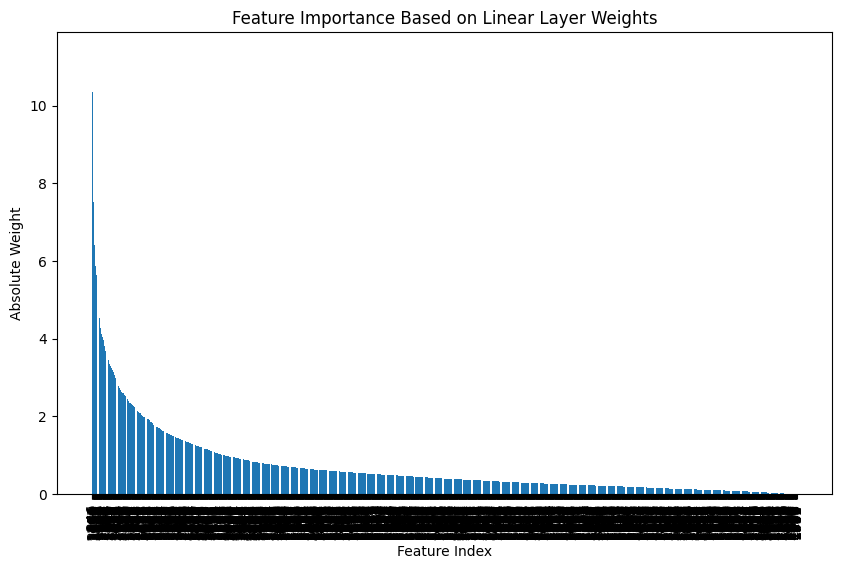

In [19]:
import matplotlib.pyplot as plt

# Convert to numpy array for easier manipulation
weights_np = weights.numpy().flatten()  # Flatten to 1D array

# Calculate the absolute values of the weights
abs_weights = np.abs(weights_np)

# Get the indices of the top features based on weight magnitude
top_features = abs_weights.argsort()[::-1]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(range(len(weights_np)), abs_weights[top_features])
plt.xlabel('Feature Index')
plt.ylabel('Absolute Weight')
plt.title('Feature Importance Based on Linear Layer Weights')
plt.xticks(range(len(weights_np)), top_features, rotation=90)
plt.show()

In [20]:
weights = best_model.l1.weight.data.numpy()
abs_weights = np.abs(weights.flatten())

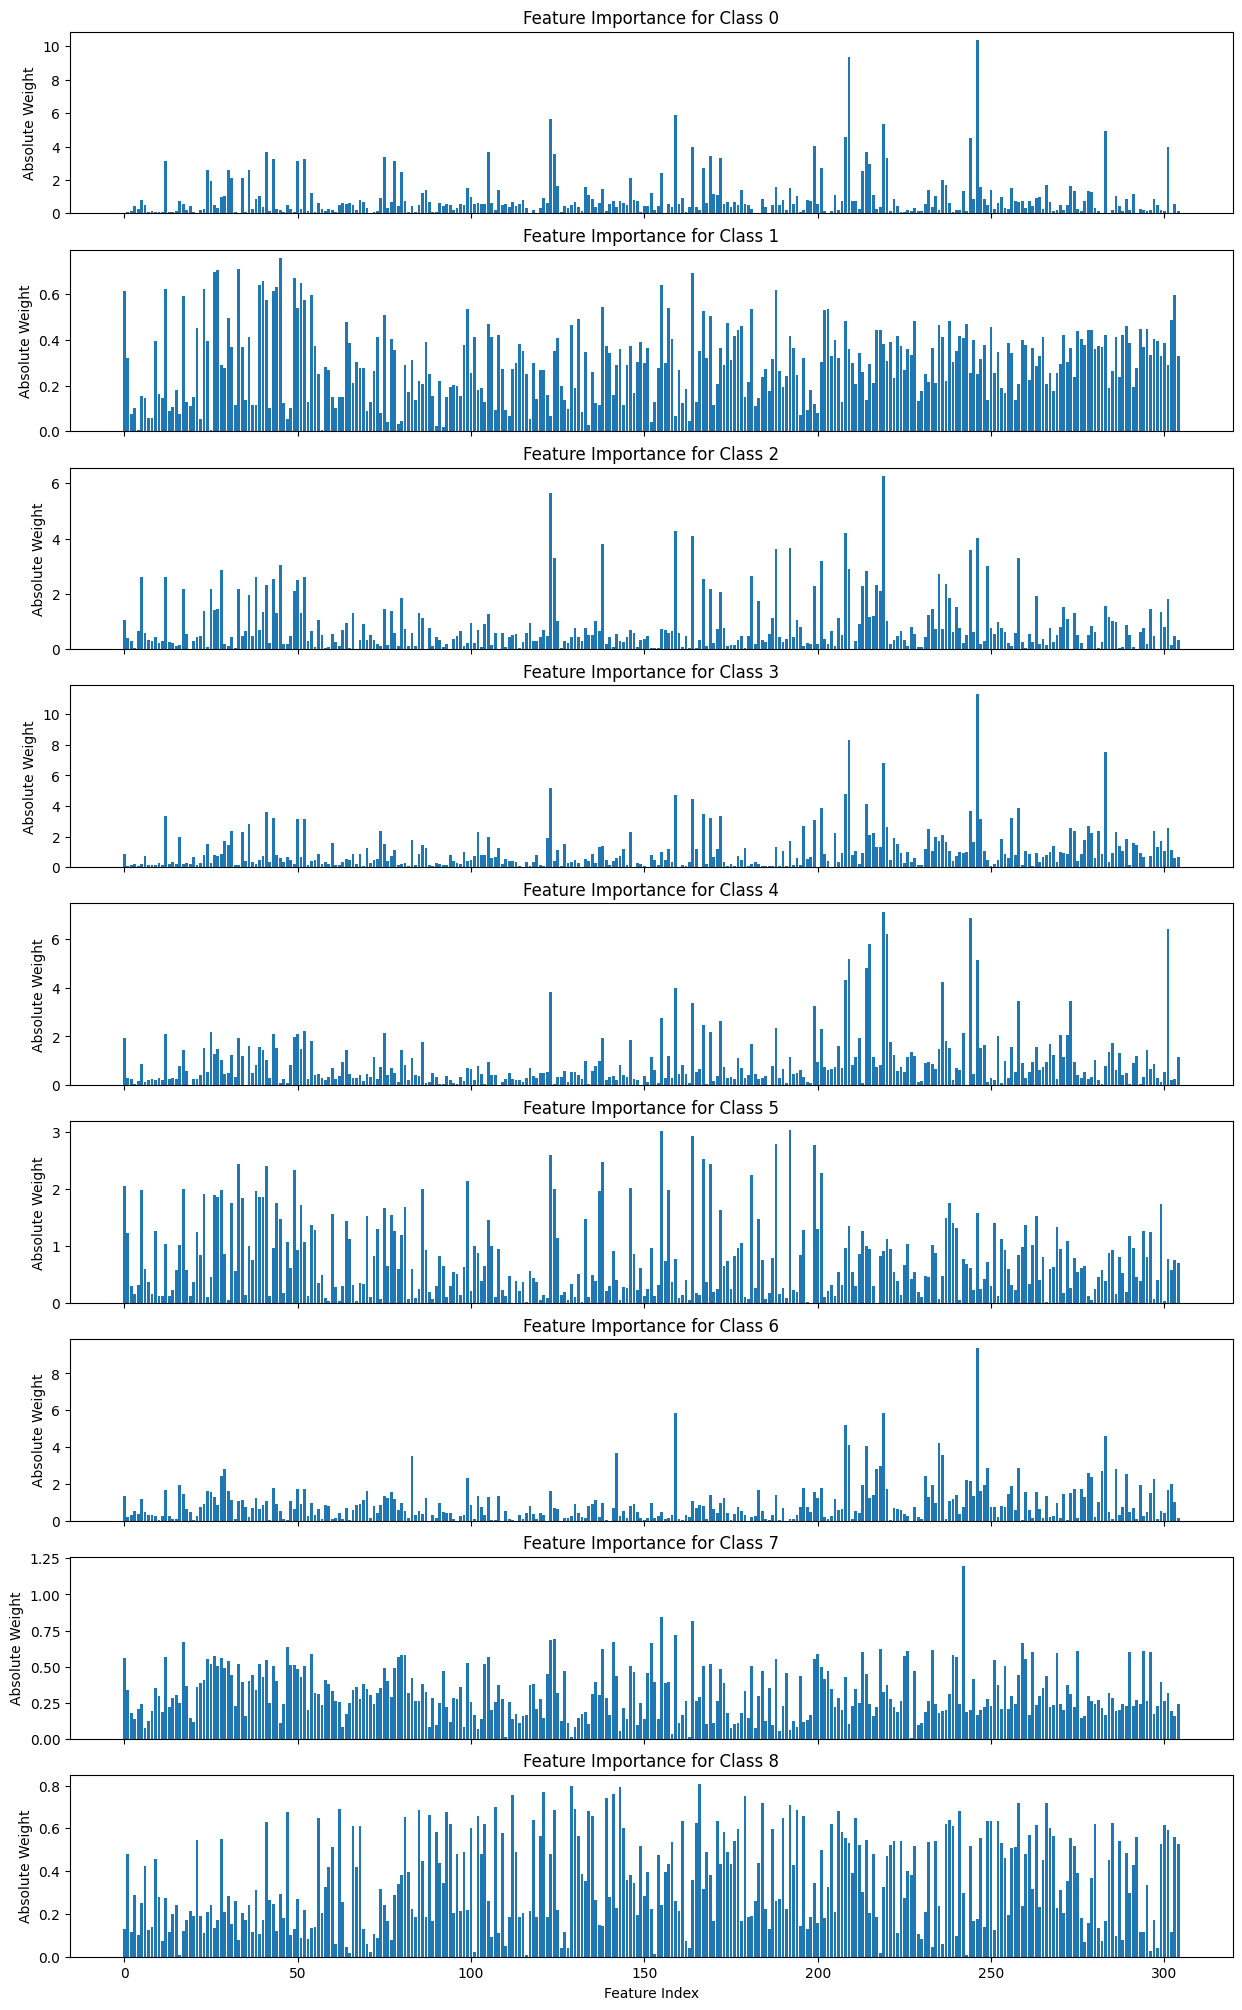

In [21]:
nrows = weights.shape[0]
xrows = weights.shape[1]

fig, axes = plt.subplots(nrows=nrows, ncols=1, figsize=(15, 25), sharex=True)

for i in range(nrows):
    axes[i].bar(range(xrows), abs_weights[i*xrows:(i+1)*xrows])
    axes[i].set_title(f'Feature Importance for Class {i}')
    axes[i].set_ylabel('Absolute Weight')

plt.xlabel('Feature Index')
plt.show()

### Plotting Mean over Classes

In [22]:
from sklearn.preprocessing import minmax_scale

scaled_weights = minmax_scale(weights, axis=0)
weights_mean = np.abs(scaled_weights).mean(axis=0)

In [23]:
sorted_idx = weights_mean.argsort()[::-1]

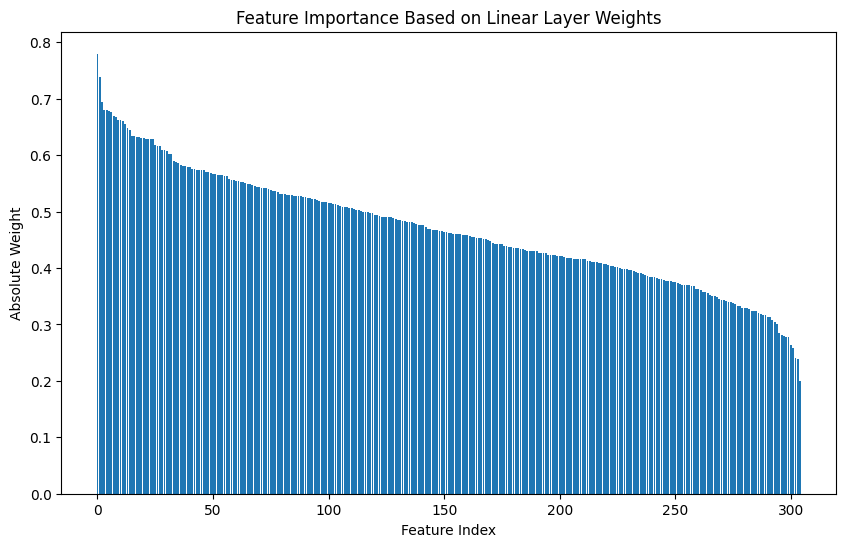

In [24]:
plt.figure(figsize=(10, 6))
plt.bar(range(len(weights_mean[sorted_idx])), weights_mean[sorted_idx])
plt.xlabel('Feature Index')
plt.ylabel('Absolute Weight')
plt.title('Feature Importance Based on Linear Layer Weights')
# plt.xticks(sorted_idx, sorted_idx, rotation=90)
plt.show()

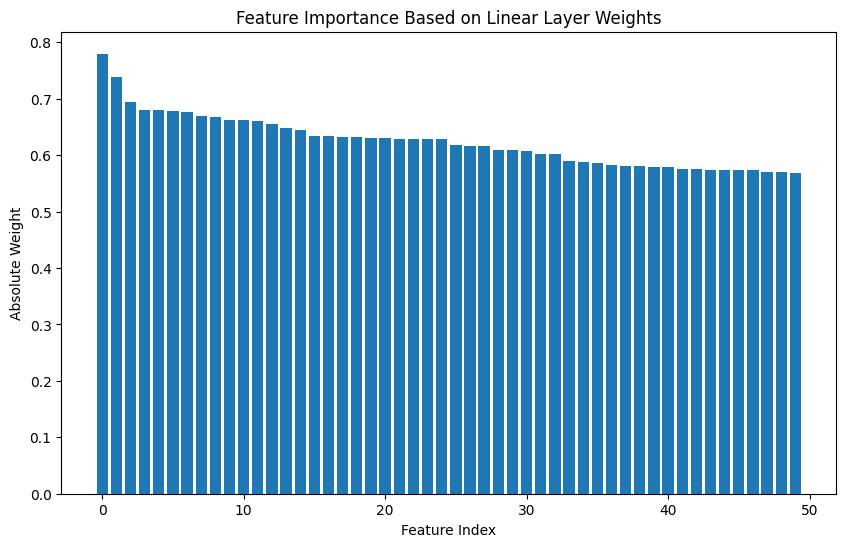

In [25]:
top_k = 50

plt.figure(figsize=(10, 6))
plt.bar(range(len(weights_mean[sorted_idx[:top_k]])), weights_mean[sorted_idx[:top_k]])
plt.xlabel('Feature Index')
plt.ylabel('Absolute Weight')
plt.title('Feature Importance Based on Linear Layer Weights')
# plt.xticks(sorted_idx[:20], sorted_idx[:20], rotation=90)
plt.show()

### Plotting top k per class

In [26]:
topk = 4

In [27]:
topk_indices = weights.argpartition( -topk, axis=1)[:, -topk:]
topk_indices.shape

(9, 4)

In [28]:
topk_indices_sorted = np.take_along_axis(topk_indices, np.argsort(-weights[np.arange(weights.shape[0])[:, None], topk_indices]), axis=1)
topk_indices_sorted.shape

(9, 4)

In [29]:
selected_features = np.array(list(set(topk_indices_sorted.flatten())))
selected_features.shape

(27,)

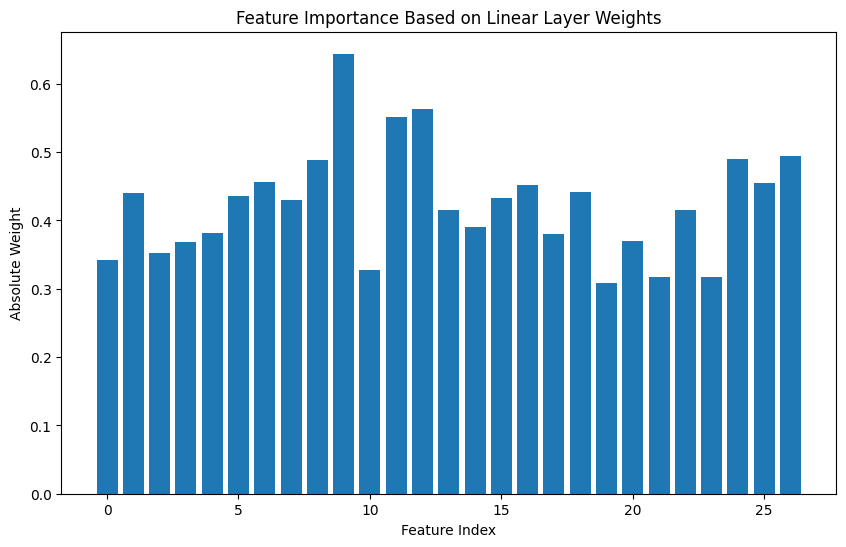

In [30]:
plt.figure(figsize=(10, 6))
plt.bar(range(len(weights_mean[selected_features])), weights_mean[selected_features])
plt.xlabel('Feature Index')
plt.ylabel('Absolute Weight')
plt.title('Feature Importance Based on Linear Layer Weights')
# plt.xticks(sorted_idx[:20], sorted_idx[:20], rotation=90)
plt.show()

### Train again

In [31]:
vectors.iloc[:,selected_features].shape

(14501, 27)

In [32]:
subset = vectors.iloc[:,selected_features]
subset["label"] = df["label"]

/tmp/ipykernel_50881/650136668.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["label"] = df["label"]


In [33]:
# split into train and val
train, val = train_test_split(subset, test_size=0.2, random_state=SEED)

train_dataset = CustomeDataset(train)
train_dataloader = DataLoader(train_dataset, batch_size=500, shuffle=True, num_workers=7)

val_dataset = CustomeDataset(val)
val_dataloader = DataLoader(val_dataset, batch_size=500, shuffle=False, num_workers=7)

# trainer = lightning.Trainer(fast_dev_run=100)
monitor = "Validation/Accuracy"
early_stop_callback = EarlyStopping(monitor=monitor, patience=5, verbose=True, mode="max")
checkpoint_callback = ModelCheckpoint(save_top_k=1, monitor=monitor, mode="max")

tensorboard = pl_loggers.TensorBoardLogger(save_dir=LOG_PATH, name=LOG_NAME_EXPERIMENT_2)
trainer = lightning.Trainer(max_epochs=150, callbacks=[early_stop_callback, checkpoint_callback], enable_checkpointing=True, logger=tensorboard) #logger=None, 


model = MalwaresModelLinearLayer(input_size = subset.shape[1]-1, output_size = len(label_encoder.classes_), seed=SEED)

torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [34]:
trainer.fit(model=model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                      | Params
------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0     
1 | val_metrics   | MetricCollection          | 0     
2 | test_metrics  | MetricCollection          | 0     
3 | cm            | MulticlassConfusionMatrix | 0     
4 | criterion     | CrossEntropyLoss          | 0     
5 | l1            | Linear                    | 252   
------------------------------------------------------------
252       Trainable params
0         Non-trainable params
252       Total params
0.001     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 0
ValidationEpoch/CM
 tensor([[110,   0,   0,   0,   0,   0,   0,   0,   0],
        [ 73,   0,  20,   1,   0,   0,   4,   8,   0],
        [128,   0,   0,   0,   0,   0,   0,   0,   0],
        [129,   0,   0,   0,   0,   0,   0,   0,   0],
        [112,   0,   0,   0,   0,   0,   0,   0,   0],
        [123,   0,   0,   0,   0,   0,   0,   0,   0],
        [ 82,   0,   0,   0,   0,   0,   0,   0,   0],
        [ 11,   0,   1,  65,   0,   0,   0,   0,   0],
        [133,   0,   0,   0,   0,   0,   0,   0,   0]])


/home/<User>/repos/csg_is/.venv/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (24) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 1
ValidationEpoch/CM
 tensor([[ 344, 1098,    2,    0,    2,    0,    0,    0,  124],
        [ 110, 1946,   43,    2,    0,    0,    6,   29,    0],
        [ 407, 1580,   13,    0,    0,    0,    0,    0,   24],
        [ 386, 1163,    3,    0,    0,    0,    0,    0,  172],
        [ 355, 1209,    0,    0,    0,    0,    0,    0,  108],
        [ 355, 1362,    0,    0,    0,    0,    0,    0,    1],
        [ 279, 1095,   18,    0,    0,    0,    0,    0,   90],
        [  23,  246,   18,  186,    0,    0,    0,  704,    0],
        [ 761,   73,   95,    0,    0,    0,    0,    0, 1069]])
Epoch end: Train, epoch number: 0
TrainEpoch/CM
 tensor([[ 344, 1098,    2,    0,    2,    0,    0,    0,  124],
        [ 110, 1946,   43,    2,    0,    0,    6,   29,    0],
        [ 407, 1580,   13,    0,    0,    0,    0,    0,   24],
        [ 386, 1163,    3,    0,    0,    0,    0,    0,  172],
        [ 355, 1209,    0,    0,    0,    0,    0,    0,  1

Metric Validation/Accuracy improved. New best score: 0.333


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 2
ValidationEpoch/CM
 tensor([[ 344, 1230,  164,    0,    7,    3,    0,    0, 1282],
        [ 110, 3976,   43,    2,    0,    0,    6,   29,    0],
        [ 407, 1913,  938,    0,    0,    2,    0,    0,  660],
        [ 386, 1309,  102,    0,    0,   11,    0,    0, 1511],
        [ 355, 1421,   59,    0,   24,    7,    0,    0, 1366],
        [ 355, 2128,  167,    0,    0,  589,    0,    0,   74],
        [ 279, 1284,  451,    0,    0,   17,    0,    0,  851],
        [  23,  249,   18,  186,    0,    0,    0, 1801,    0],
        [ 761,   73,   95,    0,    0,    0,    0,    0, 2934]])


Metric Validation/Accuracy improved by 0.179 >= min_delta = 0.0. New best score: 0.512


Epoch end: Train, epoch number: 1
TrainEpoch/CM
 tensor([[ 344, 1230,  164,    0,    7,    3,    0,    0, 1282],
        [ 110, 3976,   43,    2,    0,    0,    6,   29,    0],
        [ 407, 1913,  938,    0,    0,    2,    0,    0,  660],
        [ 386, 1309,  102,    0,    0,   11,    0,    0, 1511],
        [ 355, 1421,   59,    0,   24,    7,    0,    0, 1366],
        [ 355, 2128,  167,    0,    0,  589,    0,    0,   74],
        [ 279, 1284,  451,    0,    0,   17,    0,    0,  851],
        [  23,  249,   18,  186,    0,    0,    0, 1801,    0],
        [ 761,   73,   95,    0,    0,    0,    0,    0, 2934]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 3
ValidationEpoch/CM
 tensor([[ 344, 1230, 1338,    0,   25,   13,    0,    0, 1540],
        [ 110, 6006,   43,    2,    0,    0,    6,   29,    0],
        [ 407, 1913, 2734,    0,    0,   14,    0,    0,  748],
        [ 386, 1310, 1134,    0,   16,   36,    0,    0, 2032],
        [ 355, 1423,  285,    0,  888,   40,    0,    0, 1801],
        [ 355, 2129,  504,    0,    0, 1818,    0,    0,  102],
        [ 279, 1284, 1619,    0,    5,   57,    0,    0, 1038],
        [  23,  249,   18,  186,    0,    0,    0, 2901,    0],
        [ 761,   73,   95,    0,    0,    0,    0,    0, 4799]])


Metric Validation/Accuracy improved by 0.105 >= min_delta = 0.0. New best score: 0.617


Epoch end: Train, epoch number: 2
TrainEpoch/CM
 tensor([[ 344, 1230, 1338,    0,   25,   13,    0,    0, 1540],
        [ 110, 6006,   43,    2,    0,    0,    6,   29,    0],
        [ 407, 1913, 2734,    0,    0,   14,    0,    0,  748],
        [ 386, 1310, 1134,    0,   16,   36,    0,    0, 2032],
        [ 355, 1423,  285,    0,  888,   40,    0,    0, 1801],
        [ 355, 2129,  504,    0,    0, 1818,    0,    0,  102],
        [ 279, 1284, 1619,    0,    5,   57,    0,    0, 1038],
        [  23,  249,   18,  186,    0,    0,    0, 2901,    0],
        [ 761,   73,   95,    0,    0,    0,    0,    0, 4799]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 4
ValidationEpoch/CM
 tensor([[ 344, 1230, 2734,    2,   52,   23,    0,    0, 1565],
        [ 110, 8036,   43,    2,    0,    0,    6,   29,    0],
        [ 407, 1913, 4611,    0,    0,   26,    0,    0,  755],
        [ 386, 1310, 2593,   18,   57,   61,    0,    0, 2084],
        [ 355, 1423,  444,    0, 2234,   75,    0,    0, 1821],
        [ 355, 2129,  807,    0,    0, 3103,    0,    0,  109],
        [ 279, 1284, 2944,    0,   16,   97,    0,    0, 1062],
        [  23,  249,   18,  186,    0,    0,    0, 4001,    0],
        [ 761,   73,   95,    0,    0,    0,    0,    0, 6664]])


Metric Validation/Accuracy improved by 0.021 >= min_delta = 0.0. New best score: 0.638


Epoch end: Train, epoch number: 3
TrainEpoch/CM
 tensor([[ 344, 1230, 2734,    2,   52,   23,    0,    0, 1565],
        [ 110, 8036,   43,    2,    0,    0,    6,   29,    0],
        [ 407, 1913, 4611,    0,    0,   26,    0,    0,  755],
        [ 386, 1310, 2593,   18,   57,   61,    0,    0, 2084],
        [ 355, 1423,  444,    0, 2234,   75,    0,    0, 1821],
        [ 355, 2129,  807,    0,    0, 3103,    0,    0,  109],
        [ 279, 1284, 2944,    0,   16,   97,    0,    0, 1062],
        [  23,  249,   18,  186,    0,    0,    0, 4001,    0],
        [ 761,   73,   95,    0,    0,    0,    0,    0, 6664]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 5
ValidationEpoch/CM
 tensor([[  344,  1230,  4122,    13,    87,    33,     0,     0,  1581],
        [  110, 10066,    43,     2,     0,     0,     6,    29,     0],
        [  407,  1913,  6495,     0,     0,    38,     0,     0,   755],
        [  386,  1310,  3945,   151,   113,    86,     0,     0,  2113],
        [  355,  1423,   572,     0,  3628,   110,     0,     0,  1824],
        [  355,  2129,  1092,     0,     0,  4409,     0,     0,   113],
        [  279,  1284,  4281,     1,    31,   137,     0,     0,  1069],
        [   23,   249,    18,   186,     0,     0,     0,  5101,     0],
        [  761,    73,    95,     0,     0,     0,     0,     0,  8529]])


Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.639


Epoch end: Train, epoch number: 4
TrainEpoch/CM
 tensor([[  344,  1230,  4122,    13,    87,    33,     0,     0,  1581],
        [  110, 10066,    43,     2,     0,     0,     6,    29,     0],
        [  407,  1913,  6495,     0,     0,    38,     0,     0,   755],
        [  386,  1310,  3945,   151,   113,    86,     0,     0,  2113],
        [  355,  1423,   572,     0,  3628,   110,     0,     0,  1824],
        [  355,  2129,  1092,     0,     0,  4409,     0,     0,   113],
        [  279,  1284,  4281,     1,    31,   137,     0,     0,  1069],
        [   23,   249,    18,   186,     0,     0,     0,  5101,     0],
        [  761,    73,    95,     0,     0,     0,     0,     0,  8529]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 6
ValidationEpoch/CM
 tensor([[  344,  1230,  5505,    37,   124,    43,     0,     0,  1587],
        [  110, 12096,    43,     2,     0,     0,     6,    29,     0],
        [  407,  1913,  8379,     0,     0,    50,     0,     0,   755],
        [  386,  1310,  5272,   317,   178,   111,     0,     0,  2125],
        [  355,  1423,   689,     0,  5036,   145,     0,     0,  1824],
        [  355,  2129,  1404,     0,     0,  5692,     0,     0,   113],
        [  279,  1284,  5613,     3,    52,   177,     0,     0,  1074],
        [   23,   249,    18,   186,     0,     0,     0,  6201,     0],
        [  761,    73,    95,     0,     0,     0,     0,     0, 10394]])


Metric Validation/Accuracy improved by 0.014 >= min_delta = 0.0. New best score: 0.653


Epoch end: Train, epoch number: 5
TrainEpoch/CM
 tensor([[  344,  1230,  5505,    37,   124,    43,     0,     0,  1587],
        [  110, 12096,    43,     2,     0,     0,     6,    29,     0],
        [  407,  1913,  8379,     0,     0,    50,     0,     0,   755],
        [  386,  1310,  5272,   317,   178,   111,     0,     0,  2125],
        [  355,  1423,   689,     0,  5036,   145,     0,     0,  1824],
        [  355,  2129,  1404,     0,     0,  5692,     0,     0,   113],
        [  279,  1284,  5613,     3,    52,   177,     0,     0,  1074],
        [   23,   249,    18,   186,     0,     0,     0,  6201,     0],
        [  761,    73,    95,     0,     0,     0,     0,     0, 10394]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 7
ValidationEpoch/CM
 tensor([[  350,  1230,  6542,   335,   228,    53,     0,     0,  1592],
        [  110, 14126,    43,     2,     0,     0,     6,    29,     0],
        [  407,  1913, 10257,     0,     6,    62,     0,     0,   755],
        [  386,  1310,  6249,   721,   362,   136,     0,     0,  2130],
        [  355,  1423,   746,     0,  6504,   180,     0,     0,  1824],
        [  355,  2129,  1626,     0,     0,  7065,     0,     0,   113],
        [  279,  1284,  6867,    44,   112,   217,     0,     0,  1079],
        [   23,   249,    18,   186,     0,     0,     0,  7301,     0],
        [  761,    73,    95,     0,     0,     0,     0,     0, 12259]])


Metric Validation/Accuracy improved by 0.025 >= min_delta = 0.0. New best score: 0.678


Epoch end: Train, epoch number: 6
TrainEpoch/CM
 tensor([[  350,  1230,  6542,   335,   228,    53,     0,     0,  1592],
        [  110, 14126,    43,     2,     0,     0,     6,    29,     0],
        [  407,  1913, 10257,     0,     6,    62,     0,     0,   755],
        [  386,  1310,  6249,   721,   362,   136,     0,     0,  2130],
        [  355,  1423,   746,     0,  6504,   180,     0,     0,  1824],
        [  355,  2129,  1626,     0,     0,  7065,     0,     0,   113],
        [  279,  1284,  6867,    44,   112,   217,     0,     0,  1079],
        [   23,   249,    18,   186,     0,     0,     0,  7301,     0],
        [  761,    73,    95,     0,     0,     0,     0,     0, 12259]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 8
ValidationEpoch/CM
 tensor([[  399,  1230,  7501,   698,   302,    63,     0,     0,  1597],
        [  110, 16156,    43,     2,     0,     0,     6,    29,     0],
        [  407,  1913, 12136,     0,    11,    74,     0,     0,   755],
        [  386,  1310,  7142,  1209,   551,   161,     0,     0,  2130],
        [  355,  1423,   812,     1,  7962,   215,     0,     0,  1824],
        [  355,  2129,  1846,     0,     0,  8440,     0,     0,   113],
        [  279,  1284,  8121,   101,   159,   257,     0,     0,  1081],
        [   23,   249,    18,   186,     0,     0,     0,  8401,     0],
        [  761,    73,    95,     0,     0,     0,     0,     0, 14124]])


Metric Validation/Accuracy improved by 0.005 >= min_delta = 0.0. New best score: 0.683


Epoch end: Train, epoch number: 7
TrainEpoch/CM
 tensor([[  399,  1230,  7501,   698,   302,    63,     0,     0,  1597],
        [  110, 16156,    43,     2,     0,     0,     6,    29,     0],
        [  407,  1913, 12136,     0,    11,    74,     0,     0,   755],
        [  386,  1310,  7142,  1209,   551,   161,     0,     0,  2130],
        [  355,  1423,   812,     1,  7962,   215,     0,     0,  1824],
        [  355,  2129,  1846,     0,     0,  8440,     0,     0,   113],
        [  279,  1284,  8121,   101,   159,   257,     0,     0,  1081],
        [   23,   249,    18,   186,     0,     0,     0,  8401,     0],
        [  761,    73,    95,     0,     0,     0,     0,     0, 14124]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 9
ValidationEpoch/CM
 tensor([[  621,  1230,  8155,  1224,   345,    73,     0,     0,  1602],
        [  110, 18186,    43,     2,     0,     0,     6,    29,     0],
        [  407,  1913, 13994,    16,    21,    86,     0,     0,   755],
        [  386,  1310,  7865,  1862,   745,   186,     0,     0,  2130],
        [  355,  1423,   865,     6,  9429,   250,     0,     0,  1824],
        [  355,  2129,  2098,     0,     0,  9783,     0,     0,   113],
        [  279,  1284,  9309,   225,   207,   297,     0,     0,  1081],
        [   23,   249,    18,   186,     0,     0,     0,  9501,     0],
        [  761,    73,    95,     0,     0,     0,     0,     0, 15989]])
Epoch end: Train, epoch number: 8
TrainEpoch/CM
 

Metric Validation/Accuracy improved by 0.029 >= min_delta = 0.0. New best score: 0.712


tensor([[  621,  1230,  8155,  1224,   345,    73,     0,     0,  1602],
        [  110, 18186,    43,     2,     0,     0,     6,    29,     0],
        [  407,  1913, 13994,    16,    21,    86,     0,     0,   755],
        [  386,  1310,  7865,  1862,   745,   186,     0,     0,  2130],
        [  355,  1423,   865,     6,  9429,   250,     0,     0,  1824],
        [  355,  2129,  2098,     0,     0,  9783,     0,     0,   113],
        [  279,  1284,  9309,   225,   207,   297,     0,     0,  1081],
        [   23,   249,    18,   186,     0,     0,     0,  9501,     0],
        [  761,    73,    95,     0,     0,     0,     0,     0, 15989]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 10
ValidationEpoch/CM
 tensor([[ 1041,  1230,  8727,  1656,   365,    84,     0,     0,  1607],
        [  110, 20216,    43,     2,     0,     0,     6,    29,     0],
        [  407,  1913, 15849,    33,    33,    98,     0,     0,   755],
        [  386,  1310,  8592,  2515,   935,   211,     0,     0,  2130],
        [  355,  1423,   918,    10, 10897,   285,     0,     0,  1824],
        [  355,  2129,  2264,     0,     0, 11212,     0,     0,   113],
        [  279,  1284, 10489,   350,   262,   337,     0,     0,  1081],
        [   23,   249,    18,   186,     0,     0,     0, 10601,     0],
        [  761,    73,    95,     0,     0,     0,     0,     0, 17854]])
Epoch end: Train, epoch number: 9
TrainEpoch/CM
 tensor([[ 1041,  1230,  8727,  1656,   365,    84,     0,     0,  1607],
        [  110, 20216,    43,     2,     0,     0,     6,    29,     0],
        [  407,  1913, 15849,    33,    33,    98,     0,     0,   755],
        [  386

Metric Validation/Accuracy improved by 0.010 >= min_delta = 0.0. New best score: 0.722


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 11
ValidationEpoch/CM
 tensor([[ 1571,  1230,  9179,  2099,   385,    94,     0,     0,  1612],
        [  110, 22246,    43,     2,     0,     0,     6,    29,     0],
        [  407,  1913, 17696,    63,    40,   110,     0,     0,   755],
        [  386,  1310,  9204,  3271,  1137,   236,     0,     0,  2130],
        [  355,  1423,   971,    15, 12364,   320,     0,     0,  1824],
        [  355,  2129,  2506,     0,     2, 12563,     0,     0,   113],
        [  279,  1284, 11630,   518,   313,   377,     0,     0,  1081],
        [   23,   249,    18,   186,     0,     0,     0, 11701,     0],
        [  761,    73,    95,     0,     0,     0,     0,     0, 19719]])
Epoch end: Train, epoch number: 10
TrainEpoch/CM
 tensor([[ 1571,  1230,  9179,  2099,   385,    94,     0,     0,  1612],
        [  110, 22246,    43,     2,     0,     0,     6,    29,     0],
        [  407,  1913, 17696,    63,    40,   110,     0,     0,   755],
        [  38

Metric Validation/Accuracy improved by 0.034 >= min_delta = 0.0. New best score: 0.756


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 12
ValidationEpoch/CM
 tensor([[ 2279,  1230,  9514,  2481,   405,   104,     0,     0,  1617],
        [  110, 24276,    43,     2,     0,     0,     6,    29,     0],
        [  407,  1913, 19526,   100,    57,   122,     0,     0,   755],
        [  386,  1310,  9723,  4052,  1407,   261,     0,     0,  2130],
        [  355,  1423,  1007,    20, 13848,   355,     0,     0,  1824],
        [  355,  2129,  2674,     0,     5, 13987,     0,     0,   113],
        [  279,  1284, 12735,   673,   413,   417,     0,     0,  1081],
        [   23,   249,    18,   186,     0,     0,     0, 12801,     0],
        [  761,    73,    95,     0,     0,     0,     0,     0, 21584]])
Epoch end: Train, epoch number: 11
TrainEpoch/CM
 tensor([[ 2279,  1230,  9514,  2481,   405,   104,     0,     0,  1617],
        [  110, 24276,    43,     2,     0,     0,     6,    29,     0],
        [  407,  1913, 19526,   100,    57,   122,     0,     0,   755],
        [  38

Metric Validation/Accuracy improved by 0.010 >= min_delta = 0.0. New best score: 0.766


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 13
ValidationEpoch/CM
 tensor([[ 3107,  1230,  9752,  2851,   414,   114,     0,     0,  1622],
        [  110, 26306,    43,     2,     0,     0,     6,    29,     0],
        [  407,  1913, 21352,   156,    59,   134,     0,     0,   755],
        [  396,  1310, 10233,  4918,  1591,   286,     0,     0,  2130],
        [  359,  1423,  1059,    27, 15310,   390,     0,     0,  1824],
        [  355,  2129,  2873,     0,     5, 15383,     0,     0,   113],
        [  281,  1284, 13857,   863,   459,   457,     0,     0,  1081],
        [   23,   249,    18,   186,     0,     0,     0, 13901,     0],
        [  761,    73,    95,     0,     0,     0,     0,     0, 23449]])
Epoch end: Train, epoch number: 12
TrainEpoch/CM
 tensor([[ 3107,  1230,  9752,  2851,   414,   114,     0,     0,  1622],
        [  110, 26306,    43,     2,     0,     0,     6,    29,     0],
        [  407,  1913, 21352,   156,    59,   134,     0,     0,   755],
        [  39

Metric Validation/Accuracy improved by 0.008 >= min_delta = 0.0. New best score: 0.775


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 14
ValidationEpoch/CM
 tensor([[ 3985,  1230,  9874,  3285,   425,   124,     0,     0,  1627],
        [  110, 28336,    43,     2,     0,     0,     6,    29,     0],
        [  407,  1913, 23110,   267,    74,   146,     0,     0,   755],
        [  398,  1310, 10502,  5966,  1842,   311,     0,     0,  2130],
        [  359,  1423,  1090,    37, 16795,   424,     0,     0,  1824],
        [  355,  2129,  3001,     0,     5, 16850,     0,     0,   113],
        [  286,  1284, 14838,  1133,   563,   497,     0,     0,  1081],
        [   23,   249,    18,   186,     0,     0,     0, 15001,     0],
        [  761,    73,    95,     0,     0,     0,     0,     0, 25314]])


Metric Validation/Accuracy improved by 0.011 >= min_delta = 0.0. New best score: 0.785


Epoch end: Train, epoch number: 13
TrainEpoch/CM
 tensor([[ 3985,  1230,  9874,  3285,   425,   124,     0,     0,  1627],
        [  110, 28336,    43,     2,     0,     0,     6,    29,     0],
        [  407,  1913, 23110,   267,    74,   146,     0,     0,   755],
        [  398,  1310, 10502,  5966,  1842,   311,     0,     0,  2130],
        [  359,  1423,  1090,    37, 16795,   424,     0,     0,  1824],
        [  355,  2129,  3001,     0,     5, 16850,     0,     0,   113],
        [  286,  1284, 14838,  1133,   563,   497,     0,     0,  1081],
        [   23,   249,    18,   186,     0,     0,     0, 15001,     0],
        [  761,    73,    95,     0,     0,     0,     0,     0, 25314]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 15
ValidationEpoch/CM
 tensor([[ 4913,  1230, 10045,  3624,   432,   134,     0,     0,  1632],
        [  110, 30366,    43,     2,     0,     0,     6,    29,     0],
        [  407,  1913, 24917,   344,    74,   158,     0,     0,   755],
        [  420,  1310, 10912,  6902,  2044,   336,     0,     0,  2130],
        [  364,  1423,  1134,    47, 18266,   454,     0,     0,  1824],
        [  355,  2129,  3171,     0,     5, 18275,     0,     0,   113],
        [  293,  1284, 15909,  1353,   625,   537,     0,     0,  1081],
        [   23,   249,    18,   186,     0,     0,     0, 16101,     0],
        [  761,    73,    95,     0,     0,     0,     0,     0, 27179]])
Epoch end: Train, epoch number: 14
TrainEpoch/CM
 tensor([[ 4913,  1230, 10045,  3624,   432,   134,     0,     0,  1632],
        [  110, 30366,    43,     2,     0,     0,     6,    29,     0],
        [  407,  1913, 24917,   344,    74,   158,     0,     0,   755],
        [  42

Metric Validation/Accuracy improved by 0.004 >= min_delta = 0.0. New best score: 0.789


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 16
ValidationEpoch/CM
 tensor([[ 5839,  1230, 10158,  4018,   444,   144,     0,     0,  1637],
        [  110, 32396,    43,     2,     0,     0,     6,    29,     0],
        [  407,  1913, 26685,   439,    95,   170,     0,     0,   755],
        [  427,  1310, 11178,  7935,  2308,   361,     0,     0,  2130],
        [  365,  1423,  1149,    57, 19775,   479,     0,     0,  1824],
        [  355,  2129,  3311,     0,     5, 19730,     0,     0,   113],
        [  298,  1284, 16897,  1603,   742,   577,     0,     0,  1081],
        [   23,   249,    18,   186,     0,     0,     0, 17201,     0],
        [  761,    73,    95,     0,     0,     0,     0,     0, 29044]])


Metric Validation/Accuracy improved by 0.006 >= min_delta = 0.0. New best score: 0.795


Epoch end: Train, epoch number: 15
TrainEpoch/CM
 tensor([[ 5839,  1230, 10158,  4018,   444,   144,     0,     0,  1637],
        [  110, 32396,    43,     2,     0,     0,     6,    29,     0],
        [  407,  1913, 26685,   439,    95,   170,     0,     0,   755],
        [  427,  1310, 11178,  7935,  2308,   361,     0,     0,  2130],
        [  365,  1423,  1149,    57, 19775,   479,     0,     0,  1824],
        [  355,  2129,  3311,     0,     5, 19730,     0,     0,   113],
        [  298,  1284, 16897,  1603,   742,   577,     0,     0,  1081],
        [   23,   249,    18,   186,     0,     0,     0, 17201,     0],
        [  761,    73,    95,     0,     0,     0,     0,     0, 29044]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 17
ValidationEpoch/CM
 tensor([[ 6895,  1230, 10239,  4321,   449,   154,     0,     0,  1642],
        [  110, 34426,    43,     2,     0,     0,     6,    29,     0],
        [  407,  1913, 28427,   569,   107,   182,     0,     0,   755],
        [  491,  1310, 11386,  9001,  2536,   386,     4,     0,  2130],
        [  370,  1423,  1175,    70, 21267,   503,     0,     0,  1824],
        [  355,  2129,  3445,     0,     5, 21191,     0,     0,   113],
        [  309,  1284, 17843,  1897,   851,   617,     0,     0,  1081],
        [   23,   249,    18,   186,     0,     0,     0, 18301,     0],
        [  761,    73,    95,     0,     0,     0,     0,     0, 30909]])
Epoch end: Train, epoch number: 16
TrainEpoch/CM
 tensor([[ 6895,  1230, 10239,  4321,   449,   154,     0,     0,  1642],
        [  110, 34426,    43,     2,     0,     0,     6,    29,     0],
        [  407,  1913, 28427,   569,   107,   182,     0,     0,   755],
        [  49

Metric Validation/Accuracy improved by 0.005 >= min_delta = 0.0. New best score: 0.800


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 18
ValidationEpoch/CM
 tensor([[ 8019,  1230, 10312,  4564,   454,   164,     0,     0,  1647],
        [  110, 36456,    43,     2,     0,     0,     6,    29,     0],
        [  422,  1913, 30189,   671,   111,   194,     1,     0,   755],
        [  576,  1310, 11619, 10028,  2756,   411,     9,     0,  2130],
        [  375,  1423,  1203,    80, 22764,   523,     0,     0,  1824],
        [  355,  2129,  3569,     0,     5, 22662,     0,     0,   113],
        [  325,  1284, 18817,  2166,   952,   657,     0,     0,  1081],
        [   23,   249,    18,   186,     0,     0,     0, 19401,     0],
        [  761,    73,    95,     0,     0,     0,     0,     0, 32774]])
Epoch end: Train, epoch number: 17
TrainEpoch/CM
 tensor([[ 8019,  1230, 10312,  4564,   454,   164,     0,     0,  1647],
        [  110, 36456,    43,     2,     0,     0,     6,    29,     0],
        [  422,  1913, 30189,   671,   111,   194,     1,     0,   755],
        [  57

Metric Validation/Accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.800


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 19
ValidationEpoch/CM
 tensor([[ 9031,  1230, 10377,  4927,   459,   174,     0,     0,  1652],
        [  110, 38486,    43,     2,     0,     0,     6,    29,     0],
        [  422,  1913, 31898,   825,   116,   206,    17,     0,   755],
        [  630,  1310, 11800, 11149,  2965,   436,    14,     0,  2130],
        [  380,  1423,  1220,    97, 24272,   536,     0,     0,  1824],
        [  355,  2129,  3681,     0,     5, 24145,     0,     0,   113],
        [  335,  1284, 19720,  2500,  1058,   697,     7,     0,  1081],
        [   23,   249,    18,   186,     0,     0,     0, 20501,     0],
        [  761,    73,    95,     0,     0,     0,     0,     0, 34639]])
Epoch end: Train, epoch number: 18
TrainEpoch/CM
 tensor([[ 9031,  1230, 10377,  4927,   459,   174,     0,     0,  1652],
        [  110, 38486,    43,     2,     0,     0,     6,    29,     0],
        [  422,  1913, 31898,   825,   116,   206,    17,     0,   755],
        [  63

Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.802


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 20
ValidationEpoch/CM
 tensor([[10149,  1230, 10448,  5178,   464,   184,     0,     0,  1657],
        [  110, 40516,    43,     2,     0,     0,     6,    29,     0],
        [  436,  1913, 33633,   955,   116,   218,    22,     0,   755],
        [  729,  1310, 12015, 12202,  3165,   459,    19,     0,  2130],
        [  385,  1423,  1248,   111, 25785,   536,     0,     0,  1824],
        [  355,  2129,  3821,     0,     5, 25600,     0,     0,   113],
        [  358,  1284, 20669,  2789,  1155,   737,     9,     0,  1081],
        [   23,   249,    18,   186,     0,     0,     0, 21601,     0],
        [  761,    73,    95,     0,     0,     0,     0,     0, 36504]])
Epoch end: Train, epoch number: 19
TrainEpoch/CM
 tensor([[10149,  1230, 10448,  5178,   464,   184,     0,     0,  1657],
        [  110, 40516,    43,     2,     0,     0,     6,    29,     0],
        [  436,  1913, 33633,   955,   116,   218,    22,     0,   755],
        [  72

Metric Validation/Accuracy improved by 0.004 >= min_delta = 0.0. New best score: 0.806


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 21
ValidationEpoch/CM
 tensor([[11239,  1230, 10499,  5477,   469,   194,     0,     0,  1662],
        [  110, 42545,    43,     2,     0,     1,     6,    29,     0],
        [  446,  1913, 35338,  1112,   116,   230,    34,     0,   755],
        [  810,  1310, 12176, 13355,  3339,   480,    24,     0,  2130],
        [  390,  1423,  1282,   129, 27283,   541,     0,     0,  1824],
        [  355,  2129,  3932,     0,     5, 27084,     0,     0,   113],
        [  377,  1284, 21587,  3129,  1233,   777,    14,     0,  1081],
        [   23,   249,    18,   186,     0,     0,     0, 22701,     0],
        [  761,    73,    95,     0,     0,     0,     0,     0, 38369]])
Epoch end: Train, epoch number: 20


Metric Validation/Accuracy improved by 0.005 >= min_delta = 0.0. New best score: 0.810


TrainEpoch/CM
 tensor([[11239,  1230, 10499,  5477,   469,   194,     0,     0,  1662],
        [  110, 42545,    43,     2,     0,     1,     6,    29,     0],
        [  446,  1913, 35338,  1112,   116,   230,    34,     0,   755],
        [  810,  1310, 12176, 13355,  3339,   480,    24,     0,  2130],
        [  390,  1423,  1282,   129, 27283,   541,     0,     0,  1824],
        [  355,  2129,  3932,     0,     5, 27084,     0,     0,   113],
        [  377,  1284, 21587,  3129,  1233,   777,    14,     0,  1081],
        [   23,   249,    18,   186,     0,     0,     0, 22701,     0],
        [  761,    73,    95,     0,     0,     0,     0,     0, 38369]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 22
ValidationEpoch/CM
 tensor([[12362,  1230, 10570,  5723,   474,   204,     0,     0,  1667],
        [  110, 44573,    43,     2,     0,     3,     6,    29,     0],
        [  458,  1913, 37064,  1246,   116,   242,    46,     0,   755],
        [  903,  1310, 12389, 14428,  3532,   498,    29,     0,  2130],
        [  395,  1423,  1313,   144, 28792,   541,     0,     0,  1824],
        [  355,  2129,  4048,     0,     5, 28563,     0,     0,   113],
        [  394,  1284, 22530,  3422,  1329,   817,    25,     0,  1081],
        [   23,   249,    18,   186,     0,     0,     0, 23801,     0],
        [  761,    73,    95,     0,     0,     0,     0,     0, 40234]])
Epoch end: Train, epoch number: 21
TrainEpoch/CM
 tensor([[12362,  1230, 10570,  5723,   474,   204,     0,     0,  1667],
        [  110, 44573,    43,     2,     0,     3,     6,    29,     0],
        [  458,  1913, 37064,  1246,   116,   242,    46,     0,   755],
        [  90

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 23
ValidationEpoch/CM
 tensor([[13489,  1230, 10622,  5984,   479,   214,     0,     0,  1672],
        [  110, 46600,    43,     2,     0,     6,     6,    29,     0],
        [  479,  1913, 38773,  1388,   116,   254,    58,     0,   755],
        [ 1003,  1310, 12545, 15564,  3715,   513,    34,     0,  2130],
        [  400,  1423,  1334,   159, 30311,   541,     0,     0,  1824],
        [  355,  2129,  4149,     0,     5, 30057,     0,     0,   113],
        [  415,  1284, 23425,  3755,  1427,   857,    38,     0,  1081],
        [   23,   249,    18,   186,     0,     0,     0, 24901,     0],
        [  761,    73,    95,     0,     0,     0,     0,     0, 42099]])


Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.813


Epoch end: Train, epoch number: 22
TrainEpoch/CM
 tensor([[13489,  1230, 10622,  5984,   479,   214,     0,     0,  1672],
        [  110, 46600,    43,     2,     0,     6,     6,    29,     0],
        [  479,  1913, 38773,  1388,   116,   254,    58,     0,   755],
        [ 1003,  1310, 12545, 15564,  3715,   513,    34,     0,  2130],
        [  400,  1423,  1334,   159, 30311,   541,     0,     0,  1824],
        [  355,  2129,  4149,     0,     5, 30057,     0,     0,   113],
        [  415,  1284, 23425,  3755,  1427,   857,    38,     0,  1081],
        [   23,   249,    18,   186,     0,     0,     0, 24901,     0],
        [  761,    73,    95,     0,     0,     0,     0,     0, 42099]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 24
ValidationEpoch/CM
 tensor([[14676,  1230, 10666,  6193,   484,   224,     0,     0,  1677],
        [  110, 48628,    43,     2,     0,     8,     6,    29,     0],
        [  515,  1913, 40477,  1520,   116,   266,    70,     0,   755],
        [ 1173,  1310, 12697, 16648,  3884,   528,    39,     0,  2130],
        [  405,  1423,  1354,   174, 31831,   541,     0,     0,  1824],
        [  355,  2129,  4249,     0,     5, 31552,     0,     0,   113],
        [  466,  1284, 24303,  4065,  1515,   897,    71,     0,  1081],
        [   23,   249,    18,   186,     0,     0,     0, 26001,     0],
        [  761,    73,    95,     0,     0,     0,     0,     0, 43964]])
Epoch end: Train, epoch number: 23
TrainEpoch/CM
 tensor([[14676,  1230, 10666,  6193,   484,   224,     0,     0,  1677],
        [  110, 48628,    43,     2,     0,     8,     6,    29,     0],
        [  515,  1913, 40477,  1520,   116,   266,    70,     0,   755],
        [ 117

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 25
ValidationEpoch/CM
 tensor([[15825,  1230, 10707,  6443,   489,   234,     0,     0,  1682],
        [  110, 50655,    43,     2,     0,    11,     6,    29,     0],
        [  546,  1913, 42163,  1675,   116,   278,    82,     0,   755],
        [ 1292,  1310, 12833, 17802,  4050,   543,    44,     0,  2130],
        [  410,  1423,  1378,   190, 33346,   541,     0,     0,  1824],
        [  355,  2129,  4350,     0,     5, 33046,     0,     0,   113],
        [  498,  1284, 25167,  4418,  1603,   937,    94,     0,  1081],
        [   23,   249,    18,   186,     0,     0,     0, 27101,     0],
        [  761,    73,    95,     0,     0,     0,     0,     0, 45829]])
Epoch end: Train, epoch number: 24
TrainEpoch/CM
 tensor([[15825,  1230, 10707,  6443,   489,   234,     0,     0,  1682],
        [  110, 50655,    43,     2,     0,    11,     6,    29,     0],
        [  546,  1913, 42163,  1675,   116,   278,    82,     0,   755],
        [ 129

Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.815


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 26
ValidationEpoch/CM
 tensor([[17012,  1230, 10758,  6645,   494,   244,     0,     0,  1687],
        [  110, 52682,    43,     2,     0,    14,     6,    29,     0],
        [  578,  1913, 43868,  1806,   116,   290,    98,     0,   755],
        [ 1440,  1310, 12991, 18897,  4219,   558,    54,     0,  2130],
        [  415,  1423,  1397,   205, 34867,   541,     0,     0,  1824],
        [  355,  2129,  4450,     0,     5, 34541,     0,     0,   113],
        [  535,  1284, 26064,  4720,  1684,   977,   137,     0,  1081],
        [   23,   249,    18,   186,     0,     0,     0, 28201,     0],
        [  761,    73,    95,     0,     0,     0,     0,     0, 47694]])
Epoch end: Train, epoch number: 25
TrainEpoch/CM
 tensor([[17012,  1230, 10758,  6645,   494,   244,     0,     0,  1687],
        [  110, 52682,    43,     2,     0,    14,     6,    29,     0],
        [  578,  1913, 43868,  1806,   116,   290,    98,     0,   755],
        [ 144

Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.816


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 27
ValidationEpoch/CM
 tensor([[18164,  1230, 10784,  6907,   499,   254,     0,     0,  1692],
        [  110, 54707,    43,     2,     0,    19,     6,    29,     0],
        [  601,  1913, 45537,  1970,   120,   302,   122,     0,   755],
        [ 1546,  1310, 13079, 20093,  4389,   573,    74,     0,  2130],
        [  420,  1423,  1412,   224, 36388,   541,     0,     0,  1824],
        [  355,  2129,  4533,     0,     5, 36053,     0,     0,   113],
        [  567,  1284, 26869,  5115,  1769,  1017,   180,     0,  1081],
        [   23,   249,    18,   186,     0,     0,     0, 29301,     0],
        [  761,    73,    95,     0,     0,     0,     0,     0, 49559]])


Metric Validation/Accuracy improved by 0.009 >= min_delta = 0.0. New best score: 0.824


Epoch end: Train, epoch number: 26
TrainEpoch/CM
 tensor([[18164,  1230, 10784,  6907,   499,   254,     0,     0,  1692],
        [  110, 54707,    43,     2,     0,    19,     6,    29,     0],
        [  601,  1913, 45537,  1970,   120,   302,   122,     0,   755],
        [ 1546,  1310, 13079, 20093,  4389,   573,    74,     0,  2130],
        [  420,  1423,  1412,   224, 36388,   541,     0,     0,  1824],
        [  355,  2129,  4533,     0,     5, 36053,     0,     0,   113],
        [  567,  1284, 26869,  5115,  1769,  1017,   180,     0,  1081],
        [   23,   249,    18,   186,     0,     0,     0, 29301,     0],
        [  761,    73,    95,     0,     0,     0,     0,     0, 49559]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 28
ValidationEpoch/CM
 tensor([[19362,  1230, 10811,  7122,   504,   264,     0,     0,  1697],
        [  110, 56732,    43,     2,     0,    24,     6,    29,     0],
        [  643,  1913, 47211,  2126,   120,   314,   134,     0,   755],
        [ 1698,  1310, 13191, 21245,  4540,   588,    87,     0,  2130],
        [  425,  1423,  1429,   242, 37908,   541,     0,     0,  1824],
        [  355,  2129,  4619,     0,     5, 37562,     0,     0,   113],
        [  611,  1284, 27712,  5474,  1844,  1057,   219,     0,  1081],
        [   23,   249,    18,   186,     0,     0,     0, 30401,     0],
        [  761,    73,    95,     0,     0,     0,     0,     0, 51424]])
Epoch end: Train, epoch number: 27
TrainEpoch/CM
 tensor([[19362,  1230, 10811,  7122,   504,   264,     0,     0,  1697],
        [  110, 56732,    43,     2,     0,    24,     6,    29,     0],
        [  643,  1913, 47211,  2126,   120,   314,   134,     0,   755],
        [ 169

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 29
ValidationEpoch/CM
 tensor([[20517,  1230, 10854,  7364,   509,   274,     0,     0,  1702],
        [  110, 58757,    43,     2,     0,    29,     6,    29,     0],
        [  667,  1913, 48909,  2270,   120,   326,   152,     0,   755],
        [ 1806,  1310, 13339, 22427,  4672,   603,    97,     0,  2130],
        [  430,  1423,  1466,   262, 39406,   541,     0,     0,  1824],
        [  355,  2129,  4715,     0,     5, 39061,     0,     0,   113],
        [  641,  1284, 28590,  5837,  1894,  1097,   258,     0,  1081],
        [   23,   249,    18,   186,     0,     0,     0, 31501,     0],
        [  761,    73,    95,     0,     0,     0,     0,     0, 53289]])
Epoch end: Train, epoch number: 28
TrainEpoch/CM
 tensor([[20517,  1230, 10854,  7364,   509,   274,     0,     0,  1702],
        [  110, 58757,    43,     2,     0,    29,     6,    29,     0],
        [  667,  1913, 48909,  2270,   120,   326,   152,     0,   755],
        [ 180

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 30
ValidationEpoch/CM
 tensor([[21680,  1230, 10875,  7620,   514,   284,     0,     0,  1707],
        [  110, 60782,    43,     2,     0,    34,     6,    29,     0],
        [  695,  1913, 50572,  2443,   120,   338,   172,     0,   755],
        [ 1920,  1310, 13418, 23651,  4815,   618,   117,     0,  2130],
        [  435,  1423,  1481,   286, 40922,   541,     0,     0,  1824],
        [  355,  2129,  4780,     0,     5, 40591,     0,     0,   113],
        [  673,  1284, 29395,  6249,  1958,  1137,   305,     0,  1081],
        [   23,   249,    18,   186,     0,     0,     0, 32601,     0],
        [  761,    73,    95,     0,     0,     0,     0,     0, 55154]])


Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.826


Epoch end: Train, epoch number: 29
TrainEpoch/CM
 tensor([[21680,  1230, 10875,  7620,   514,   284,     0,     0,  1707],
        [  110, 60782,    43,     2,     0,    34,     6,    29,     0],
        [  695,  1913, 50572,  2443,   120,   338,   172,     0,   755],
        [ 1920,  1310, 13418, 23651,  4815,   618,   117,     0,  2130],
        [  435,  1423,  1481,   286, 40922,   541,     0,     0,  1824],
        [  355,  2129,  4780,     0,     5, 40591,     0,     0,   113],
        [  673,  1284, 29395,  6249,  1958,  1137,   305,     0,  1081],
        [   23,   249,    18,   186,     0,     0,     0, 32601,     0],
        [  761,    73,    95,     0,     0,     0,     0,     0, 55154]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 31
ValidationEpoch/CM
 tensor([[22881,  1230, 10900,  7834,   519,   294,     0,     0,  1712],
        [  110, 62807,    43,     2,     0,    39,     6,    29,     0],
        [  737,  1913, 52240,  2599,   120,   350,   190,     0,   755],
        [ 2066,  1310, 13507, 24826,  4960,   633,   142,     0,  2130],
        [  440,  1423,  1497,   305, 42442,   541,     0,     0,  1824],
        [  355,  2129,  4851,     0,     5, 42115,     0,     0,   113],
        [  716,  1284, 30215,  6615,  2034,  1177,   360,     0,  1081],
        [   23,   249,    18,   186,     0,     0,     0, 33701,     0],
        [  761,    73,    95,     0,     0,     0,     0,     0, 57019]])
Epoch end: Train, epoch number: 30
TrainEpoch/CM
 tensor([[22881,  1230, 10900,  7834,   519,   294,     0,     0,  1712],
        [  110, 62807,    43,     2,     0,    39,     6,    29,     0],
        [  737,  1913, 52240,  2599,   120,   350,   190,     0,   755],
        [ 206

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 32
ValidationEpoch/CM
 tensor([[24129,  1230, 10919,  8007,   524,   304,     0,     0,  1717],
        [  110, 64832,    43,     2,     0,    44,     6,    29,     0],
        [  780,  1913, 53908,  2755,   120,   362,   207,     0,   755],
        [ 2239,  1310, 13591, 25979,  5101,   648,   171,     0,  2130],
        [  445,  1423,  1512,   324, 43963,   541,     0,     0,  1824],
        [  355,  2129,  4921,     0,     5, 43640,     0,     0,   113],
        [  767,  1284, 31024,  6980,  2106,  1217,   423,     0,  1081],
        [   23,   249,    18,   186,     0,     0,     0, 34801,     0],
        [  761,    73,    95,     0,     0,     0,     0,     0, 58884]])


Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.827


Epoch end: Train, epoch number: 31
TrainEpoch/CM
 tensor([[24129,  1230, 10919,  8007,   524,   304,     0,     0,  1717],
        [  110, 64832,    43,     2,     0,    44,     6,    29,     0],
        [  780,  1913, 53908,  2755,   120,   362,   207,     0,   755],
        [ 2239,  1310, 13591, 25979,  5101,   648,   171,     0,  2130],
        [  445,  1423,  1512,   324, 43963,   541,     0,     0,  1824],
        [  355,  2129,  4921,     0,     5, 43640,     0,     0,   113],
        [  767,  1284, 31024,  6980,  2106,  1217,   423,     0,  1081],
        [   23,   249,    18,   186,     0,     0,     0, 34801,     0],
        [  761,    73,    95,     0,     0,     0,     0,     0, 58884]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 33
ValidationEpoch/CM
 tensor([[25347,  1230, 10943,  8205,   529,   314,     0,     0,  1722],
        [  110, 66857,    43,     2,     0,    49,     6,    29,     0],
        [  822,  1913, 55576,  2911,   120,   374,   225,     0,   755],
        [ 2377,  1310, 13684, 27156,  5246,   663,   198,     0,  2130],
        [  450,  1423,  1527,   342, 45485,   541,     0,     0,  1824],
        [  355,  2129,  4985,     0,     5, 45171,     0,     0,   113],
        [  813,  1284, 31840,  7350,  2174,  1257,   483,     0,  1081],
        [   23,   249,    18,   186,     0,     0,     0, 35901,     0],
        [  761,    73,    95,     0,     0,     0,     0,     0, 60749]])


Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.828


Epoch end: Train, epoch number: 32
TrainEpoch/CM
 tensor([[25347,  1230, 10943,  8205,   529,   314,     0,     0,  1722],
        [  110, 66857,    43,     2,     0,    49,     6,    29,     0],
        [  822,  1913, 55576,  2911,   120,   374,   225,     0,   755],
        [ 2377,  1310, 13684, 27156,  5246,   663,   198,     0,  2130],
        [  450,  1423,  1527,   342, 45485,   541,     0,     0,  1824],
        [  355,  2129,  4985,     0,     5, 45171,     0,     0,   113],
        [  813,  1284, 31840,  7350,  2174,  1257,   483,     0,  1081],
        [   23,   249,    18,   186,     0,     0,     0, 35901,     0],
        [  761,    73,    95,     0,     0,     0,     0,     0, 60749]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 34
ValidationEpoch/CM
 tensor([[26538,  1230, 10968,  8429,   534,   324,     0,     0,  1727],
        [  110, 68882,    43,     2,     0,    54,     6,    29,     0],
        [  849,  1913, 57248,  3067,   120,   386,   254,     0,   755],
        [ 2494,  1310, 13763, 28369,  5379,   678,   236,     0,  2130],
        [  455,  1423,  1545,   365, 46999,   541,     0,     0,  1824],
        [  355,  2129,  5047,     0,     5, 46704,     0,     0,   113],
        [  848,  1284, 32654,  7742,  2219,  1297,   557,     0,  1081],
        [   23,   249,    18,   186,     0,     0,     0, 37001,     0],
        [  761,    73,    95,     0,     0,     0,     0,     0, 62614]])
Epoch end: Train, epoch number: 33
TrainEpoch/CM
 tensor([[26538,  1230, 10968,  8429,   534,   324,     0,     0,  1727],
        [  110, 68882,    43,     2,     0,    54,     6,    29,     0],
        [  849,  1913, 57248,  3067,   120,   386,   254,     0,   755],
        [ 249

Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.831


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 35
ValidationEpoch/CM
 tensor([[27807,  1230, 10984,  8584,   539,   334,     0,     0,  1732],
        [  110, 70911,    43,     2,     0,    55,     6,    29,     0],
        [  880,  1913, 58916,  3223,   120,   398,   283,     0,   755],
        [ 2666,  1310, 13844, 29516,  5509,   693,   286,     0,  2130],
        [  460,  1423,  1561,   381, 48522,   541,     0,     0,  1824],
        [  355,  2129,  5105,     0,     5, 48241,     0,     0,   113],
        [  899,  1284, 33430,  8109,  2274,  1337,   668,     0,  1081],
        [   23,   249,    18,   186,     0,     0,     0, 38101,     0],
        [  761,    73,    95,     0,     0,     0,     0,     0, 64479]])


Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.832


Epoch end: Train, epoch number: 34
TrainEpoch/CM
 tensor([[27807,  1230, 10984,  8584,   539,   334,     0,     0,  1732],
        [  110, 70911,    43,     2,     0,    55,     6,    29,     0],
        [  880,  1913, 58916,  3223,   120,   398,   283,     0,   755],
        [ 2666,  1310, 13844, 29516,  5509,   693,   286,     0,  2130],
        [  460,  1423,  1561,   381, 48522,   541,     0,     0,  1824],
        [  355,  2129,  5105,     0,     5, 48241,     0,     0,   113],
        [  899,  1284, 33430,  8109,  2274,  1337,   668,     0,  1081],
        [   23,   249,    18,   186,     0,     0,     0, 38101,     0],
        [  761,    73,    95,     0,     0,     0,     0,     0, 64479]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 36
ValidationEpoch/CM
 tensor([[29008,  1230, 11000,  8807,   544,   349,     0,     0,  1732],
        [  110, 72937,    43,     2,     0,    59,     6,    29,     0],
        [  911,  1913, 60577,  3388,   120,   410,   310,     0,   755],
        [ 2787,  1310, 13903, 30755,  5635,   708,   321,     0,  2130],
        [  465,  1423,  1576,   406, 50037,   541,     0,     0,  1824],
        [  355,  2129,  5150,     0,     5, 49791,     0,     0,   113],
        [  938,  1284, 34194,  8540,  2318,  1377,   750,     0,  1081],
        [   23,   249,    18,   186,     0,     0,     0, 39201,     0],
        [  761,    73,    95,     0,     0,     0,     0,     0, 66344]])


Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.834


Epoch end: Train, epoch number: 35
TrainEpoch/CM
 tensor([[29008,  1230, 11000,  8807,   544,   349,     0,     0,  1732],
        [  110, 72937,    43,     2,     0,    59,     6,    29,     0],
        [  911,  1913, 60577,  3388,   120,   410,   310,     0,   755],
        [ 2787,  1310, 13903, 30755,  5635,   708,   321,     0,  2130],
        [  465,  1423,  1576,   406, 50037,   541,     0,     0,  1824],
        [  355,  2129,  5150,     0,     5, 49791,     0,     0,   113],
        [  938,  1284, 34194,  8540,  2318,  1377,   750,     0,  1081],
        [   23,   249,    18,   186,     0,     0,     0, 39201,     0],
        [  761,    73,    95,     0,     0,     0,     0,     0, 66344]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 37
ValidationEpoch/CM
 tensor([[30266,  1230, 11026,  8963,   549,   364,     0,     0,  1732],
        [  110, 74962,    43,     2,     0,    64,     6,    29,     0],
        [  935,  1913, 62238,  3544,   120,   410,   365,     0,   755],
        [ 2929,  1310, 13986, 31911,  5759,   723,   396,     0,  2130],
        [  470,  1423,  1595,   429, 51550,   541,     0,     0,  1824],
        [  355,  2129,  5206,     0,     5, 51330,     0,     0,   113],
        [  970,  1284, 34973,  8899,  2357,  1417,   901,     0,  1081],
        [   23,   249,    18,   186,     0,     0,     0, 40301,     0],
        [  761,    73,    95,     0,     0,     0,     0,     0, 68209]])


Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.835


Epoch end: Train, epoch number: 36
TrainEpoch/CM
 tensor([[30266,  1230, 11026,  8963,   549,   364,     0,     0,  1732],
        [  110, 74962,    43,     2,     0,    64,     6,    29,     0],
        [  935,  1913, 62238,  3544,   120,   410,   365,     0,   755],
        [ 2929,  1310, 13986, 31911,  5759,   723,   396,     0,  2130],
        [  470,  1423,  1595,   429, 51550,   541,     0,     0,  1824],
        [  355,  2129,  5206,     0,     5, 51330,     0,     0,   113],
        [  970,  1284, 34973,  8899,  2357,  1417,   901,     0,  1081],
        [   23,   249,    18,   186,     0,     0,     0, 40301,     0],
        [  761,    73,    95,     0,     0,     0,     0,     0, 68209]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 38
ValidationEpoch/CM
 tensor([[31501,  1230, 11046,  9148,   554,   379,     0,     0,  1732],
        [  110, 76988,    43,     2,     0,    68,     6,    29,     0],
        [  965,  1913, 63901,  3705,   120,   410,   407,     0,   755],
        [ 3049,  1310, 14051, 33131,  5890,   738,   440,     0,  2130],
        [  475,  1423,  1611,   454, 53064,   541,     0,     0,  1824],
        [  355,  2129,  5258,     0,     5, 52873,     0,     0,   113],
        [ 1012,  1284, 35734,  9301,  2402,  1457,  1011,     0,  1081],
        [   23,   249,    18,   186,     0,     0,     0, 41401,     0],
        [  761,    73,    95,     0,     0,     0,     0,     0, 70074]])


Metric Validation/Accuracy improved by 0.004 >= min_delta = 0.0. New best score: 0.839


Epoch end: Train, epoch number: 37
TrainEpoch/CM
 tensor([[31501,  1230, 11046,  9148,   554,   379,     0,     0,  1732],
        [  110, 76988,    43,     2,     0,    68,     6,    29,     0],
        [  965,  1913, 63901,  3705,   120,   410,   407,     0,   755],
        [ 3049,  1310, 14051, 33131,  5890,   738,   440,     0,  2130],
        [  475,  1423,  1611,   454, 53064,   541,     0,     0,  1824],
        [  355,  2129,  5258,     0,     5, 52873,     0,     0,   113],
        [ 1012,  1284, 35734,  9301,  2402,  1457,  1011,     0,  1081],
        [   23,   249,    18,   186,     0,     0,     0, 41401,     0],
        [  761,    73,    95,     0,     0,     0,     0,     0, 70074]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 39
ValidationEpoch/CM
 tensor([[32758,  1230, 11070,  9307,   559,   394,     0,     0,  1732],
        [  110, 79014,    43,     2,     0,    72,     6,    29,     0],
        [  990,  1913, 65566,  3861,   120,   410,   457,     0,   755],
        [ 3172,  1310, 14125, 34320,  6013,   753,   511,     0,  2130],
        [  480,  1423,  1632,   477, 54575,   541,     0,     0,  1824],
        [  355,  2129,  5318,     0,     5, 54408,     0,     0,   113],
        [ 1055,  1284, 36512,  9674,  2443,  1497,  1136,     0,  1081],
        [   23,   249,    18,   186,     0,     0,     0, 42501,     0],
        [  761,    73,    95,     0,     0,     0,     0,     0, 71939]])


Metric Validation/Accuracy improved by 0.004 >= min_delta = 0.0. New best score: 0.843


Epoch end: Train, epoch number: 38
TrainEpoch/CM
 tensor([[32758,  1230, 11070,  9307,   559,   394,     0,     0,  1732],
        [  110, 79014,    43,     2,     0,    72,     6,    29,     0],
        [  990,  1913, 65566,  3861,   120,   410,   457,     0,   755],
        [ 3172,  1310, 14125, 34320,  6013,   753,   511,     0,  2130],
        [  480,  1423,  1632,   477, 54575,   541,     0,     0,  1824],
        [  355,  2129,  5318,     0,     5, 54408,     0,     0,   113],
        [ 1055,  1284, 36512,  9674,  2443,  1497,  1136,     0,  1081],
        [   23,   249,    18,   186,     0,     0,     0, 42501,     0],
        [  761,    73,    95,     0,     0,     0,     0,     0, 71939]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 40
ValidationEpoch/CM
 tensor([[33997,  1230, 11085,  9493,   564,   409,     0,     0,  1732],
        [  110, 81042,    43,     2,     0,    74,     6,    29,     0],
        [ 1014,  1913, 67220,  4025,   120,   410,   511,     0,   755],
        [ 3286,  1310, 14175, 35560,  6120,   768,   580,     0,  2130],
        [  485,  1423,  1647,   502, 56090,   541,     0,     0,  1824],
        [  355,  2129,  5366,     0,     5, 55955,     0,     0,   113],
        [ 1095,  1284, 37258, 10073,  2483,  1535,  1273,     0,  1081],
        [   23,   249,    18,   186,     0,     0,     0, 43601,     0],
        [  761,    73,    95,     0,     0,     0,     0,     0, 73804]])
Epoch end: Train, epoch number: 39
TrainEpoch/CM
 tensor([[33997,  1230, 11085,  9493,   564,   409,     0,     0,  1732],
        [  110, 81042,    43,     2,     0,    74,     6,    29,     0],
        [ 1014,  1913, 67220,  4025,   120,   410,   511,     0,   755],
        [ 328

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 41
ValidationEpoch/CM
 tensor([[35270,  1230, 11100,  9645,   569,   424,     0,     0,  1732],
        [  110, 83072,    43,     2,     0,    74,     6,    29,     0],
        [ 1040,  1913, 68880,  4181,   120,   410,   565,     0,   755],
        [ 3408,  1310, 14230, 36778,  6237,   783,   648,     0,  2130],
        [  490,  1423,  1662,   527, 57605,   541,     0,     0,  1824],
        [  355,  2129,  5414,     0,     5, 57502,     0,     0,   113],
        [ 1135,  1284, 38013, 10469,  2528,  1570,  1402,     0,  1081],
        [   23,   249,    18,   186,     0,     0,     0, 44701,     0],
        [  761,    73,    95,     0,     0,     0,     0,     0, 75669]])
Epoch end: Train, epoch number: 40
TrainEpoch/CM
 tensor([[35270,  1230, 11100,  9645,   569,   424,     0,     0,  1732],
        [  110, 83072,    43,     2,     0,    74,     6,    29,     0],
        [ 1040,  1913, 68880,  4181,   120,   410,   565,     0,   755],
        [ 340

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 42
ValidationEpoch/CM
 tensor([[36572,  1230, 11115,  9768,   574,   439,     0,     0,  1732],
        [  110, 85102,    43,     2,     0,    74,     6,    29,     0],
        [ 1064,  1913, 70536,  4337,   120,   410,   625,     0,   755],
        [ 3544,  1310, 14284, 37984,  6350,   798,   719,     0,  2130],
        [  495,  1423,  1677,   552, 59120,   541,     0,     0,  1824],
        [  355,  2129,  5456,     0,     5, 59055,     0,     0,   113],
        [ 1182,  1284, 38751, 10858,  2574,  1599,  1553,     0,  1081],
        [   23,   249,    18,   186,     0,     0,     0, 45801,     0],
        [  761,    73,    95,     0,     0,     0,     0,     0, 77534]])
Epoch end: Train, epoch number: 41
TrainEpoch/CM
 tensor([[36572,  1230, 11115,  9768,   574,   439,     0,     0,  1732],
        [  110, 85102,    43,     2,     0,    74,     6,    29,     0],
        [ 1064,  1913, 70536,  4337,   120,   410,   625,     0,   755],
        [ 354

Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.845


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 43
ValidationEpoch/CM
 tensor([[37854,  1230, 11130,  9911,   579,   454,     0,     0,  1732],
        [  110, 87130,    43,     2,     0,    76,     6,    29,     0],
        [ 1088,  1913, 72187,  4498,   120,   410,   685,     0,   755],
        [ 3668,  1310, 14329, 39217,  6450,   813,   797,     0,  2130],
        [  500,  1423,  1693,   577, 60634,   541,     0,     0,  1824],
        [  355,  2129,  5498,     0,     5, 60608,     0,     0,   113],
        [ 1223,  1284, 39490, 11256,  2611,  1624,  1713,     0,  1081],
        [   23,   249,    18,   186,     0,     0,     0, 46901,     0],
        [  761,    73,    95,     0,     0,     0,     0,     0, 79399]])
Epoch end: Train, epoch number: 42
TrainEpoch/CM
 tensor([[37854,  1230, 11130,  9911,   579,   454,     0,     0,  1732],
        [  110, 87130,    43,     2,     0,    76,     6,    29,     0],
        [ 1088,  1913, 72187,  4498,   120,   410,   685,     0,   755],
        [ 366

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 44
ValidationEpoch/CM
 tensor([[39141,  1230, 11148, 10051,   584,   464,     0,     0,  1732],
        [  110, 89160,    43,     2,     0,    76,     6,    29,     0],
        [ 1112,  1913, 73843,  4654,   120,   410,   745,     0,   755],
        [ 3785,  1310, 14384, 40444,  6557,   828,   871,     0,  2130],
        [  505,  1423,  1708,   602, 62149,   541,     0,     0,  1824],
        [  355,  2129,  5546,     0,     5, 62155,     0,     0,   113],
        [ 1263,  1284, 40237, 11649,  2653,  1649,  1866,     0,  1081],
        [   23,   249,    18,   186,     0,     0,     0, 48001,     0],
        [  761,    73,    95,     0,     0,     0,     0,     0, 81264]])
Epoch end: Train, epoch number: 43
TrainEpoch/CM
 tensor([[39141,  1230, 11148, 10051,   584,   464,     0,     0,  1732],
        [  110, 89160,    43,     2,     0,    76,     6,    29,     0],
        [ 1112,  1913, 73843,  4654,   120,   410,   745,     0,   755],
        [ 378

Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.847


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 45
ValidationEpoch/CM
 tensor([[40426,  1230, 11163, 10193,   589,   477,     0,     0,  1732],
        [  110, 91190,    43,     2,     0,    76,     6,    29,     0],
        [ 1136,  1913, 75489,  4820,   120,   410,   805,     0,   755],
        [ 3905,  1310, 14422, 41683,  6657,   843,   954,     0,  2130],
        [  510,  1423,  1723,   627, 63664,   541,     0,     0,  1824],
        [  355,  2129,  5586,     0,     5, 63710,     0,     0,   113],
        [ 1296,  1284, 40964, 12054,  2686,  1674,  2043,     0,  1081],
        [   23,   249,    18,   186,     0,     0,     0, 49101,     0],
        [  761,    73,    95,     0,     0,     0,     0,     0, 83129]])


Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.849


Epoch end: Train, epoch number: 44
TrainEpoch/CM
 tensor([[40426,  1230, 11163, 10193,   589,   477,     0,     0,  1732],
        [  110, 91190,    43,     2,     0,    76,     6,    29,     0],
        [ 1136,  1913, 75489,  4820,   120,   410,   805,     0,   755],
        [ 3905,  1310, 14422, 41683,  6657,   843,   954,     0,  2130],
        [  510,  1423,  1723,   627, 63664,   541,     0,     0,  1824],
        [  355,  2129,  5586,     0,     5, 63710,     0,     0,   113],
        [ 1296,  1284, 40964, 12054,  2686,  1674,  2043,     0,  1081],
        [   23,   249,    18,   186,     0,     0,     0, 49101,     0],
        [  761,    73,    95,     0,     0,     0,     0,     0, 83129]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 46
ValidationEpoch/CM
 tensor([[41714,  1230, 11180, 10333,   594,   487,     0,     0,  1732],
        [  110, 93220,    43,     2,     0,    76,     6,    29,     0],
        [ 1160,  1913, 77139,  4980,   120,   410,   867,     0,   755],
        [ 4019,  1310, 14465, 42921,  6753,   858,  1043,     0,  2130],
        [  515,  1423,  1740,   652, 65177,   541,     0,     0,  1824],
        [  355,  2129,  5633,     0,     5, 65258,     0,     0,   113],
        [ 1326,  1284, 41694, 12457,  2711,  1699,  2230,     0,  1081],
        [   23,   249,    18,   186,     0,     0,     0, 50201,     0],
        [  761,    73,    95,     0,     0,     0,     0,     0, 84994]])


Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.850


Epoch end: Train, epoch number: 45
TrainEpoch/CM
 tensor([[41714,  1230, 11180, 10333,   594,   487,     0,     0,  1732],
        [  110, 93220,    43,     2,     0,    76,     6,    29,     0],
        [ 1160,  1913, 77139,  4980,   120,   410,   867,     0,   755],
        [ 4019,  1310, 14465, 42921,  6753,   858,  1043,     0,  2130],
        [  515,  1423,  1740,   652, 65177,   541,     0,     0,  1824],
        [  355,  2129,  5633,     0,     5, 65258,     0,     0,   113],
        [ 1326,  1284, 41694, 12457,  2711,  1699,  2230,     0,  1081],
        [   23,   249,    18,   186,     0,     0,     0, 50201,     0],
        [  761,    73,    95,     0,     0,     0,     0,     0, 84994]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 47
ValidationEpoch/CM
 tensor([[43026,  1230, 11196, 10450,   599,   497,     0,     0,  1732],
        [  110, 95247,    43,     2,     0,    79,     6,    29,     0],
        [ 1188,  1913, 78795,  5136,   120,   410,   923,     0,   755],
        [ 4145,  1310, 14512, 44168,  6849,   873,  1107,     0,  2130],
        [  520,  1423,  1757,   677, 66690,   541,     0,     0,  1824],
        [  355,  2129,  5673,     0,     5, 66813,     0,     0,   113],
        [ 1370,  1284, 42434, 12860,  2743,  1724,  2386,     0,  1081],
        [   23,   249,    18,   186,     0,     0,     0, 51301,     0],
        [  761,    73,    95,     0,     0,     0,     0,     0, 86859]])


Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.852


Epoch end: Train, epoch number: 46
TrainEpoch/CM
 tensor([[43026,  1230, 11196, 10450,   599,   497,     0,     0,  1732],
        [  110, 95247,    43,     2,     0,    79,     6,    29,     0],
        [ 1188,  1913, 78795,  5136,   120,   410,   923,     0,   755],
        [ 4145,  1310, 14512, 44168,  6849,   873,  1107,     0,  2130],
        [  520,  1423,  1757,   677, 66690,   541,     0,     0,  1824],
        [  355,  2129,  5673,     0,     5, 66813,     0,     0,   113],
        [ 1370,  1284, 42434, 12860,  2743,  1724,  2386,     0,  1081],
        [   23,   249,    18,   186,     0,     0,     0, 51301,     0],
        [  761,    73,    95,     0,     0,     0,     0,     0, 86859]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 48
ValidationEpoch/CM
 tensor([[44328,  1230, 11211, 10578,   604,   507,     0,     0,  1732],
        [  110, 97277,    43,     2,     0,    79,     6,    29,     0],
        [ 1212,  1913, 80440,  5299,   120,   410,   987,     0,   755],
        [ 4268,  1310, 14550, 45428,  6932,   888,  1183,     0,  2130],
        [  525,  1423,  1772,   702, 68205,   541,     0,     0,  1824],
        [  355,  2129,  5715,     0,     5, 68366,     0,     0,   113],
        [ 1408,  1284, 43154, 13268,  2768,  1749,  2570,     0,  1081],
        [   23,   249,    18,   186,     0,     0,     0, 52401,     0],
        [  761,    73,    95,     0,     0,     0,     0,     0, 88724]])
Epoch end: Train, epoch number: 47
TrainEpoch/CM
 tensor([[44328,  1230, 11211, 10578,   604,   507,     0,     0,  1732],
        [  110, 97277,    43,     2,     0,    79,     6,    29,     0],
        [ 1212,  1913, 80440,  5299,   120,   410,   987,     0,   755],
        [ 426

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 49
ValidationEpoch/CM
 tensor([[45632,  1230, 11230, 10700,   609,   517,     0,     0,  1732],
        [  110, 99307,    43,     2,     0,    79,     6,    29,     0],
        [ 1236,  1913, 82091,  5455,   120,   410,  1052,     0,   755],
        [ 4376,  1310, 14595, 46659,  7026,   903,  1285,     0,  2130],
        [  530,  1423,  1790,   727, 69717,   541,     0,     0,  1824],
        [  355,  2129,  5759,     0,     5, 69917,     0,     0,   113],
        [ 1431,  1284, 43880, 13656,  2793,  1774,  2783,     0,  1081],
        [   23,   249,    18,   186,     0,     0,     0, 53501,     0],
        [  761,    73,    95,     0,     0,     0,     0,     0, 90589]])


Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.852


Epoch end: Train, epoch number: 48
TrainEpoch/CM
 tensor([[45632,  1230, 11230, 10700,   609,   517,     0,     0,  1732],
        [  110, 99307,    43,     2,     0,    79,     6,    29,     0],
        [ 1236,  1913, 82091,  5455,   120,   410,  1052,     0,   755],
        [ 4376,  1310, 14595, 46659,  7026,   903,  1285,     0,  2130],
        [  530,  1423,  1790,   727, 69717,   541,     0,     0,  1824],
        [  355,  2129,  5759,     0,     5, 69917,     0,     0,   113],
        [ 1431,  1284, 43880, 13656,  2793,  1774,  2783,     0,  1081],
        [   23,   249,    18,   186,     0,     0,     0, 53501,     0],
        [  761,    73,    95,     0,     0,     0,     0,     0, 90589]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 50
ValidationEpoch/CM
 tensor([[ 46926,   1230,  11245,  10836,    614,    527,      0,      0,   1732],
        [   110, 101337,     43,      2,      0,     79,      6,     29,      0],
        [  1260,   1913,  83735,   5619,    120,    410,   1116,      0,    755],
        [  4490,   1310,  14635,  47938,   7103,    918,   1355,      0,   2130],
        [   535,   1423,   1805,    752,  71232,    541,      0,      0,   1824],
        [   355,   2129,   5804,      0,      5,  71467,      0,      0,    113],
        [  1469,   1284,  44601,  14066,   2821,   1799,   2961,      0,   1081],
        [    23,    249,     18,    186,      0,      0,      0,  54601,      0],
        [   761,     73,     95,      0,      0,      0,      0,      0,  92454]])
Epoch end: Train, epoch number: 49


Metric Validation/Accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.855


TrainEpoch/CM
 tensor([[ 46926,   1230,  11245,  10836,    614,    527,      0,      0,   1732],
        [   110, 101337,     43,      2,      0,     79,      6,     29,      0],
        [  1260,   1913,  83735,   5619,    120,    410,   1116,      0,    755],
        [  4490,   1310,  14635,  47938,   7103,    918,   1355,      0,   2130],
        [   535,   1423,   1805,    752,  71232,    541,      0,      0,   1824],
        [   355,   2129,   5804,      0,      5,  71467,      0,      0,    113],
        [  1469,   1284,  44601,  14066,   2821,   1799,   2961,      0,   1081],
        [    23,    249,     18,    186,      0,      0,      0,  54601,      0],
        [   761,     73,     95,      0,      0,      0,      0,      0,  92454]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 51
ValidationEpoch/CM
 tensor([[ 48238,   1230,  11260,  10954,    619,    537,      0,      0,   1732],
        [   110, 103367,     43,      2,      0,     79,      6,     29,      0],
        [  1284,   1913,  85371,   5783,    120,    410,   1188,      0,    755],
        [  4592,   1310,  14667,  49202,   7180,    933,   1460,      0,   2130],
        [   540,   1423,   1820,    777,  72747,    541,      0,      0,   1824],
        [   355,   2129,   5837,      0,      5,  73029,      0,      0,    113],
        [  1488,   1284,  45286,  14468,   2846,   1825,   3204,      0,   1081],
        [    23,    249,     18,    186,      0,      0,      0,  55701,      0],
        [   761,     73,     95,      0,      0,      0,      0,      0,  94319]])


Metric Validation/Accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.858


Epoch end: Train, epoch number: 50
TrainEpoch/CM
 tensor([[ 48238,   1230,  11260,  10954,    619,    537,      0,      0,   1732],
        [   110, 103367,     43,      2,      0,     79,      6,     29,      0],
        [  1284,   1913,  85371,   5783,    120,    410,   1188,      0,    755],
        [  4592,   1310,  14667,  49202,   7180,    933,   1460,      0,   2130],
        [   540,   1423,   1820,    777,  72747,    541,      0,      0,   1824],
        [   355,   2129,   5837,      0,      5,  73029,      0,      0,    113],
        [  1488,   1284,  45286,  14468,   2846,   1825,   3204,      0,   1081],
        [    23,    249,     18,    186,      0,      0,      0,  55701,      0],
        [   761,     73,     95,      0,      0,      0,      0,      0,  94319]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 52
ValidationEpoch/CM
 tensor([[ 49572,   1230,  11276,  11047,    624,    547,      2,      0,   1732],
        [   110, 105397,     43,      2,      0,     79,      6,     29,      0],
        [  1308,   1913,  87019,   5941,    120,    410,   1254,      0,    755],
        [  4703,   1310,  14707,  50451,   7258,    948,   1562,      0,   2130],
        [   545,   1423,   1838,    802,  74259,    541,      0,      0,   1824],
        [   355,   2129,   5875,      0,      5,  74586,      0,      0,    113],
        [  1511,   1284,  45991,  14856,   2871,   1850,   3438,      0,   1081],
        [    23,    249,     18,    186,      0,      0,      0,  56801,      0],
        [   761,     73,     95,      0,      0,      0,      0,      0,  96184]])
Epoch end: Train, epoch number: 51
TrainEpoch/CM
 tensor([[ 49572,   1230,  11276,  11047,    624,    547,      2,      0,   1732],
        [   110, 105397,     43,      2,      0,     79,      6,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 53
ValidationEpoch/CM
 tensor([[ 50894,   1230,  11291,  11155,    629,    557,      2,      0,   1732],
        [   110, 107427,     43,      2,      0,     79,      6,     29,      0],
        [  1332,   1913,  88648,   6109,    120,    410,   1329,      0,    755],
        [  4801,   1310,  14729,  51741,   7331,    963,   1659,      0,   2130],
        [   550,   1423,   1853,    827,  75774,    541,      0,      0,   1824],
        [   355,   2129,   5896,      0,      5,  76160,      0,      0,    113],
        [  1538,   1284,  46643,  15264,   2896,   1878,   3698,      0,   1081],
        [    23,    249,     18,    186,      0,      0,      0,  57901,      0],
        [   761,     73,     95,      0,      0,      0,      0,      0,  98049]])
Epoch end: Train, epoch number: 52
TrainEpoch/CM
 tensor([[ 50894,   1230,  11291,  11155,    629,    557,      2,      0,   1732],
        [   110, 107427,     43,      2,      0,     79,      6,     

Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.859


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 54
ValidationEpoch/CM
 tensor([[ 52243,   1230,  11306,  11236,    634,    567,      2,      0,   1732],
        [   110, 109457,     43,      2,      0,     79,      6,     29,      0],
        [  1356,   1913,  90292,   6265,    120,    410,   1401,      0,    755],
        [  4909,   1310,  14767,  53005,   7398,    967,   1773,      0,   2130],
        [   555,   1423,   1870,    852,  77287,    541,      0,      0,   1824],
        [   355,   2129,   5938,      0,      5,  77713,      0,      0,    113],
        [  1568,   1284,  47341,  15647,   2921,   1903,   3937,      0,   1081],
        [    23,    249,     18,    186,      0,      0,      0,  59001,      0],
        [   761,     73,     95,      0,      0,      0,      0,      0,  99914]])
Epoch end: Train, epoch number: 53
TrainEpoch/CM
 tensor([[ 52243,   1230,  11306,  11236,    634,    567,      2,      0,   1732],
        [   110, 109457,     43,      2,      0,     79,      6,     

Metric Validation/Accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.860


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 55
ValidationEpoch/CM
 tensor([[ 53533,   1230,  11323,  11374,    639,    577,      2,      0,   1732],
        [   110, 111487,     43,      2,      0,     79,      6,     29,      0],
        [  1374,   1913,  91923,   6435,    120,    410,   1478,      0,    755],
        [  4991,   1310,  14790,  54312,   7467,    967,   1887,      0,   2130],
        [   560,   1423,   1885,    877,  78802,    541,      0,      0,   1824],
        [   355,   2129,   5965,      0,      5,  79281,      0,      0,    113],
        [  1579,   1284,  48007,  16056,   2946,   1932,   4197,      0,   1081],
        [    23,    249,     18,    186,      0,      0,      0,  60101,      0],
        [   761,     73,     95,      0,      0,      0,      0,      0, 101779]])


Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.861


Epoch end: Train, epoch number: 54
TrainEpoch/CM
 tensor([[ 53533,   1230,  11323,  11374,    639,    577,      2,      0,   1732],
        [   110, 111487,     43,      2,      0,     79,      6,     29,      0],
        [  1374,   1913,  91923,   6435,    120,    410,   1478,      0,    755],
        [  4991,   1310,  14790,  54312,   7467,    967,   1887,      0,   2130],
        [   560,   1423,   1885,    877,  78802,    541,      0,      0,   1824],
        [   355,   2129,   5965,      0,      5,  79281,      0,      0,    113],
        [  1579,   1284,  48007,  16056,   2946,   1932,   4197,      0,   1081],
        [    23,    249,     18,    186,      0,      0,      0,  60101,      0],
        [   761,     73,     95,      0,      0,      0,      0,      0, 101779]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 56
ValidationEpoch/CM
 tensor([[ 54884,   1230,  11338,  11453,    644,    587,      2,      0,   1732],
        [   110, 113517,     43,      2,      0,     79,      6,     29,      0],
        [  1398,   1913,  93555,   6591,    120,    410,   1562,      0,    755],
        [  5096,   1310,  14820,  55577,   7539,    967,   2010,      0,   2130],
        [   565,   1423,   1900,    902,  80317,    541,      0,      0,   1824],
        [   355,   2129,   5996,      0,      5,  80845,      0,      0,    113],
        [  1601,   1284,  48678,  16440,   2971,   1961,   4466,      0,   1081],
        [    23,    249,     18,    186,      0,      0,      0,  61201,      0],
        [   761,     73,     95,      0,      0,      0,      0,      0, 103644]])


Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.862


Epoch end: Train, epoch number: 55
TrainEpoch/CM
 tensor([[ 54884,   1230,  11338,  11453,    644,    587,      2,      0,   1732],
        [   110, 113517,     43,      2,      0,     79,      6,     29,      0],
        [  1398,   1913,  93555,   6591,    120,    410,   1562,      0,    755],
        [  5096,   1310,  14820,  55577,   7539,    967,   2010,      0,   2130],
        [   565,   1423,   1900,    902,  80317,    541,      0,      0,   1824],
        [   355,   2129,   5996,      0,      5,  80845,      0,      0,    113],
        [  1601,   1284,  48678,  16440,   2971,   1961,   4466,      0,   1081],
        [    23,    249,     18,    186,      0,      0,      0,  61201,      0],
        [   761,     73,     95,      0,      0,      0,      0,      0, 103644]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 57
ValidationEpoch/CM
 tensor([[ 56229,   1230,  11353,  11538,    649,    597,      2,      0,   1732],
        [   110, 115547,     43,      2,      0,     79,      6,     29,      0],
        [  1422,   1913,  95190,   6752,    120,    410,   1638,      0,    755],
        [  5197,   1310,  14847,  56876,   7603,    970,   2111,      0,   2130],
        [   570,   1423,   1915,    927,  81832,    541,      0,      0,   1824],
        [   355,   2129,   6021,      0,      5,  82415,      0,      0,    113],
        [  1631,   1284,  49351,  16845,   2996,   1991,   4703,      0,   1081],
        [    23,    249,     18,    186,      0,      0,      0,  62301,      0],
        [   761,     73,     95,      0,      0,      0,      0,      0, 105509]])
Epoch end: Train, epoch number: 56
TrainEpoch/CM
 tensor([[ 56229,   1230,  11353,  11538,    649,    597,      2,      0,   1732],
        [   110, 115547,     43,      2,      0,     79,      6,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 58
ValidationEpoch/CM
 tensor([[ 57557,   1230,  11372,  11636,    654,    607,      2,      0,   1732],
        [   110, 117577,     43,      2,      0,     79,      6,     29,      0],
        [  1446,   1913,  96834,   6908,    120,    410,   1710,      0,    755],
        [  5282,   1310,  14881,  58169,   7667,    970,   2230,      0,   2130],
        [   575,   1423,   1934,    952,  83343,    541,      0,      0,   1824],
        [   355,   2129,   6050,      0,      5,  83981,      0,      0,    113],
        [  1646,   1284,  50043,  17234,   3019,   2016,   4959,      0,   1081],
        [    23,    249,     18,    186,      0,      0,      0,  63401,      0],
        [   761,     73,     95,      0,      0,      0,      0,      0, 107374]])


Metric Validation/Accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.865


Epoch end: Train, epoch number: 57
TrainEpoch/CM
 tensor([[ 57557,   1230,  11372,  11636,    654,    607,      2,      0,   1732],
        [   110, 117577,     43,      2,      0,     79,      6,     29,      0],
        [  1446,   1913,  96834,   6908,    120,    410,   1710,      0,    755],
        [  5282,   1310,  14881,  58169,   7667,    970,   2230,      0,   2130],
        [   575,   1423,   1934,    952,  83343,    541,      0,      0,   1824],
        [   355,   2129,   6050,      0,      5,  83981,      0,      0,    113],
        [  1646,   1284,  50043,  17234,   3019,   2016,   4959,      0,   1081],
        [    23,    249,     18,    186,      0,      0,      0,  63401,      0],
        [   761,     73,     95,      0,      0,      0,      0,      0, 107374]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 59
ValidationEpoch/CM
 tensor([[ 58907,   1230,  11387,  11716,    659,    617,      2,      0,   1732],
        [   110, 119607,     43,      2,      0,     79,      6,     29,      0],
        [  1470,   1913,  98450,   7072,    120,    410,   1802,      0,    755],
        [  5373,   1310,  14894,  59483,   7723,    970,   2351,      0,   2130],
        [   580,   1423,   1949,    977,  84858,    541,      0,      0,   1824],
        [   355,   2129,   6076,      0,      5,  85550,      0,      0,    113],
        [  1672,   1284,  50675,  17633,   3042,   2043,   5252,      0,   1081],
        [    23,    249,     18,    186,      0,      0,      0,  64501,      0],
        [   761,     73,     95,      0,      0,      0,      0,      0, 109239]])
Epoch end: Train, epoch number: 58
TrainEpoch/CM
 tensor([[ 58907,   1230,  11387,  11716,    659,    617,      2,      0,   1732],
        [   110, 119607,     43,      2,      0,     79,      6,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 60
ValidationEpoch/CM
 tensor([[ 60228,   1230,  11405,  11820,    664,    627,      4,      0,   1732],
        [   110, 121637,     43,      2,      0,     79,      6,     29,      0],
        [  1494,   1913, 100086,   7228,    120,    410,   1882,      0,    755],
        [  5449,   1310,  14925,  60783,   7779,    970,   2483,      0,   2130],
        [   585,   1423,   1969,   1002,  86368,    541,      0,      0,   1824],
        [   355,   2129,   6111,      0,      5,  87110,      0,      0,    113],
        [  1683,   1284,  51354,  18020,   3062,   2068,   5530,      0,   1081],
        [    23,    249,     18,    186,      0,      0,      0,  65601,      0],
        [   761,     73,     95,      0,      0,      0,      0,      0, 111104]])
Epoch end: Train, epoch number: 59
TrainEpoch/CM
 tensor([[ 60228,   1230,  11405,  11820,    664,    627,      4,      0,   1732],
        [   110, 121637,     43,      2,      0,     79,      6,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 61
ValidationEpoch/CM
 tensor([[ 61580,   1230,  11420,  11897,    669,    637,      5,      0,   1732],
        [   110, 123667,     43,      2,      0,     79,      6,     29,      0],
        [  1518,   1913, 101718,   7384,    120,    410,   1966,      0,    755],
        [  5536,   1310,  14951,  62079,   7835,    970,   2613,      0,   2130],
        [   590,   1423,   1985,   1026,  87883,    541,      0,      0,   1824],
        [   355,   2129,   6136,      0,      5,  88680,      0,      0,    113],
        [  1697,   1284,  52012,  18404,   3083,   2098,   5823,      0,   1081],
        [    23,    249,     18,    186,      0,      0,      0,  66701,      0],
        [   761,     73,     95,      0,      0,      0,      0,      0, 112969]])
Epoch end: Train, epoch number: 60
TrainEpoch/CM
 tensor([[ 61580,   1230,  11420,  11897,    669,    637,      5,      0,   1732],
        [   110, 123667,     43,      2,      0,     79,      6,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 62
ValidationEpoch/CM
 tensor([[ 62913,   1230,  11435,  11990,    674,    647,      9,      0,   1732],
        [   110, 125697,     43,      2,      0,     79,      6,     29,      0],
        [  1542,   1913, 103346,   7540,    120,    410,   2054,      0,    755],
        [  5607,   1310,  14970,  63398,   7888,    970,   2746,      0,   2130],
        [   595,   1423,   2000,   1051,  89398,    541,      0,      0,   1824],
        [   355,   2129,   6161,      0,      5,  90250,      0,      0,    113],
        [  1707,   1284,  52644,  18799,   3103,   2126,   6138,      0,   1081],
        [    23,    249,     18,    186,      0,      0,      0,  67801,      0],
        [   761,     73,     95,      0,      0,      0,      0,      0, 114834]])


Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.867


Epoch end: Train, epoch number: 61
TrainEpoch/CM
 tensor([[ 62913,   1230,  11435,  11990,    674,    647,      9,      0,   1732],
        [   110, 125697,     43,      2,      0,     79,      6,     29,      0],
        [  1542,   1913, 103346,   7540,    120,    410,   2054,      0,    755],
        [  5607,   1310,  14970,  63398,   7888,    970,   2746,      0,   2130],
        [   595,   1423,   2000,   1051,  89398,    541,      0,      0,   1824],
        [   355,   2129,   6161,      0,      5,  90250,      0,      0,    113],
        [  1707,   1284,  52644,  18799,   3103,   2126,   6138,      0,   1081],
        [    23,    249,     18,    186,      0,      0,      0,  67801,      0],
        [   761,     73,     95,      0,      0,      0,      0,      0, 114834]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 63
ValidationEpoch/CM
 tensor([[ 64264,   1230,  11450,  12069,    679,    657,      9,      0,   1732],
        [   110, 127727,     43,      2,      0,     79,      6,     29,      0],
        [  1566,   1913, 104978,   7696,    120,    410,   2138,      0,    755],
        [  5686,   1310,  14991,  64705,   7938,    970,   2884,      0,   2130],
        [   600,   1423,   2016,   1076,  90912,    541,      0,      0,   1824],
        [   355,   2129,   6186,      0,      5,  91820,      0,      0,    113],
        [  1719,   1284,  53299,  19194,   3123,   2151,   6431,      0,   1081],
        [    23,    249,     18,    186,      0,      0,      0,  68901,      0],
        [   761,     73,     95,      0,      0,      0,      0,      0, 116699]])
Epoch end: Train, epoch number: 62
TrainEpoch/CM
 tensor([[ 64264,   1230,  11450,  12069,    679,    657,      9,      0,   1732],
        [   110, 127727,     43,      2,      0,     79,      6,     

Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.868


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 64
ValidationEpoch/CM
 tensor([[ 65607,   1230,  11469,  12152,    684,    667,      9,      0,   1732],
        [   110, 129757,     43,      2,      0,     79,      6,     29,      0],
        [  1590,   1913, 106612,   7852,    120,    410,   2220,      0,    755],
        [  5759,   1310,  15021,  66019,   7992,    970,   3008,      0,   2130],
        [   605,   1423,   2034,   1101,  92424,    541,      0,      0,   1824],
        [   355,   2129,   6215,      0,      5,  93386,      0,      0,    113],
        [  1733,   1284,  53970,  19589,   3143,   2178,   6704,      0,   1081],
        [    23,    249,     18,    186,      0,      0,      0,  70001,      0],
        [   761,     73,     95,      0,      0,      0,      0,      0, 118564]])
Epoch end: Train, epoch number: 63
TrainEpoch/CM
 tensor([[ 65607,   1230,  11469,  12152,    684,    667,      9,      0,   1732],
        [   110, 129757,     43,      2,      0,     79,      6,     

Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.869


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 65
ValidationEpoch/CM
 tensor([[ 66956,   1230,  11484,  12233,    686,    677,     12,      0,   1732],
        [   110, 131787,     43,      2,      0,     79,      6,     29,      0],
        [  1614,   1913, 108212,   8018,    120,    410,   2326,      0,    755],
        [  5834,   1310,  15031,  67339,   8042,    970,   3148,      0,   2130],
        [   610,   1423,   2049,   1126,  93939,    541,      0,      0,   1824],
        [   355,   2129,   6232,      0,      5,  94964,      0,      0,    113],
        [  1745,   1284,  54555,  19981,   3163,   2208,   7065,      0,   1081],
        [    23,    249,     18,    186,      0,      0,      0,  71101,      0],
        [   761,     73,     95,      0,      0,      0,      0,      0, 120429]])
Epoch end: Train, epoch number: 64
TrainEpoch/CM
 tensor([[ 66956,   1230,  11484,  12233,    686,    677,     12,      0,   1732],
        [   110, 131787,     43,      2,      0,     79,      6,     

Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.870


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 66
ValidationEpoch/CM
 tensor([[ 68308,   1230,  11504,  12311,    686,    687,     12,      0,   1732],
        [   110, 133817,     43,      2,      0,     79,      6,     29,      0],
        [  1638,   1913, 109844,   8174,    120,    410,   2410,      0,    755],
        [  5907,   1310,  15053,  68647,   8092,    970,   3290,      0,   2130],
        [   615,   1423,   2069,   1149,  95451,    541,      0,      0,   1824],
        [   355,   2129,   6256,      0,      5,  96535,      0,      0,    113],
        [  1755,   1284,  55213,  20361,   3183,   2233,   7372,      0,   1081],
        [    23,    249,     18,    186,      0,      0,      0,  72201,      0],
        [   761,     73,     95,      0,      0,      0,      0,      0, 122294]])
Epoch end: Train, epoch number: 65
TrainEpoch/CM
 tensor([[ 68308,   1230,  11504,  12311,    686,    687,     12,      0,   1732],
        [   110, 133817,     43,      2,      0,     79,      6,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 67
ValidationEpoch/CM
 tensor([[ 69667,   1230,  11520,  12386,    686,    697,     12,      0,   1732],
        [   110, 135847,     43,      2,      0,     79,      6,     29,      0],
        [  1662,   1913, 111465,   8333,    120,    410,   2502,      0,    755],
        [  5981,   1310,  15066,  69967,   8142,    970,   3428,      0,   2130],
        [   620,   1423,   2084,   1173,  96967,    541,      0,      0,   1824],
        [   355,   2129,   6280,      0,      5,  98106,      0,      0,    113],
        [  1765,   1284,  55815,  20752,   3203,   2263,   7719,      0,   1081],
        [    23,    249,     18,    186,      0,      0,      0,  73301,      0],
        [   761,     73,     95,      0,      0,      0,      0,      0, 124159]])
Epoch end: Train, epoch number: 66
TrainEpoch/CM
 tensor([[ 69667,   1230,  11520,  12386,    686,    697,     12,      0,   1732],
        [   110, 135847,     43,      2,      0,     79,      6,     

Metric Validation/Accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.870


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 68
ValidationEpoch/CM
 tensor([[ 71009,   1230,  11539,  12470,    686,    707,     17,      0,   1732],
        [   110, 137877,     43,      2,      0,     79,      6,     29,      0],
        [  1684,   1913, 113099,   8489,    120,    410,   2586,      0,    755],
        [  6039,   1310,  15086,  71284,   8192,    970,   3578,      0,   2130],
        [   625,   1423,   2103,   1197,  98479,    541,      0,      0,   1824],
        [   355,   2129,   6305,      0,      5,  99676,      0,      0,    113],
        [  1775,   1284,  56444,  21131,   3223,   2292,   8052,      0,   1081],
        [    23,    249,     18,    186,      0,      0,      0,  74401,      0],
        [   761,     73,     95,      0,      0,      0,      0,      0, 126024]])
Epoch end: Train, epoch number: 67
TrainEpoch/CM
 tensor([[ 71009,   1230,  11539,  12470,    686,    707,     17,      0,   1732],
        [   110, 137877,     43,      2,      0,     79,      6,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 69
ValidationEpoch/CM
 tensor([[ 72352,   1230,  11556,  12556,    686,    717,     21,      0,   1732],
        [   110, 139907,     43,      2,      0,     79,      6,     29,      0],
        [  1702,   1913, 114717,   8652,    120,    410,   2683,      0,    755],
        [  6099,   1310,  15098,  72622,   8237,    970,   3718,      0,   2130],
        [   630,   1423,   2119,   1222,  99993,    541,      0,      0,   1824],
        [   355,   2129,   6329,      0,      5, 101247,      0,      0,    113],
        [  1785,   1284,  57039,  21519,   3243,   2322,   8409,      0,   1081],
        [    23,    249,     18,    186,      0,      0,      0,  75501,      0],
        [   761,     73,     95,      0,      0,      0,      0,      0, 127889]])


Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.872


Epoch end: Train, epoch number: 68
TrainEpoch/CM
 tensor([[ 72352,   1230,  11556,  12556,    686,    717,     21,      0,   1732],
        [   110, 139907,     43,      2,      0,     79,      6,     29,      0],
        [  1702,   1913, 114717,   8652,    120,    410,   2683,      0,    755],
        [  6099,   1310,  15098,  72622,   8237,    970,   3718,      0,   2130],
        [   630,   1423,   2119,   1222,  99993,    541,      0,      0,   1824],
        [   355,   2129,   6329,      0,      5, 101247,      0,      0,    113],
        [  1785,   1284,  57039,  21519,   3243,   2322,   8409,      0,   1081],
        [    23,    249,     18,    186,      0,      0,      0,  75501,      0],
        [   761,     73,     95,      0,      0,      0,      0,      0, 127889]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 70
ValidationEpoch/CM
 tensor([[ 73720,   1230,  11572,  12622,    686,    727,     21,      0,   1732],
        [   110, 141937,     43,      2,      0,     79,      6,     29,      0],
        [  1726,   1913, 116349,   8808,    120,    410,   2767,      0,    755],
        [  6167,   1310,  15118,  73931,   8287,    970,   3866,      0,   2130],
        [   635,   1423,   2135,   1244, 101510,    541,      0,      0,   1824],
        [   355,   2129,   6349,      0,      5, 102822,      0,      0,    113],
        [  1795,   1284,  57643,  21904,   3263,   2352,   8760,      0,   1081],
        [    23,    249,     18,    186,      0,      0,      0,  76601,      0],
        [   761,     73,     95,      0,      0,      0,      0,      0, 129754]])
Epoch end: Train, epoch number: 69
TrainEpoch/CM
 tensor([[ 73720,   1230,  11572,  12622,    686,    727,     21,      0,   1732],
        [   110, 141937,     43,      2,      0,     79,      6,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 71
ValidationEpoch/CM
 tensor([[ 75068,   1230,  11591,  12705,    686,    737,     21,      0,   1732],
        [   110, 143967,     43,      2,      0,     79,      6,     29,      0],
        [  1742,   1913, 117981,   8972,    120,    410,   2851,      0,    755],
        [  6222,   1310,  15133,  75301,   8332,    970,   3976,      0,   2130],
        [   640,   1423,   2152,   1269, 103023,    541,      0,      0,   1824],
        [   355,   2129,   6372,      0,      5, 104394,      0,      0,    113],
        [  1805,   1284,  58266,  22297,   3283,   2382,   9084,      0,   1081],
        [    23,    249,     18,    186,      0,      0,      0,  77701,      0],
        [   761,     73,     95,      0,      0,      0,      0,      0, 131619]])
Epoch end: Train, epoch number: 70
TrainEpoch/CM
 tensor([[ 75068,   1230,  11591,  12705,    686,    737,     21,      0,   1732],
        [   110, 143967,     43,      2,      0,     79,      6,     

Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.874


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 72
ValidationEpoch/CM
 tensor([[ 76449,   1230,  11606,  12760,    686,    744,     23,      0,   1732],
        [   110, 145997,     43,      2,      0,     79,      6,     29,      0],
        [  1766,   1913, 119602,   9128,    120,    410,   2946,      0,    755],
        [  6297,   1310,  15152,  76619,   8380,    970,   4111,      0,   2130],
        [   645,   1423,   2167,   1290, 104542,    541,      0,      0,   1824],
        [   355,   2129,   6391,      0,      5, 105970,      0,      0,    113],
        [  1815,   1284,  58861,  22676,   3303,   2412,   9450,      0,   1081],
        [    23,    249,     18,    186,      0,      0,      0,  78801,      0],
        [   761,     73,     95,      0,      0,      0,      0,      0, 133484]])
Epoch end: Train, epoch number: 71
TrainEpoch/CM
 tensor([[ 76449,   1230,  11606,  12760,    686,    744,     23,      0,   1732],
        [   110, 145997,     43,      2,      0,     79,      6,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 73
ValidationEpoch/CM
 tensor([[ 77795,   1230,  11624,  12850,    686,    750,     23,      0,   1732],
        [   110, 148027,     43,      2,      0,     79,      6,     29,      0],
        [  1782,   1913, 121234,   9292,    120,    410,   3030,      0,    755],
        [  6350,   1310,  15166,  77986,   8425,    970,   4227,      0,   2130],
        [   650,   1423,   2182,   1315, 106057,    541,      0,      0,   1824],
        [   355,   2129,   6406,      0,      5, 107550,      0,      0,    113],
        [  1825,   1284,  59474,  23068,   3323,   2442,   9785,      0,   1081],
        [    23,    249,     18,    186,      0,      0,      0,  79901,      0],
        [   761,     73,     95,      0,      0,      0,      0,      0, 135349]])
Epoch end: Train, epoch number: 72
TrainEpoch/CM
 tensor([[ 77795,   1230,  11624,  12850,    686,    750,     23,      0,   1732],
        [   110, 148027,     43,      2,      0,     79,      6,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 74
ValidationEpoch/CM
 tensor([[ 79150,   1230,  11644,  12920,    686,    756,     32,      0,   1732],
        [   110, 150057,     43,      2,      0,     79,      6,     29,      0],
        [  1801,   1913, 122847,   9453,    120,    410,   3133,      0,    755],
        [  6401,   1310,  15186,  79311,   8473,    970,   4378,      0,   2130],
        [   655,   1423,   2197,   1336, 107576,    541,      0,      0,   1824],
        [   355,   2129,   6423,      0,      5, 109128,      0,      0,    113],
        [  1835,   1284,  60069,  23434,   3343,   2466,  10170,      0,   1081],
        [    23,    249,     18,    186,      0,      0,      0,  81001,      0],
        [   761,     73,     95,      0,      0,      0,      0,      0, 137214]])
Epoch end: Train, epoch number: 73
TrainEpoch/CM
 tensor([[ 79150,   1230,  11644,  12920,    686,    756,     32,      0,   1732],
        [   110, 150057,     43,      2,      0,     79,      6,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 75
ValidationEpoch/CM
 tensor([[ 80496,   1230,  11663,  13007,    686,    761,     35,      0,   1732],
        [   110, 152087,     43,      2,      0,     79,      6,     29,      0],
        [  1816,   1913, 124468,   9618,    120,    410,   3228,      0,    755],
        [  6448,   1310,  15201,  80684,   8518,    970,   4493,      0,   2130],
        [   660,   1423,   2215,   1360, 109089,    541,      0,      0,   1824],
        [   355,   2129,   6430,      0,      5, 110716,      0,      0,    113],
        [  1845,   1284,  60660,  23825,   3362,   2495,  10530,      0,   1081],
        [    23,    249,     18,    186,      0,      0,      0,  82101,      0],
        [   761,     73,     95,      0,      0,      0,      0,      0, 139079]])


Metric Validation/Accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.876


Epoch end: Train, epoch number: 74
TrainEpoch/CM
 tensor([[ 80496,   1230,  11663,  13007,    686,    761,     35,      0,   1732],
        [   110, 152087,     43,      2,      0,     79,      6,     29,      0],
        [  1816,   1913, 124468,   9618,    120,    410,   3228,      0,    755],
        [  6448,   1310,  15201,  80684,   8518,    970,   4493,      0,   2130],
        [   660,   1423,   2215,   1360, 109089,    541,      0,      0,   1824],
        [   355,   2129,   6430,      0,      5, 110716,      0,      0,    113],
        [  1845,   1284,  60660,  23825,   3362,   2495,  10530,      0,   1081],
        [    23,    249,     18,    186,      0,      0,      0,  82101,      0],
        [   761,     73,     95,      0,      0,      0,      0,      0, 139079]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 76
ValidationEpoch/CM
 tensor([[ 81846,   1230,  11680,  13095,    686,    766,     35,      0,   1732],
        [   110, 154117,     43,      2,      0,     79,      6,     29,      0],
        [  1824,   1913, 126097,   9786,    120,    410,   3319,      0,    755],
        [  6496,   1310,  15214,  82071,   8563,    970,   4595,      0,   2130],
        [   665,   1423,   2233,   1385, 110601,    541,      0,      0,   1824],
        [   355,   2129,   6437,      0,      5, 112304,      0,      0,    113],
        [  1855,   1284,  61257,  24220,   3382,   2525,  10878,      0,   1081],
        [    23,    249,     18,    186,      0,      0,      0,  83201,      0],
        [   761,     73,     95,      0,      0,      0,      0,      0, 140944]])
Epoch end: Train, epoch number: 75
TrainEpoch/CM
 tensor([[ 81846,   1230,  11680,  13095,    686,    766,     35,      0,   1732],
        [   110, 154117,     43,      2,      0,     79,      6,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 77
ValidationEpoch/CM
 tensor([[ 83209,   1230,  11700,  13158,    686,    771,     44,      0,   1732],
        [   110, 156147,     43,      2,      0,     79,      6,     29,      0],
        [  1843,   1913, 127701,   9947,    120,    410,   3431,      0,    755],
        [  6546,   1310,  15233,  83409,   8608,    970,   4738,      0,   2130],
        [   670,   1423,   2248,   1405, 112121,    541,      0,      0,   1824],
        [   355,   2129,   6442,      0,      5, 113894,      0,      0,    113],
        [  1865,   1284,  61814,  24585,   3402,   2550,  11301,      0,   1081],
        [    23,    249,     18,    186,      0,      0,      0,  84301,      0],
        [   761,     73,     95,      0,      0,      0,      0,      0, 142809]])


Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.877


Epoch end: Train, epoch number: 76
TrainEpoch/CM
 tensor([[ 83209,   1230,  11700,  13158,    686,    771,     44,      0,   1732],
        [   110, 156147,     43,      2,      0,     79,      6,     29,      0],
        [  1843,   1913, 127701,   9947,    120,    410,   3431,      0,    755],
        [  6546,   1310,  15233,  83409,   8608,    970,   4738,      0,   2130],
        [   670,   1423,   2248,   1405, 112121,    541,      0,      0,   1824],
        [   355,   2129,   6442,      0,      5, 113894,      0,      0,    113],
        [  1865,   1284,  61814,  24585,   3402,   2550,  11301,      0,   1081],
        [    23,    249,     18,    186,      0,      0,      0,  84301,      0],
        [   761,     73,     95,      0,      0,      0,      0,      0, 142809]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 78
ValidationEpoch/CM
 tensor([[ 84564,   1230,  11720,  13236,    686,    776,     46,      0,   1732],
        [   110, 158177,     43,      2,      0,     79,      6,     29,      0],
        [  1848,   1913, 129336,  10115,    120,    410,   3519,      0,    755],
        [  6595,   1310,  15253,  84783,   8650,    970,   4848,      0,   2130],
        [   675,   1423,   2268,   1428, 113633,    541,      0,      0,   1824],
        [   355,   2129,   6453,      0,      5, 115478,      0,      0,    113],
        [  1875,   1284,  62429,  24974,   3417,   2574,  11648,      0,   1081],
        [    23,    249,     18,    186,      0,      0,      0,  85401,      0],
        [   761,     73,     95,      0,      0,      0,      0,      0, 144674]])
Epoch end: Train, epoch number: 77
TrainEpoch/CM
 tensor([[ 84564,   1230,  11720,  13236,    686,    776,     46,      0,   1732],
        [   110, 158177,     43,      2,      0,     79,      6,     

Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.878


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 79
ValidationEpoch/CM
 tensor([[ 85935,   1230,  11740,  13298,    686,    781,     48,      0,   1732],
        [   110, 160207,     43,      2,      0,     79,      6,     29,      0],
        [  1862,   1913, 130962,  10278,    120,    410,   3612,      0,    755],
        [  6645,   1310,  15273,  86137,   8695,    970,   4974,      0,   2130],
        [   680,   1423,   2283,   1448, 115153,    541,      0,      0,   1824],
        [   355,   2129,   6458,      0,      5, 117068,      0,      0,    113],
        [  1885,   1284,  63009,  25345,   3437,   2599,  12042,      0,   1081],
        [    23,    249,     18,    186,      0,      0,      0,  86501,      0],
        [   761,     73,     95,      0,      0,      0,      0,      0, 146539]])


Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.881


Epoch end: Train, epoch number: 78
TrainEpoch/CM
 tensor([[ 85935,   1230,  11740,  13298,    686,    781,     48,      0,   1732],
        [   110, 160207,     43,      2,      0,     79,      6,     29,      0],
        [  1862,   1913, 130962,  10278,    120,    410,   3612,      0,    755],
        [  6645,   1310,  15273,  86137,   8695,    970,   4974,      0,   2130],
        [   680,   1423,   2283,   1448, 115153,    541,      0,      0,   1824],
        [   355,   2129,   6458,      0,      5, 117068,      0,      0,    113],
        [  1885,   1284,  63009,  25345,   3437,   2599,  12042,      0,   1081],
        [    23,    249,     18,    186,      0,      0,      0,  86501,      0],
        [   761,     73,     95,      0,      0,      0,      0,      0, 146539]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 80
ValidationEpoch/CM
 tensor([[ 87291,   1230,  11760,  13372,    686,    786,     53,      0,   1732],
        [   110, 162237,     43,      2,      0,     79,      6,     29,      0],
        [  1873,   1913, 132569,  10446,    120,    410,   3722,      0,    755],
        [  6687,   1310,  15288,  87516,   8738,    970,   5090,      0,   2130],
        [   685,   1423,   2298,   1469, 116672,    541,      0,      0,   1824],
        [   355,   2129,   6463,      0,      5, 118658,      0,      0,    113],
        [  1895,   1284,  63566,  25726,   3455,   2622,  12453,      0,   1081],
        [    23,    249,     18,    186,      0,      0,      0,  87601,      0],
        [   761,     73,     95,      0,      0,      0,      0,      0, 148404]])


Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.883


Epoch end: Train, epoch number: 79
TrainEpoch/CM
 tensor([[ 87291,   1230,  11760,  13372,    686,    786,     53,      0,   1732],
        [   110, 162237,     43,      2,      0,     79,      6,     29,      0],
        [  1873,   1913, 132569,  10446,    120,    410,   3722,      0,    755],
        [  6687,   1310,  15288,  87516,   8738,    970,   5090,      0,   2130],
        [   685,   1423,   2298,   1469, 116672,    541,      0,      0,   1824],
        [   355,   2129,   6463,      0,      5, 118658,      0,      0,    113],
        [  1895,   1284,  63566,  25726,   3455,   2622,  12453,      0,   1081],
        [    23,    249,     18,    186,      0,      0,      0,  87601,      0],
        [   761,     73,     95,      0,      0,      0,      0,      0, 148404]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 81
ValidationEpoch/CM
 tensor([[ 88656,   1230,  11780,  13440,    686,    791,     55,      0,   1732],
        [   110, 164267,     43,      2,      0,     79,      6,     29,      0],
        [  1879,   1913, 134184,  10614,    120,    410,   3829,      0,    755],
        [  6731,   1310,  15299,  88893,   8782,    970,   5209,      0,   2130],
        [   690,   1423,   2314,   1489, 118191,    541,      0,      0,   1824],
        [   355,   2129,   6468,      0,      5, 120248,      0,      0,    113],
        [  1905,   1284,  64121,  26103,   3472,   2643,  12873,      0,   1081],
        [    23,    249,     18,    186,      0,      0,      0,  88701,      0],
        [   761,     73,     95,      0,      0,      0,      0,      0, 150269]])
Epoch end: Train, epoch number: 80
TrainEpoch/CM
 tensor([[ 88656,   1230,  11780,  13440,    686,    791,     55,      0,   1732],
        [   110, 164267,     43,      2,      0,     79,      6,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 82
ValidationEpoch/CM
 tensor([[ 90019,   1230,  11800,  13507,    686,    796,     60,      0,   1732],
        [   110, 166297,     43,      2,      0,     79,      6,     29,      0],
        [  1880,   1913, 135814,  10782,    120,    410,   3926,      0,    755],
        [  6771,   1310,  15317,  90263,   8824,    970,   5334,      0,   2130],
        [   695,   1423,   2332,   1509, 119708,    541,      0,      0,   1824],
        [   355,   2129,   6474,      0,      5, 121837,      0,      0,    113],
        [  1915,   1284,  64692,  26474,   3492,   2664,  13280,      0,   1081],
        [    23,    249,     18,    186,      0,      0,      0,  89801,      0],
        [   761,     73,     95,      0,      0,      0,      0,      0, 152134]])
Epoch end: Train, epoch number: 81
TrainEpoch/CM
 tensor([[ 90019,   1230,  11800,  13507,    686,    796,     60,      0,   1732],
        [   110, 166297,     43,      2,      0,     79,      6,     

Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.883


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 83
ValidationEpoch/CM
 tensor([[ 91390,   1230,  11819,  13571,    686,    801,     61,      0,   1732],
        [   110, 168327,     43,      2,      0,     79,      6,     29,      0],
        [  1883,   1913, 137430,  10950,    120,    410,   4035,      0,    755],
        [  6816,   1310,  15331,  91649,   8864,    970,   5444,      0,   2130],
        [   700,   1423,   2352,   1533, 121219,    541,      0,      0,   1824],
        [   355,   2129,   6479,      0,      5, 123427,      0,      0,    113],
        [  1925,   1284,  65249,  26851,   3507,   2684,  13701,      0,   1081],
        [    23,    249,     18,    186,      0,      0,      0,  90901,      0],
        [   761,     73,     95,      0,      0,      0,      0,      0, 153999]])
Epoch end: Train, epoch number: 82
TrainEpoch/CM
 tensor([[ 91390,   1230,  11819,  13571,    686,    801,     61,      0,   1732],
        [   110, 168327,     43,      2,      0,     79,      6,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 84
ValidationEpoch/CM
 tensor([[ 92763,   1230,  11839,  13629,    686,    806,     65,      0,   1732],
        [   110, 170357,     43,      2,      0,     79,      6,     29,      0],
        [  1883,   1913, 139056,  11118,    120,    410,   4137,      0,    755],
        [  6856,   1310,  15348,  93011,   8908,    970,   5576,      0,   2130],
        [   705,   1423,   2367,   1553, 122739,    541,      0,      0,   1824],
        [   355,   2129,   6484,      0,      5, 125017,      0,      0,    113],
        [  1935,   1284,  65796,  27214,   3527,   2704,  14141,      0,   1081],
        [    23,    249,     18,    186,      0,      0,      0,  92001,      0],
        [   761,     73,     95,      0,      0,      0,      0,      0, 155864]])
Epoch end: Train, epoch number: 83
TrainEpoch/CM
 tensor([[ 92763,   1230,  11839,  13629,    686,    806,     65,      0,   1732],
        [   110, 170357,     43,      2,      0,     79,      6,     

Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.885


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 85
ValidationEpoch/CM
 tensor([[ 94125,   1230,  11859,  13697,    686,    811,     70,      0,   1732],
        [   110, 172387,     43,      2,      0,     79,      6,     29,      0],
        [  1883,   1913, 140675,  11286,    120,    410,   4246,      0,    755],
        [  6891,   1310,  15365,  94392,   8948,    970,   5698,      0,   2130],
        [   710,   1423,   2385,   1573, 124256,    541,      0,      0,   1824],
        [   355,   2129,   6489,      0,      5, 126607,      0,      0,    113],
        [  1945,   1284,  66347,  27588,   3542,   2724,  14571,      0,   1081],
        [    23,    249,     18,    186,      0,      0,      0,  93101,      0],
        [   761,     73,     95,      0,      0,      0,      0,      0, 157729]])
Epoch end: Train, epoch number: 84
TrainEpoch/CM
 tensor([[ 94125,   1230,  11859,  13697,    686,    811,     70,      0,   1732],
        [   110, 172387,     43,      2,      0,     79,      6,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 86
ValidationEpoch/CM
 tensor([[ 95509,   1230,  11879,  13745,    686,    816,     73,      0,   1732],
        [   110, 174417,     43,      2,      0,     79,      6,     29,      0],
        [  1894,   1913, 142279,  11449,    120,    410,   4364,      0,    755],
        [  6933,   1310,  15385,  95749,   8988,    970,   5834,      0,   2130],
        [   715,   1423,   2401,   1593, 125775,    541,      0,      0,   1824],
        [   355,   2129,   6494,      0,      5, 128197,      0,      0,    113],
        [  1955,   1284,  66889,  27947,   3561,   2744,  15021,      0,   1081],
        [    23,    249,     18,    186,      0,      0,      0,  94201,      0],
        [   761,     73,     95,      0,      0,      0,      0,      0, 159594]])
Epoch end: Train, epoch number: 85
TrainEpoch/CM
 tensor([[ 95509,   1230,  11879,  13745,    686,    816,     73,      0,   1732],
        [   110, 174417,     43,      2,      0,     79,      6,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 87
ValidationEpoch/CM
 tensor([[ 96861,   1230,  11899,  13823,    686,    821,     78,      0,   1732],
        [   110, 176447,     43,      2,      0,     79,      6,     29,      0],
        [  1894,   1913, 143907,  11617,    120,    410,   4464,      0,    755],
        [  6962,   1310,  15402,  97147,   9028,    970,   5945,      0,   2130],
        [   720,   1423,   2419,   1613, 127292,    541,      0,      0,   1824],
        [   355,   2129,   6499,      0,      5, 129787,      0,      0,    113],
        [  1965,   1284,  67445,  28323,   3576,   2764,  15444,      0,   1081],
        [    23,    249,     18,    186,      0,      0,      0,  95301,      0],
        [   761,     73,     95,      0,      0,      0,      0,      0, 161459]])
Epoch end: Train, epoch number: 86
TrainEpoch/CM
 tensor([[ 96861,   1230,  11899,  13823,    686,    821,     78,      0,   1732],
        [   110, 176447,     43,      2,      0,     79,      6,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 88
ValidationEpoch/CM
 tensor([[ 98229,   1230,  11919,  13886,    686,    826,     82,      0,   1732],
        [   110, 178477,     43,      2,      0,     79,      6,     29,      0],
        [  1894,   1913, 145527,  11785,    120,    410,   4572,      0,    755],
        [  6992,   1310,  15413,  98557,   9068,    970,   6049,      0,   2130],
        [   725,   1423,   2438,   1634, 128807,    541,      0,      0,   1824],
        [   355,   2129,   6504,      0,      5, 131377,      0,      0,    113],
        [  1975,   1284,  67988,  28701,   3591,   2784,  15878,      0,   1081],
        [    23,    249,     18,    186,      0,      0,      0,  96401,      0],
        [   761,     73,     95,      0,      0,      0,      0,      0, 163324]])
Epoch end: Train, epoch number: 87


Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.886


TrainEpoch/CM
 tensor([[ 98229,   1230,  11919,  13886,    686,    826,     82,      0,   1732],
        [   110, 178477,     43,      2,      0,     79,      6,     29,      0],
        [  1894,   1913, 145527,  11785,    120,    410,   4572,      0,    755],
        [  6992,   1310,  15413,  98557,   9068,    970,   6049,      0,   2130],
        [   725,   1423,   2438,   1634, 128807,    541,      0,      0,   1824],
        [   355,   2129,   6504,      0,      5, 131377,      0,      0,    113],
        [  1975,   1284,  67988,  28701,   3591,   2784,  15878,      0,   1081],
        [    23,    249,     18,    186,      0,      0,      0,  96401,      0],
        [   761,     73,     95,      0,      0,      0,      0,      0, 163324]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 89
ValidationEpoch/CM
 tensor([[ 99613,   1230,  11939,  13932,    686,    831,     87,      0,   1732],
        [   110, 180507,     43,      2,      0,     79,      6,     29,      0],
        [  1898,   1913, 147147,  11949,    120,    410,   4680,      0,    755],
        [  7028,   1310,  15433,  99925,   9108,    970,   6180,      0,   2130],
        [   730,   1423,   2455,   1654, 130325,    541,      0,      0,   1824],
        [   355,   2129,   6509,      0,      5, 132967,      0,      0,    113],
        [  1985,   1284,  68535,  29063,   3606,   2798,  16330,      0,   1081],
        [    23,    249,     18,    186,      0,      0,      0,  97501,      0],
        [   761,     73,     95,      0,      0,      0,      0,      0, 165189]])
Epoch end: Train, epoch number: 88
TrainEpoch/CM
 tensor([[ 99613,   1230,  11939,  13932,    686,    831,     87,      0,   1732],
        [   110, 180507,     43,      2,      0,     79,      6,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 90
ValidationEpoch/CM
 tensor([[100993,   1230,  11959,  13982,    686,    836,     92,      0,   1732],
        [   110, 182537,     43,      2,      0,     79,      6,     29,      0],
        [  1898,   1913, 148761,  12117,    120,    410,   4794,      0,    755],
        [  7059,   1310,  15452, 101299,   9145,    970,   6314,      0,   2130],
        [   735,   1423,   2475,   1674, 131840,    541,      0,      0,   1824],
        [   355,   2129,   6514,      0,      5, 134557,      0,      0,    113],
        [  1995,   1284,  69076,  29425,   3621,   2813,  16787,      0,   1081],
        [    23,    249,     18,    186,      0,      0,      0,  98601,      0],
        [   761,     73,     95,      0,      0,      0,      0,      0, 167054]])
Epoch end: Train, epoch number: 89
TrainEpoch/CM
 tensor([[100993,   1230,  11959,  13982,    686,    836,     92,      0,   1732],
        [   110, 182537,     43,      2,      0,     79,      6,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 91
ValidationEpoch/CM
 tensor([[102378,   1230,  11979,  14031,    686,    841,     93,      0,   1732],
        [   110, 184567,     43,      2,      0,     79,      6,     29,      0],
        [  1898,   1913, 150374,  12285,    120,    410,   4909,      0,    755],
        [  7091,   1310,  15472, 102675,   9181,    970,   6445,      0,   2130],
        [   740,   1423,   2495,   1694, 133355,    541,      0,      0,   1824],
        [   355,   2129,   6519,      0,      5, 136147,      0,      0,    113],
        [  2005,   1284,  69616,  29788,   3636,   2829,  17243,      0,   1081],
        [    23,    249,     18,    186,      0,      0,      0,  99701,      0],
        [   761,     73,     95,      0,      0,      0,      0,      0, 168919]])
Epoch end: Train, epoch number: 90
TrainEpoch/CM
 tensor([[102378,   1230,  11979,  14031,    686,    841,     93,      0,   1732],
        [   110, 184567,     43,      2,      0,     79,      6,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 92
ValidationEpoch/CM
 tensor([[103760,   1230,  11999,  14081,    686,    846,     96,      0,   1732],
        [   110, 186597,     43,      2,      0,     79,      6,     29,      0],
        [  1898,   1913, 151982,  12453,    120,    410,   5029,      0,    755],
        [  7122,   1310,  15486, 104055,   9220,    970,   6576,      0,   2130],
        [   745,   1423,   2510,   1714, 134875,    541,      0,      0,   1824],
        [   355,   2129,   6524,      0,      5, 137737,      0,      0,    113],
        [  2015,   1284,  70137,  30150,   3653,   2844,  17718,      0,   1081],
        [    23,    249,     18,    186,      0,      0,      0, 100801,      0],
        [   761,     73,     95,      0,      0,      0,      0,      0, 170784]])
Epoch end: Train, epoch number: 91
TrainEpoch/CM
 tensor([[103760,   1230,  11999,  14081,    686,    846,     96,      0,   1732],
        [   110, 186597,     43,      2,      0,     79,      6,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 93
ValidationEpoch/CM
 tensor([[105144,   1230,  12019,  14131,    686,    851,     97,      0,   1732],
        [   110, 188627,     43,      2,      0,     79,      6,     29,      0],
        [  1898,   1913, 153607,  12621,    120,    410,   5132,      0,    755],
        [  7152,   1310,  15503, 105443,   9255,    970,   6701,      0,   2130],
        [   750,   1423,   2529,   1734, 136391,    541,      0,      0,   1824],
        [   355,   2129,   6529,      0,      5, 139327,      0,      0,    113],
        [  2025,   1284,  70678,  30516,   3668,   2859,  18171,      0,   1081],
        [    23,    249,     18,    186,      0,      0,      0, 101901,      0],
        [   761,     73,     95,      0,      0,      0,      0,      0, 172649]])


Monitored metric Validation/Accuracy did not improve in the last 5 records. Best score: 0.886. Signaling Trainer to stop.


Epoch end: Train, epoch number: 92
TrainEpoch/CM
 tensor([[105144,   1230,  12019,  14131,    686,    851,     97,      0,   1732],
        [   110, 188627,     43,      2,      0,     79,      6,     29,      0],
        [  1898,   1913, 153607,  12621,    120,    410,   5132,      0,    755],
        [  7152,   1310,  15503, 105443,   9255,    970,   6701,      0,   2130],
        [   750,   1423,   2529,   1734, 136391,    541,      0,      0,   1824],
        [   355,   2129,   6529,      0,      5, 139327,      0,      0,    113],
        [  2025,   1284,  70678,  30516,   3668,   2859,  18171,      0,   1081],
        [    23,    249,     18,    186,      0,      0,      0, 101901,      0],
        [   761,     73,     95,      0,      0,      0,      0,      0, 172649]])


In [35]:
print(checkpoint_callback.best_model_path)   # prints path to the best model's checkpoint
print(checkpoint_callback.best_model_score) # and prints it score
best_model = MalwaresModelLinearLayer.load_from_checkpoint(checkpoint_callback.best_model_path, input_size = subset.shape[1]-1, output_size = len(label_encoder.classes_))

trainer.test(best_model, dataloaders=val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/home/<User>/repos/csg_is/training/official_logs/single-layer_30_from_weights_10s/version_0/checkpoints/epoch=87-step=2112.ckpt
tensor(0.8863, device='cuda:0')


Testing: |          | 0/? [00:00<?, ?it/s]

Epoch end: Test, epoch number: 0
TestEpoch/CM
 tensor([[320,   0,   3,  13,   0,   1,   0,   0,   0],
        [  0, 349,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0, 321,  39,   0,   0,  16,   0,   0],
        [  4,   0,   3, 297,   7,   0,  23,   0,   0],
        [  1,   0,   3,   5, 292,   0,   0,   0,   0],
        [  0,   0,   1,   0,   0, 353,   0,   0,   0],
        [  1,   0,  99,  84,   2,   2,  84,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0, 202,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0, 376]])
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      Test/Accuracy         0.8863093852996826
      Test/F1Score          0.8797603845596313
        Test/Loss           0.45410922169685364
     Test/Precision         0

[{'Test/Loss': 0.45410922169685364,
  'Test/Accuracy': 0.8863093852996826,
  'Test/Precision': 0.8959644436836243,
  'Test/Recall': 0.8863093852996826,
  'Test/F1Score': 0.8797603845596313,
  'TestEpoch/Accuracy': 0.8853998184204102,
  'TestEpoch/Precision': 0.8945320248603821,
  'TestEpoch/Recall': 0.8853998184204102,
  'TestEpoch/F1Score': 0.8801164031028748}]

In [36]:
sys.path.append(str(repo_base_path  / "training"))

In [37]:
# tensorboard = pl_loggers.TensorBoardLogger('./')

from mlp import MalwaresModelMLP

# split into train and val
train, val = train_test_split(subset, test_size=0.2, random_state=SEED)

train_dataset = CustomeDataset(train)
train_dataloader = DataLoader(train_dataset, batch_size=500, shuffle=True, num_workers=7)

val_dataset = CustomeDataset(val)
val_dataloader = DataLoader(val_dataset, batch_size=500, shuffle=False, num_workers=7)

# trainer = lightning.Trainer(fast_dev_run=100)
monitor = "Validation/Accuracy"
early_stop_callback = EarlyStopping(monitor=monitor, patience=5, verbose=True, mode="max")
checkpoint_callback = ModelCheckpoint(save_top_k=1, monitor=monitor, mode="max")

tensorboard = pl_loggers.TensorBoardLogger(save_dir=LOG_PATH, name=LOG_NAME_EXPERIMENT_3)
trainer = lightning.Trainer(max_epochs=150, callbacks=[early_stop_callback, checkpoint_callback], enable_checkpointing=True, logger=tensorboard) #logger=None, 


model = MalwaresModelMLP(input_size = subset.shape[1]-1, output_size = len(label_encoder.classes_), seed=SEED)

torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [38]:

trainer.fit(model=model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                      | Params
------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0     
1 | val_metrics   | MetricCollection          | 0     
2 | test_metrics  | MetricCollection          | 0     
3 | cm            | MulticlassConfusionMatrix | 0     
4 | criterion     | CrossEntropyLoss          | 0     
5 | l1            | Linear                    | 840   
6 | l2            | Linear                    | 930   
7 | l3            | Linear                    | 279   
------------------------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 0
ValidationEpoch/CM
 tensor([[  0, 110,   0,   0,   0,   0,   0,   0,   0],
        [  0, 106,   0,   0,   0,   0,   0,   0,   0],
        [  0, 128,   0,   0,   0,   0,   0,   0,   0],
        [  0, 129,   0,   0,   0,   0,   0,   0,   0],
        [  0, 112,   0,   0,   0,   0,   0,   0,   0],
        [  0, 123,   0,   0,   0,   0,   0,   0,   0],
        [  0,  82,   0,   0,   0,   0,   0,   0,   0],
        [  0,  77,   0,   0,   0,   0,   0,   0,   0],
        [  0, 133,   0,   0,   0,   0,   0,   0,   0]])


/home/<User>/repos/csg_is/.venv/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (24) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 1
ValidationEpoch/CM
 tensor([[   0,  517,  462,    0,    0,   16,    0,    0,  575],
        [   0, 2136,    0,    0,    0,    0,    0,    0,    0],
        [   0,  659,  583,    0,    0,   13,    0,    0,  769],
        [   0,  567,  444,    0,    0,    5,    0,    0,  708],
        [   0,  570,  416,    1,    0,   18,    0,    0,  667],
        [   0,  724,   16,    0,    0,  666,    0,    0,  312],
        [   0,  455,  402,    0,    0,   12,    0,    0,  613],
        [   0,  563,    0,    0,    0,    0,    0,  614,    0],
        [   0,  327,    3,    0,    0,    0,    0,    0, 1668]])


Metric Validation/Accuracy improved. New best score: 0.550


Epoch end: Train, epoch number: 0
TrainEpoch/CM
 tensor([[   0,  517,  462,    0,    0,   16,    0,    0,  575],
        [   0, 2136,    0,    0,    0,    0,    0,    0,    0],
        [   0,  659,  583,    0,    0,   13,    0,    0,  769],
        [   0,  567,  444,    0,    0,    5,    0,    0,  708],
        [   0,  570,  416,    1,    0,   18,    0,    0,  667],
        [   0,  724,   16,    0,    0,  666,    0,    0,  312],
        [   0,  455,  402,    0,    0,   12,    0,    0,  613],
        [   0,  563,    0,    0,    0,    0,    0,  614,    0],
        [   0,  327,    3,    0,    0,    0,    0,    0, 1668]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 2
ValidationEpoch/CM
 tensor([[   0,  517, 1263,  205,  188,   42,  236,    0,  579],
        [   0, 4165,    0,    0,    0,    1,    0,    0,    0],
        [   1,  659, 2018,   85,  116,   94,  178,    0,  769],
        [   2,  567, 1129,  289,  312,   35,  277,    0,  708],
        [   0,  570,  997,  220,  672,   61,   45,    0,  667],
        [   0,  724,   41,    0,    0, 2232,    4,    0,  312],
        [   1,  455, 1242,  138,  173,   78,  182,    0,  613],
        [   0,  563,    0,    0,    0,    0,    0, 1714,    0],
        [   0,  327,    3,    0,    0,    0,    0,    0, 3533]])
Epoch end: Train, epoch number: 1
TrainEpoch/CM
 tensor([[   0,  517, 1263,  205,  188,   42,  236,    0,  579],
        [   0, 4165,    0,    0,    0,    1,    0,    0,    0],
        [   1,  659, 2018,   85,  116,   94,  178,    0,  769],
        [   2,  567, 1129,  289,  312,   35,  277,    0,  708],
        [   0,  570,  997,  220,  672,   61,   45,    0,  6

Metric Validation/Accuracy improved by 0.107 >= min_delta = 0.0. New best score: 0.657


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 3
ValidationEpoch/CM
 tensor([[ 247,  517, 1830,  685,  258,   47,  324,    0,  582],
        [   0, 6195,    0,    0,    0,    1,    0,    0,    0],
        [  60,  659, 3552,  244,  174,  117,  241,    0,  769],
        [ 206,  567, 1578,  887,  542,   38,  388,    0,  708],
        [   5,  570, 1135,  306, 1980,   74,   55,    0,  667],
        [   0,  724,   75,    0,    0, 3793,    4,    0,  312],
        [ 131,  455, 2010,  446,  277,  101,  249,    0,  613],
        [   0,  563,    0,    0,    0,    0,    0, 2814,    0],
        [   0,  327,    3,    0,    0,    0,    0,    0, 5398]])


Metric Validation/Accuracy improved by 0.053 >= min_delta = 0.0. New best score: 0.710


Epoch end: Train, epoch number: 2
TrainEpoch/CM
 tensor([[ 247,  517, 1830,  685,  258,   47,  324,    0,  582],
        [   0, 6195,    0,    0,    0,    1,    0,    0,    0],
        [  60,  659, 3552,  244,  174,  117,  241,    0,  769],
        [ 206,  567, 1578,  887,  542,   38,  388,    0,  708],
        [   5,  570, 1135,  306, 1980,   74,   55,    0,  667],
        [   0,  724,   75,    0,    0, 3793,    4,    0,  312],
        [ 131,  455, 2010,  446,  277,  101,  249,    0,  613],
        [   0,  563,    0,    0,    0,    0,    0, 2814,    0],
        [   0,  327,    3,    0,    0,    0,    0,    0, 5398]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 4
ValidationEpoch/CM
 tensor([[1006,  517, 2087, 1046,  270,   47,  390,    0,  587],
        [   0, 8222,    0,    0,    3,    1,    0,    0,    0],
        [ 205,  659, 5140,  347,  187,  141,  264,    0,  769],
        [ 690,  567, 1782, 1584,  642,   38,  498,    0,  708],
        [   6,  570, 1159,  363, 3457,   74,   56,    0,  667],
        [   0,  724,  110,    0,    0, 5348,    9,    0,  312],
        [ 388,  455, 2699,  753,  327,  113,  334,    0,  613],
        [   0,  563,    0,    0,    0,    0,    0, 3914,    0],
        [   0,  327,    3,    0,    0,    0,    0,    0, 7263]])


Metric Validation/Accuracy improved by 0.066 >= min_delta = 0.0. New best score: 0.776


Epoch end: Train, epoch number: 3
TrainEpoch/CM
 tensor([[1006,  517, 2087, 1046,  270,   47,  390,    0,  587],
        [   0, 8222,    0,    0,    3,    1,    0,    0,    0],
        [ 205,  659, 5140,  347,  187,  141,  264,    0,  769],
        [ 690,  567, 1782, 1584,  642,   38,  498,    0,  708],
        [   6,  570, 1159,  363, 3457,   74,   56,    0,  667],
        [   0,  724,  110,    0,    0, 5348,    9,    0,  312],
        [ 388,  455, 2699,  753,  327,  113,  334,    0,  613],
        [   0,  563,    0,    0,    0,    0,    0, 3914,    0],
        [   0,  327,    3,    0,    0,    0,    0,    0, 7263]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 5
ValidationEpoch/CM
 tensor([[ 2016,   517,  2136,  1359,   274,    47,   469,     0,   592],
        [    0, 10252,     0,     0,     3,     1,     0,     0,     0],
        [  270,   659,  6752,   446,   187,   155,   370,     0,   769],
        [ 1032,   567,  1839,  2599,   680,    38,   641,     0,   708],
        [    6,   570,  1171,   401,  4965,    74,    58,     0,   667],
        [    0,   724,   131,     0,     0,  6905,    26,     0,   312],
        [  559,   455,  3377,  1095,   348,   125,   510,     0,   613],
        [    0,   563,     0,     0,     0,     0,     0,  5014,     0],
        [    0,   327,     3,     0,     0,     0,     0,     0,  9128]])


Metric Validation/Accuracy improved by 0.045 >= min_delta = 0.0. New best score: 0.820


Epoch end: Train, epoch number: 4
TrainEpoch/CM
 tensor([[ 2016,   517,  2136,  1359,   274,    47,   469,     0,   592],
        [    0, 10252,     0,     0,     3,     1,     0,     0,     0],
        [  270,   659,  6752,   446,   187,   155,   370,     0,   769],
        [ 1032,   567,  1839,  2599,   680,    38,   641,     0,   708],
        [    6,   570,  1171,   401,  4965,    74,    58,     0,   667],
        [    0,   724,   131,     0,     0,  6905,    26,     0,   312],
        [  559,   455,  3377,  1095,   348,   125,   510,     0,   613],
        [    0,   563,     0,     0,     0,     0,     0,  5014,     0],
        [    0,   327,     3,     0,     0,     0,     0,     0,  9128]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 6
ValidationEpoch/CM
 tensor([[ 3236,   517,  2149,  1542,   274,    47,   508,     0,   597],
        [    0, 12278,     0,     0,     4,     4,     0,     0,     0],
        [  308,   659,  8316,   542,   187,   168,   555,     0,   769],
        [ 1282,   567,  1865,  3766,   709,    38,   764,     0,   708],
        [    6,   570,  1181,   428,  6486,    74,    60,     0,   667],
        [    0,   728,   145,     1,     0,  8458,    49,     0,   312],
        [  633,   455,  4046,  1501,   358,   137,   739,     0,   613],
        [    0,   563,     0,     0,     0,     0,     0,  6114,     0],
        [    0,   327,     3,     0,     0,     0,     0,     0, 10993]])
Epoch end: Train, epoch number: 5


Metric Validation/Accuracy improved by 0.021 >= min_delta = 0.0. New best score: 0.842


TrainEpoch/CM
 tensor([[ 3236,   517,  2149,  1542,   274,    47,   508,     0,   597],
        [    0, 12278,     0,     0,     4,     4,     0,     0,     0],
        [  308,   659,  8316,   542,   187,   168,   555,     0,   769],
        [ 1282,   567,  1865,  3766,   709,    38,   764,     0,   708],
        [    6,   570,  1181,   428,  6486,    74,    60,     0,   667],
        [    0,   728,   145,     1,     0,  8458,    49,     0,   312],
        [  633,   455,  4046,  1501,   358,   137,   739,     0,   613],
        [    0,   563,     0,     0,     0,     0,     0,  6114,     0],
        [    0,   327,     3,     0,     0,     0,     0,     0, 10993]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 7
ValidationEpoch/CM
 tensor([[ 4589,   517,  2151,  1629,   274,    47,   521,     0,   602],
        [    0, 14304,     0,     0,     4,     8,     0,     0,     0],
        [  332,   659,  9832,   626,   187,   180,   815,     0,   769],
        [ 1440,   567,  1879,  5018,   735,    38,   909,     0,   708],
        [    6,   570,  1189,   452,  8007,    74,    67,     0,   667],
        [    0,   733,   152,     2,     0, 10022,    67,     0,   312],
        [  675,   455,  4661,  1875,   366,   148,  1089,     0,   613],
        [    0,   563,     0,     0,     0,     0,     0,  7214,     0],
        [    0,   329,     3,     0,     0,     0,     0,     0, 12856]])
Epoch end: Train, epoch number: 6
TrainEpoch/CM
 tensor([[ 4589,   517,  2151,  1629,   274,    47,   521,     0,   602],
        [    0, 14304,     0,     0,     4,     8,     0,     0,     0],
        [  332,   659,  9832,   626,   187,   180,   815,     0,   769],
        [ 1440,

Metric Validation/Accuracy improved by 0.025 >= min_delta = 0.0. New best score: 0.866


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 8
ValidationEpoch/CM
 tensor([[ 5983,   517,  2151,  1674,   274,    47,   537,     0,   607],
        [    0, 16329,     0,     0,     5,    12,     0,     0,     0],
        [  344,   659, 11340,   719,   187,   193,  1085,     0,   769],
        [ 1537,   567,  1896,  6333,   760,    38,  1050,     0,   708],
        [    6,   570,  1199,   481,  9524,    74,    71,     0,   667],
        [    0,   738,   154,     2,     0, 11596,    81,     0,   312],
        [  706,   455,  5270,  2238,   372,   156,  1472,     0,   613],
        [    0,   563,     0,     0,     0,     0,     0,  8314,     0],
        [    0,   329,     3,     0,     0,     0,     0,     0, 14721]])


Metric Validation/Accuracy improved by 0.006 >= min_delta = 0.0. New best score: 0.872


Epoch end: Train, epoch number: 7
TrainEpoch/CM
 tensor([[ 5983,   517,  2151,  1674,   274,    47,   537,     0,   607],
        [    0, 16329,     0,     0,     5,    12,     0,     0,     0],
        [  344,   659, 11340,   719,   187,   193,  1085,     0,   769],
        [ 1537,   567,  1896,  6333,   760,    38,  1050,     0,   708],
        [    6,   570,  1199,   481,  9524,    74,    71,     0,   667],
        [    0,   738,   154,     2,     0, 11596,    81,     0,   312],
        [  706,   455,  5270,  2238,   372,   156,  1472,     0,   613],
        [    0,   563,     0,     0,     0,     0,     0,  8314,     0],
        [    0,   329,     3,     0,     0,     0,     0,     0, 14721]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 9
ValidationEpoch/CM
 tensor([[ 7377,   517,  2153,  1715,   274,    47,   555,     0,   612],
        [    0, 18356,     0,     0,     5,    15,     0,     0,     0],
        [  350,   659, 12814,   793,   187,   203,  1417,     0,   769],
        [ 1606,   567,  1908,  7653,   783,    38,  1221,     0,   708],
        [    6,   570,  1207,   505, 11050,    74,    73,     0,   667],
        [    0,   741,   154,     5,     0, 13176,    90,     0,   312],
        [  736,   455,  5865,  2586,   378,   168,  1881,     0,   613],
        [    0,   563,     0,     0,     0,     0,     0,  9414,     0],
        [    0,   330,     3,     0,     0,     0,     0,     0, 16585]])


Metric Validation/Accuracy improved by 0.004 >= min_delta = 0.0. New best score: 0.876


Epoch end: Train, epoch number: 8
TrainEpoch/CM
 tensor([[ 7377,   517,  2153,  1715,   274,    47,   555,     0,   612],
        [    0, 18356,     0,     0,     5,    15,     0,     0,     0],
        [  350,   659, 12814,   793,   187,   203,  1417,     0,   769],
        [ 1606,   567,  1908,  7653,   783,    38,  1221,     0,   708],
        [    6,   570,  1207,   505, 11050,    74,    73,     0,   667],
        [    0,   741,   154,     5,     0, 13176,    90,     0,   312],
        [  736,   455,  5865,  2586,   378,   168,  1881,     0,   613],
        [    0,   563,     0,     0,     0,     0,     0,  9414,     0],
        [    0,   330,     3,     0,     0,     0,     0,     0, 16585]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 10
ValidationEpoch/CM
 tensor([[ 8787,   517,  2157,  1741,   274,    47,   570,     0,   617],
        [    0, 20385,     0,     0,     5,    16,     0,     0,     0],
        [  351,   659, 14330,   869,   187,   208,  1715,     0,   769],
        [ 1655,   567,  1926,  8991,   808,    38,  1386,     0,   708],
        [    6,   570,  1213,   532, 12573,    74,    77,     0,   667],
        [    0,   743,   155,     5,     0, 14763,    95,     0,   312],
        [  757,   455,  6487,  2921,   385,   179,  2285,     0,   613],
        [    0,   563,     0,     0,     0,     0,     0, 10514,     0],
        [    0,   331,     3,     0,     0,     0,     0,     0, 18449]])
Epoch end: Train, epoch number: 9
TrainEpoch/CM
 tensor([[ 8787,   517,  2157,  1741,   274,    47,   570,     0,   617],
        [    0, 20385,     0,     0,     5,    16,     0,     0,     0],
        [  351,   659, 14330,   869,   187,   208,  1715,     0,   769],
        [ 1655

Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.878


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 11
ValidationEpoch/CM
 tensor([[10204,   517,  2159,  1764,   274,    47,   583,     0,   622],
        [    0, 22415,     0,     0,     5,    16,     0,     0,     0],
        [  355,   659, 15898,   929,   187,   212,  1975,     0,   769],
        [ 1701,   567,  1941, 10327,   830,    38,  1562,     0,   708],
        [    6,   570,  1220,   555, 14101,    74,    79,     0,   667],
        [    0,   743,   155,     5,     0, 16352,   101,     0,   312],
        [  775,   455,  7111,  3237,   392,   182,  2717,     0,   613],
        [    0,   563,     0,     0,     0,     0,     0, 11614,     0],
        [    0,   333,     3,     0,     0,     0,     0,     0, 20312]])
Epoch end: Train, epoch number: 10
TrainEpoch/CM
 tensor([[10204,   517,  2159,  1764,   274,    47,   583,     0,   622],
        [    0, 22415,     0,     0,     5,    16,     0,     0,     0],
        [  355,   659, 15898,   929,   187,   212,  1975,     0,   769],
        [ 170

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 12
ValidationEpoch/CM
 tensor([[11617,   517,  2159,  1793,   274,    47,   597,     0,   626],
        [    0, 24444,     0,     0,     5,    16,     0,     1,     0],
        [  361,   659, 17445,  1005,   187,   218,  2236,     0,   769],
        [ 1742,   567,  1953, 11713,   855,    38,  1693,     0,   708],
        [    6,   570,  1229,   574, 15633,    74,    79,     0,   667],
        [    0,   743,   155,     5,     0, 17942,   106,     0,   312],
        [  788,   455,  7693,  3568,   398,   188,  3179,     0,   613],
        [    0,   563,     0,     0,     0,     0,     0, 12714,     0],
        [    0,   335,     3,     0,     0,     0,     0,     0, 22175]])
Epoch end: Train, epoch number: 11
TrainEpoch/CM
 tensor([[11617,   517,  2159,  1793,   274,    47,   597,     0,   626],
        [    0, 24444,     0,     0,     5,    16,     0,     1,     0],
        [  361,   659, 17445,  1005,   187,   218,  2236,     0,   769],
        [ 174

Metric Validation/Accuracy improved by 0.004 >= min_delta = 0.0. New best score: 0.883


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 13
ValidationEpoch/CM
 tensor([[13027,   517,  2160,  1825,   274,    47,   609,     0,   631],
        [    0, 26474,     0,     0,     5,    16,     0,     1,     0],
        [  363,   659, 18981,  1083,   187,   221,  2513,     0,   769],
        [ 1773,   567,  1965, 13139,   878,    38,  1796,     0,   708],
        [    6,   570,  1232,   591, 17168,    74,    84,     0,   667],
        [    0,   743,   155,     5,     0, 19530,   113,     0,   312],
        [  800,   455,  8249,  3924,   404,   192,  3645,     0,   613],
        [    0,   563,     0,     0,     0,     0,     0, 13814,     0],
        [    0,   335,     3,     0,     0,     0,     0,     0, 24040]])


Metric Validation/Accuracy improved by 0.004 >= min_delta = 0.0. New best score: 0.886


Epoch end: Train, epoch number: 12
TrainEpoch/CM
 tensor([[13027,   517,  2160,  1825,   274,    47,   609,     0,   631],
        [    0, 26474,     0,     0,     5,    16,     0,     1,     0],
        [  363,   659, 18981,  1083,   187,   221,  2513,     0,   769],
        [ 1773,   567,  1965, 13139,   878,    38,  1796,     0,   708],
        [    6,   570,  1232,   591, 17168,    74,    84,     0,   667],
        [    0,   743,   155,     5,     0, 19530,   113,     0,   312],
        [  800,   455,  8249,  3924,   404,   192,  3645,     0,   613],
        [    0,   563,     0,     0,     0,     0,     0, 13814,     0],
        [    0,   335,     3,     0,     0,     0,     0,     0, 24040]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 14
ValidationEpoch/CM
 tensor([[14453,   517,  2160,  1847,   274,    47,   620,     0,   632],
        [    0, 28504,     0,     0,     5,    16,     0,     1,     0],
        [  365,   659, 20537,  1156,   187,   225,  2774,     0,   769],
        [ 1801,   567,  1978, 14560,   897,    38,  1910,     0,   708],
        [    6,   570,  1241,   606, 18703,    74,    85,     0,   667],
        [    0,   743,   155,     5,     0, 21119,   119,     0,   312],
        [  810,   455,  8818,  4264,   409,   199,  4114,     0,   613],
        [    0,   563,     0,     0,     0,     0,     0, 14914,     0],
        [    1,   335,     3,     0,     0,     0,     0,     0, 25904]])
Epoch end: Train, epoch number: 13
TrainEpoch/CM
 tensor([[14453,   517,  2160,  1847,   274,    47,   620,     0,   632],
        [    0, 28504,     0,     0,     5,    16,     0,     1,     0],
        [  365,   659, 20537,  1156,   187,   225,  2774,     0,   769],
        [ 180

Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.887


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 15
ValidationEpoch/CM
 tensor([[15882,   517,  2160,  1865,   274,    47,   630,     0,   635],
        [    0, 30534,     0,     0,     5,    16,     0,     1,     0],
        [  366,   659, 22100,  1212,   187,   225,  3050,     0,   769],
        [ 1826,   567,  1991, 15991,   917,    38,  2016,     0,   708],
        [    6,   570,  1249,   624, 20237,    74,    85,     0,   667],
        [    0,   743,   155,     5,     0, 22709,   124,     0,   312],
        [  822,   455,  9352,  4584,   419,   200,  4637,     0,   613],
        [    0,   563,     0,     0,     0,     0,     0, 16014,     0],
        [    1,   335,     3,     0,     0,     0,     0,     0, 27769]])


Metric Validation/Accuracy improved by 0.007 >= min_delta = 0.0. New best score: 0.894


Epoch end: Train, epoch number: 14
TrainEpoch/CM
 tensor([[15882,   517,  2160,  1865,   274,    47,   630,     0,   635],
        [    0, 30534,     0,     0,     5,    16,     0,     1,     0],
        [  366,   659, 22100,  1212,   187,   225,  3050,     0,   769],
        [ 1826,   567,  1991, 15991,   917,    38,  2016,     0,   708],
        [    6,   570,  1249,   624, 20237,    74,    85,     0,   667],
        [    0,   743,   155,     5,     0, 22709,   124,     0,   312],
        [  822,   455,  9352,  4584,   419,   200,  4637,     0,   613],
        [    0,   563,     0,     0,     0,     0,     0, 16014,     0],
        [    1,   335,     3,     0,     0,     0,     0,     0, 27769]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 16
ValidationEpoch/CM
 tensor([[17323,   517,  2161,  1877,   274,    47,   635,     0,   636],
        [    0, 32564,     0,     0,     5,    16,     0,     1,     0],
        [  366,   659, 23654,  1264,   187,   225,  3340,     0,   769],
        [ 1856,   567,  1999, 17406,   936,    38,  2139,     0,   708],
        [    6,   570,  1254,   639, 21774,    74,    88,     0,   667],
        [    0,   743,   155,     5,     0, 24299,   129,     0,   312],
        [  834,   455,  9875,  4895,   426,   200,  5184,     0,   613],
        [    0,   563,     0,     0,     0,     0,     0, 17114,     0],
        [    1,   336,     3,     0,     0,     0,     0,     0, 29633]])


Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.896


Epoch end: Train, epoch number: 15
TrainEpoch/CM
 tensor([[17323,   517,  2161,  1877,   274,    47,   635,     0,   636],
        [    0, 32564,     0,     0,     5,    16,     0,     1,     0],
        [  366,   659, 23654,  1264,   187,   225,  3340,     0,   769],
        [ 1856,   567,  1999, 17406,   936,    38,  2139,     0,   708],
        [    6,   570,  1254,   639, 21774,    74,    88,     0,   667],
        [    0,   743,   155,     5,     0, 24299,   129,     0,   312],
        [  834,   455,  9875,  4895,   426,   200,  5184,     0,   613],
        [    0,   563,     0,     0,     0,     0,     0, 17114,     0],
        [    1,   336,     3,     0,     0,     0,     0,     0, 29633]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 17
ValidationEpoch/CM
 tensor([[18748,   517,  2161,  1898,   274,    48,   645,     0,   639],
        [    1, 34593,     0,     0,     5,    16,     0,     1,     0],
        [  368,   659, 25223,  1316,   187,   225,  3613,     0,   769],
        [ 1873,   567,  2015, 18820,   953,    38,  2270,     0,   708],
        [    6,   570,  1259,   651, 23317,    74,    88,     0,   667],
        [    0,   743,   155,     5,     0, 25886,   137,     0,   312],
        [  844,   455, 10418,  5185,   434,   207,  5726,     0,   613],
        [    0,   563,     0,     0,     0,     0,     0, 18214,     0],
        [    1,   337,     3,     0,     0,     0,     0,     0, 31497]])
Epoch end: Train, epoch number: 16
TrainEpoch/CM
 tensor([[18748,   517,  2161,  1898,   274,    48,   645,     0,   639],
        [    1, 34593,     0,     0,     5,    16,     0,     1,     0],
        [  368,   659, 25223,  1316,   187,   225,  3613,     0,   769],
        [ 187

Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.898


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 18
ValidationEpoch/CM
 tensor([[20191,   517,  2162,  1910,   274,    48,   648,     0,   640],
        [    1, 36623,     0,     0,     5,    16,     0,     1,     0],
        [  370,   659, 26695,  1368,   187,   225,  3983,     0,   769],
        [ 1893,   567,  2025, 20255,   968,    38,  2385,     0,   708],
        [    6,   570,  1264,   664, 24859,    74,    88,     0,   667],
        [    0,   743,   155,     5,     0, 27477,   141,     0,   312],
        [  857,   455, 10915,  5482,   442,   215,  6303,     0,   613],
        [    0,   563,     0,     0,     0,     0,     0, 19314,     0],
        [    1,   338,     3,     0,     0,     0,     0,     0, 33361]])
Epoch end: Train, epoch number: 17
TrainEpoch/CM
 tensor([[20191,   517,  2162,  1910,   274,    48,   648,     0,   640],
        [    1, 36623,     0,     0,     5,    16,     0,     1,     0],
        [  370,   659, 26695,  1368,   187,   225,  3983,     0,   769],
        [ 189

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 19
ValidationEpoch/CM
 tensor([[21629,   517,  2162,  1921,   274,    51,   654,     0,   642],
        [    1, 38653,     0,     0,     5,    16,     0,     1,     0],
        [  371,   659, 28226,  1409,   187,   225,  4306,     0,   769],
        [ 1907,   567,  2035, 21640,   985,    38,  2554,     0,   708],
        [    6,   570,  1268,   674, 26405,    74,    88,     0,   667],
        [    0,   743,   156,     5,     0, 29069,   143,     0,   312],
        [  865,   455, 11426,  5758,   449,   220,  6896,     0,   613],
        [    0,   563,     0,     0,     0,     0,     0, 20414,     0],
        [    1,   338,     3,     0,     0,     0,     0,     0, 35226]])


Metric Validation/Accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.898


Epoch end: Train, epoch number: 18
TrainEpoch/CM
 tensor([[21629,   517,  2162,  1921,   274,    51,   654,     0,   642],
        [    1, 38653,     0,     0,     5,    16,     0,     1,     0],
        [  371,   659, 28226,  1409,   187,   225,  4306,     0,   769],
        [ 1907,   567,  2035, 21640,   985,    38,  2554,     0,   708],
        [    6,   570,  1268,   674, 26405,    74,    88,     0,   667],
        [    0,   743,   156,     5,     0, 29069,   143,     0,   312],
        [  865,   455, 11426,  5758,   449,   220,  6896,     0,   613],
        [    0,   563,     0,     0,     0,     0,     0, 20414,     0],
        [    1,   338,     3,     0,     0,     0,     0,     0, 35226]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 20
ValidationEpoch/CM
 tensor([[23066,   517,  2162,  1932,   274,    53,   663,     0,   643],
        [    1, 40683,     0,     0,     5,    16,     0,     1,     0],
        [  372,   659, 29764,  1459,   187,   225,  4613,     0,   769],
        [ 1920,   567,  2047, 23055,  1003,    38,  2691,     0,   708],
        [    6,   570,  1271,   686, 27949,    74,    89,     0,   667],
        [    0,   743,   156,     5,     0, 30659,   148,     0,   312],
        [  872,   455, 11930,  6028,   460,   223,  7501,     0,   613],
        [    0,   563,     0,     0,     0,     0,     0, 21514,     0],
        [    1,   338,     3,     0,     0,     0,     0,     0, 37091]])


Metric Validation/Accuracy improved by 0.006 >= min_delta = 0.0. New best score: 0.904


Epoch end: Train, epoch number: 19
TrainEpoch/CM
 tensor([[23066,   517,  2162,  1932,   274,    53,   663,     0,   643],
        [    1, 40683,     0,     0,     5,    16,     0,     1,     0],
        [  372,   659, 29764,  1459,   187,   225,  4613,     0,   769],
        [ 1920,   567,  2047, 23055,  1003,    38,  2691,     0,   708],
        [    6,   570,  1271,   686, 27949,    74,    89,     0,   667],
        [    0,   743,   156,     5,     0, 30659,   148,     0,   312],
        [  872,   455, 11930,  6028,   460,   223,  7501,     0,   613],
        [    0,   563,     0,     0,     0,     0,     0, 21514,     0],
        [    1,   338,     3,     0,     0,     0,     0,     0, 37091]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 21
ValidationEpoch/CM
 tensor([[24499,   517,  2162,  1953,   274,    53,   669,     0,   643],
        [    1, 42713,     0,     0,     5,    16,     0,     1,     0],
        [  374,   659, 31330,  1506,   187,   226,  4893,     0,   769],
        [ 1939,   567,  2061, 24444,  1016,    38,  2851,     0,   708],
        [    6,   570,  1276,   701, 29488,    74,    90,     0,   667],
        [    0,   743,   156,     5,     0, 32249,   153,     0,   312],
        [  885,   455, 12436,  6283,   469,   228,  8113,     0,   613],
        [    0,   563,     0,     0,     0,     0,     0, 22614,     0],
        [    1,   338,     3,     0,     0,     0,     0,     0, 38956]])
Epoch end: Train, epoch number: 20
TrainEpoch/CM
 tensor([[24499,   517,  2162,  1953,   274,    53,   669,     0,   643],
        [    1, 42713,     0,     0,     5,    16,     0,     1,     0],
        [  374,   659, 31330,  1506,   187,   226,  4893,     0,   769],
        [ 193

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 22
ValidationEpoch/CM
 tensor([[25942,   517,  2163,  1965,   274,    54,   672,     0,   643],
        [    1, 44743,     0,     0,     5,    16,     0,     1,     0],
        [  374,   659, 32911,  1548,   187,   226,  5166,     0,   769],
        [ 1965,   567,  2074, 25865,  1028,    38,  2974,     0,   708],
        [    6,   570,  1277,   715, 31031,    74,    92,     0,   667],
        [    0,   743,   156,     5,     0, 33839,   158,     0,   312],
        [  898,   455, 12917,  6541,   472,   233,  8753,     0,   613],
        [    0,   563,     0,     0,     0,     0,     0, 23714,     0],
        [    1,   338,     3,     0,     0,     0,     0,     0, 40821]])


Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.906


Epoch end: Train, epoch number: 21
TrainEpoch/CM
 tensor([[25942,   517,  2163,  1965,   274,    54,   672,     0,   643],
        [    1, 44743,     0,     0,     5,    16,     0,     1,     0],
        [  374,   659, 32911,  1548,   187,   226,  5166,     0,   769],
        [ 1965,   567,  2074, 25865,  1028,    38,  2974,     0,   708],
        [    6,   570,  1277,   715, 31031,    74,    92,     0,   667],
        [    0,   743,   156,     5,     0, 33839,   158,     0,   312],
        [  898,   455, 12917,  6541,   472,   233,  8753,     0,   613],
        [    0,   563,     0,     0,     0,     0,     0, 23714,     0],
        [    1,   338,     3,     0,     0,     0,     0,     0, 40821]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 23
ValidationEpoch/CM
 tensor([[27388,   517,  2163,  1976,   274,    55,   673,     0,   644],
        [    1, 46773,     0,     0,     5,    16,     0,     1,     0],
        [  375,   659, 34509,  1593,   187,   226,  5418,     0,   769],
        [ 1979,   567,  2087, 27290,  1042,    38,  3103,     0,   708],
        [    6,   570,  1280,   724, 32579,    74,    92,     0,   667],
        [    0,   743,   156,     5,     0, 35429,   163,     0,   312],
        [  906,   455, 13398,  6803,   480,   235,  9392,     0,   613],
        [    0,   563,     0,     0,     0,     0,     0, 24814,     0],
        [    1,   338,     3,     0,     0,     0,     0,     0, 42686]])
Epoch end: Train, epoch number: 22
TrainEpoch/CM
 tensor([[27388,   517,  2163,  1976,   274,    55,   673,     0,   644],
        [    1, 46773,     0,     0,     5,    16,     0,     1,     0],
        [  375,   659, 34509,  1593,   187,   226,  5418,     0,   769],
        [ 197

Metric Validation/Accuracy improved by 0.004 >= min_delta = 0.0. New best score: 0.910


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 24
ValidationEpoch/CM
 tensor([[28839,   517,  2163,  1985,   274,    55,   673,     0,   644],
        [    1, 48803,     0,     0,     5,    16,     0,     1,     0],
        [  375,   659, 36124,  1643,   187,   226,  5649,     0,   769],
        [ 1987,   567,  2101, 28733,  1058,    38,  3217,     0,   708],
        [    6,   570,  1282,   732, 34129,    74,    92,     0,   667],
        [    0,   743,   156,     5,     0, 37020,   167,     0,   312],
        [  909,   455, 13866,  7070,   482,   239, 10048,     0,   613],
        [    0,   563,     0,     0,     0,     0,     0, 25914,     0],
        [    1,   338,     3,     0,     0,     0,     0,     0, 44551]])


Metric Validation/Accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.913


Epoch end: Train, epoch number: 23
TrainEpoch/CM
 tensor([[28839,   517,  2163,  1985,   274,    55,   673,     0,   644],
        [    1, 48803,     0,     0,     5,    16,     0,     1,     0],
        [  375,   659, 36124,  1643,   187,   226,  5649,     0,   769],
        [ 1987,   567,  2101, 28733,  1058,    38,  3217,     0,   708],
        [    6,   570,  1282,   732, 34129,    74,    92,     0,   667],
        [    0,   743,   156,     5,     0, 37020,   167,     0,   312],
        [  909,   455, 13866,  7070,   482,   239, 10048,     0,   613],
        [    0,   563,     0,     0,     0,     0,     0, 25914,     0],
        [    1,   338,     3,     0,     0,     0,     0,     0, 44551]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 25
ValidationEpoch/CM
 tensor([[30292,   517,  2164,  1990,   274,    56,   673,     0,   644],
        [    1, 50833,     0,     0,     5,    16,     0,     1,     0],
        [  375,   659, 37702,  1686,   187,   226,  5924,     0,   769],
        [ 1994,   567,  2129, 30125,  1071,    38,  3372,     0,   708],
        [    6,   570,  1283,   738, 35680,    74,    94,     0,   667],
        [    0,   743,   156,     5,     0, 38610,   172,     0,   312],
        [  913,   455, 14382,  7295,   484,   240, 10700,     0,   613],
        [    0,   563,     0,     0,     0,     0,     0, 27014,     0],
        [    1,   338,     3,     0,     0,     0,     0,     0, 46416]])
Epoch end: Train, epoch number: 24
TrainEpoch/CM
 tensor([[30292,   517,  2164,  1990,   274,    56,   673,     0,   644],
        [    1, 50833,     0,     0,     5,    16,     0,     1,     0],
        [  375,   659, 37702,  1686,   187,   226,  5924,     0,   769],
        [ 199

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 26
ValidationEpoch/CM
 tensor([[31738,   517,  2166,  1999,   274,    57,   675,     0,   644],
        [    1, 52863,     0,     0,     5,    16,     0,     1,     0],
        [  376,   659, 39258,  1731,   188,   226,  6217,     0,   769],
        [ 2013,   567,  2150, 31492,  1086,    38,  3545,     0,   708],
        [    6,   570,  1286,   744, 37227,    74,    98,     0,   667],
        [    0,   743,   156,     5,     0, 40201,   176,     0,   312],
        [  921,   455, 14873,  7532,   490,   245, 11353,     0,   613],
        [    0,   563,     0,     0,     0,     0,     0, 28114,     0],
        [    1,   338,     3,     0,     0,     0,     0,     0, 48281]])
Epoch end: Train, epoch number: 25
TrainEpoch/CM
 tensor([[31738,   517,  2166,  1999,   274,    57,   675,     0,   644],
        [    1, 52863,     0,     0,     5,    16,     0,     1,     0],
        [  376,   659, 39258,  1731,   188,   226,  6217,     0,   769],
        [ 201

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 27
ValidationEpoch/CM
 tensor([[33185,   517,  2166,  2010,   274,    58,   676,     0,   644],
        [    1, 54893,     0,     0,     5,    16,     0,     1,     0],
        [  379,   659, 40847,  1786,   188,   226,  6466,     0,   769],
        [ 2019,   567,  2167, 32929,  1102,    38,  3664,     0,   708],
        [    6,   570,  1287,   753, 38777,    74,    98,     0,   667],
        [    0,   743,   156,     5,     0, 41794,   178,     0,   312],
        [  927,   455, 15339,  7807,   490,   250, 12001,     0,   613],
        [    0,   563,     0,     0,     0,     0,     0, 29214,     0],
        [    1,   339,     3,     0,     0,     0,     0,     0, 50145]])
Epoch end: Train, epoch number: 26
TrainEpoch/CM
 tensor([[33185,   517,  2166,  2010,   274,    58,   676,     0,   644],
        [    1, 54893,     0,     0,     5,    16,     0,     1,     0],
        [  379,   659, 40847,  1786,   188,   226,  6466,     0,   769],
        [ 201

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 28
ValidationEpoch/CM
 tensor([[34637,   517,  2166,  2016,   274,    59,   676,     0,   645],
        [    1, 56923,     0,     0,     5,    16,     0,     1,     0],
        [  381,   659, 42489,  1840,   188,   226,  6664,     0,   769],
        [ 2025,   567,  2209, 34331,  1116,    38,  3795,     0,   708],
        [    6,   570,  1288,   759, 40328,    74,   100,     0,   667],
        [    0,   743,   156,     5,     0, 43387,   180,     0,   312],
        [  934,   455, 15868,  8041,   490,   253, 12628,     0,   613],
        [    0,   563,     0,     0,     0,     0,     0, 30314,     0],
        [    1,   339,     3,     0,     0,     0,     0,     0, 52010]])
Epoch end: Train, epoch number: 27
TrainEpoch/CM
 tensor([[34637,   517,  2166,  2016,   274,    59,   676,     0,   645],
        [    1, 56923,     0,     0,     5,    16,     0,     1,     0],
        [  381,   659, 42489,  1840,   188,   226,  6664,     0,   769],
        [ 202

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 29
ValidationEpoch/CM
 tensor([[36090,   517,  2166,  2022,   274,    60,   676,     0,   645],
        [    1, 58953,     0,     0,     5,    16,     0,     1,     0],
        [  381,   659, 44063,  1891,   188,   228,  6933,     0,   769],
        [ 2038,   567,  2225, 35774,  1128,    38,  3906,     0,   708],
        [    6,   570,  1289,   769, 41877,    74,   100,     0,   667],
        [    0,   743,   156,     5,     0, 44979,   183,     0,   312],
        [  937,   455, 16300,  8292,   492,   261, 13332,     0,   613],
        [    0,   563,     0,     0,     0,     0,     0, 31414,     0],
        [    1,   339,     3,     0,     0,     0,     0,     0, 53875]])


Monitored metric Validation/Accuracy did not improve in the last 5 records. Best score: 0.913. Signaling Trainer to stop.


Epoch end: Train, epoch number: 28
TrainEpoch/CM
 tensor([[36090,   517,  2166,  2022,   274,    60,   676,     0,   645],
        [    1, 58953,     0,     0,     5,    16,     0,     1,     0],
        [  381,   659, 44063,  1891,   188,   228,  6933,     0,   769],
        [ 2038,   567,  2225, 35774,  1128,    38,  3906,     0,   708],
        [    6,   570,  1289,   769, 41877,    74,   100,     0,   667],
        [    0,   743,   156,     5,     0, 44979,   183,     0,   312],
        [  937,   455, 16300,  8292,   492,   261, 13332,     0,   613],
        [    0,   563,     0,     0,     0,     0,     0, 31414,     0],
        [    1,   339,     3,     0,     0,     0,     0,     0, 53875]])


In [39]:

print(checkpoint_callback.best_model_path)   # prints path to the best model's checkpoint
print(checkpoint_callback.best_model_score) # and prints it score
best_model = MalwaresModelMLP.load_from_checkpoint(checkpoint_callback.best_model_path, input_size = subset.shape[1]-1, output_size = len(label_encoder.classes_))

trainer.test(best_model, dataloaders=val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/home/<User>/repos/csg_is/training/official_logs/multi-layer_30_from_weights_10s/version_0/checkpoints/epoch=23-step=576.ckpt
tensor(0.9132, device='cuda:0')


Testing: |          | 0/? [00:00<?, ?it/s]

Epoch end: Test, epoch number: 0
TestEpoch/CM
 tensor([[337,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0, 349,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0, 322,   8,   0,   0,  46,   0,   0],
        [  0,   0,   2, 310,   3,   0,  19,   0,   0],
        [  0,   0,   0,   2, 299,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0, 354,   0,   0,   0],
        [  0,   0,  87,  64,   0,   2, 119,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0, 202,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0, 376]])
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      Test/Accuracy         0.9132450819015503
      Test/F1Score          0.9096336364746094
        Test/Loss           0.2039816826581955
     Test/Precision         0.

[{'Test/Loss': 0.2039816826581955,
  'Test/Accuracy': 0.9132450819015503,
  'Test/Precision': 0.9131526947021484,
  'Test/Recall': 0.9132450819015503,
  'Test/F1Score': 0.9096336364746094,
  'TestEpoch/Accuracy': 0.9128202199935913,
  'TestEpoch/Precision': 0.9135482311248779,
  'TestEpoch/Recall': 0.9128202199935913,
  'TestEpoch/F1Score': 0.9102920293807983}]

In [40]:
# subset.columns.to_frame().to_csv("weight_selected.csv", index=False)